## Load necessary modules

In [2]:
from PIL import Image

#import xml.etree.ElementTree as ET
from lxml import etree as ET

#import config parser
import configparser

# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [3]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('./', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/home/cosmin/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

In [ ]:
# load image
image = read_image_bgr('./test2/dunseverick/frame01403.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

print(scale)

labeled_boxes = []

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0:
        break
    color = label_color(label)  
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
    #append box to list of boxes for IoU processing and assignment
    labeled_boxes.append(box)
    print(labels_to_names[label], score)
'''
label = 0;
score = 1
color = label_color(label) 
b = bb
print(b)

  
b[0] += 320
b[1] += 480
b[2] += 320
b[3] += 480

print(b)
draw_box(draw, b, color=color)

caption = "{} {:.3f}".format(labels_to_names[label], score)
draw_caption(draw, b, caption)
'''

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Function declarations

In [4]:
#given a box in format (x1,y1,x2,y2) returns its area
def Area(box):
    (x1, y1, x2, y2) = box
    return (x2 - x1) * (y2 - y1)

#boxA and boxB in format:(x1,y1,x2,y2)
#returns the Intersection over Union of the 2 boxes
#defined as the intersection area divided by the total(union)
def IoU(boxA, boxB):
    (Ax1, Ay1, Ax2, Ay2) = boxA
    (Bx1, By1, Bx2, By2) = boxB
    
    #compute intersection coordinates
    Ix1 = max(Ax1, Bx1)
    Iy1 = max(Ay1, By1)
    Ix2 = min(Ax2, Bx2)
    Iy2 = min(Ay2, By2)
    
    #if (Ix1, Iy1) does not define the lower left corner of the rectangle
    #the intersection is 0 so IoU is 0 as well
    if Ix1 > Ix2 or Iy1 > Iy2:
        return 0
    
    #computer intersection area
    AreaI = Area((Ix1, Iy1, Ix2, Iy2))
    
    #union can pe computed as Area(A) + Area(B) - Intersection
    AreaA = Area(boxA)
    AreaB = Area(boxB)
    
    AreaU = AreaA + AreaB - AreaI
    
    return AreaI / float(AreaU)

#same as IoU, but divides by area of boxA
def IoF(boxA, boxB):
    (Ax1, Ay1, Ax2, Ay2) = boxA
    (Bx1, By1, Bx2, By2) = boxB
    
    #compute intersection coordinates
    Ix1 = max(Ax1, Bx1)
    Iy1 = max(Ay1, By1)
    Ix2 = min(Ax2, Bx2)
    Iy2 = min(Ay2, By2)
    
    #if (Ix1, Iy1) does not define the lower left corner of the rectangle
    #the intersection is 0 so IoU is 0 as well
    if Ix1 > Ix2 or Iy1 > Iy2:
        return 0
    
    #computer intersection area
    AreaI = Area((Ix1, Iy1, Ix2, Iy2))
    
    #union can pe computed as Area(A) + Area(B) - Intersection
    AreaA = Area(boxA)
    
    return AreaI / float(AreaA)

def IoU_example():
    boxA = (0, 0, 1, 1)
    boxB = (0.5, 0.5, 3, 2)
    iou = IoU(boxA, boxB)
    print('IoU of figures ', boxA, ' and ', boxB, ' is: ', iou)

IoU_example()
#TODO: something that assigns box pairs in the best way to compute error properly

IoU of figures  (0, 0, 1, 1)  and  (0.5, 0.5, 3, 2)  is:  0.05555555555555555


## Functions for getting file names/renaming images

In [5]:
#returns a string of the concatenated file prefix, number and format
#the normal is formatted with 5 zeroes, e.g. 00001, 00333, etc
def get_file_name(file_name_prefix, file_number, file_format):
    return file_name_prefix + "{:05d}".format(file_number) + file_format

#same as above, bit without the file format
def get_file_name_no_format(file_name_prefix, file_number):
    return file_name_prefix + "{:05d}".format(file_number)

#renames a set of images of the above format, e.g.
#image_prefix + img_number + img_format
#by adding a fixed number to all of the img_numbers
def rename_images(img_path, img_name_prefix, img_format, first_img_number, last_img_number, add_to_img_number):
    for img_number in range(last_img_number, first_img_number, -1):
        print(img_number)
        old_img_name = get_file_name(img_name_prefix, img_number, img_format)
        new_img_name = get_file_name(img_name_prefix, img_number + add_to_img_number, img_format)
        new_img = os.path.join('./', img_path, new_img_name)
        old_img = os.path.join('./', img_path, old_img_name)
        print('renaming', old_img, 'to', new_img)
        os.rename(old_img, new_img)
        image_path = os.path.join('./', img_path, img_name)

#ATTENTION: Only call such a method only once for each frame set!
#renames all the frames in the first dunseverick set
#this is done to satisfy naming of test frames
def rename_dunseverick_1():
    img_path = 'test2/dunseverick'
    img_name_prefix = 'frame'
    img_format = '.jpg'
    first_image_number = 0 #it is actually 1, but we are passing 0 due to how the in range() construct works
    last_image_number = 2929
    add_to_image_number = 587
       
    rename_images(img_path, img_name_prefix, img_format, first_image_number, last_image_number, add_to_image_number)

## Functions for processing and classifying images

In [6]:
#saves the classified (and annotated) image into the path
#determined by classified_path and img_name
#the image is held into matplotlib.pyplot
#remove the image from pyplot after saving
def save_image(classified_path, img_name):
    #check if file already exists?
    #os.path.isfile(fpath)
    fig = plt.gcf()
    classified_image_path = os.path.join('./', classified_path, img_name)
    dpi = fig.dpi
    plt.savefig(classified_image_path, bbox_inches='tight', dpi = dpi);
    plt.close(fig)

#given the image path and name, process and classify the objects in the image with keras retinanet
#detected objects are only considered for further processing if the confidence score exceeds the threshold
#image is held into pyplot, and will be removed after saving
def process_image(img_path, img_name, score_threshold = 0):
    # load image
    image_path = os.path.join('./', img_path, img_name)
    image = read_image_bgr(image_path)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing image: ", img_name)
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    labeled_boxes = {}
    #print(boxes.shape)
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        #print(box,score,label)
        if score < score_threshold:
            break
        color = label_color(label)  
        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

        #append box to dictionary, transform label into named label
        #create list if not existent
        label = labels_to_names[label]
        if label not in labeled_boxes:
            labeled_boxes[label] = []
            
        labeled_boxes[label].append(box)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    
    # uncomment next line if you want so visualize the images in the notebook
    #plt.show()
    return labeled_boxes

#img_path - path to the images folder
#img_name_prefix - e.g. frame for frame 00001, etc
#processes all images with the provided path, prefix and format, within the number ranges
#save the results, and return a dictionary with the detections
#frame_name -> {object_class -> [detection1, detection2]} detectioni = (x1, y1, x2, y2)
def process_images(img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold = 0.05):
    labeled_images = {}
    # change score_threshold according to picture type?
    for image_number in range(first_image_number, last_image_number + 1):
        img_name  = get_file_name(img_name_prefix, image_number, img_format)
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        labeled_image = process_image(img_path, img_name, score_threshold)
        labeled_images[img_name_no_format] = labeled_image
        save_image(classified_path, img_name)
    return labeled_images

## Functions for saving to xml

In [7]:
#key: String
#values: array: values[0] has type, values[1] has array of boxes for class type
#element created has form:
#<annotations>
#<file>key</file>
#<object>
# <name> object_type </name
# <bndbox>
#  <xmin>value</xmin>
#  <xmin>value</ymin>
#  <xmin>value</xmax>
#  <xmin>value</ymax>
#ending labels
#<object>
#.....
def save_to_xml(labeled_boxes, key, path_folder):
    values = labeled_boxes[key]
    #print(values)
    root = ET.Element('annotations')
    elem = ET.SubElement(root, 'file')
    elem.text = key
    for value in values.items():  
        #object type in value[0]
        #array of bounding boxes
        boxes = value[1]
        #iterate through each bounding box
        for box_elems in boxes:
            obj_elem = ET.SubElement(root, 'object')
            type_elem = ET.SubElement(obj_elem, 'name')
            #object type in value[0]
            type_elem.text = value[0]
            print(box_elems)
            
            bndbox_elem = ET.SubElement(obj_elem, 'bndbox')
            #array of element types, to match the annotation style
            elem_types = ['xmin', 'ymin', 'xmax', 'ymax']
            #iterate through all the coordinates in the bounding box
            for index, box_elem in enumerate(box_elems):
                #convert so we can serialise
                box_elem_str = str(box_elem)
                coord_elem = ET.SubElement(bndbox_elem, elem_types[index])
                coord_elem.text = box_elem_str
                
    write_to_xml(root, key, path_folder)

#create xml file at path_folder + key +'.xml'
#using the xml object 'elem'
def write_to_xml(elem, key, path_folder):
    path = path_folder + key + '.xml'
    tree = ET.ElementTree(elem)
    tree.write(path, pretty_print=True)
    print(path)
    
# img_path - path to the images folder
# img_name_prefix - e.g. frame for frame 00001, etc
def save_classifications_to_xml(labeled_boxes, path_folder, img_name_prefix, first_image_number, last_image_number):
    for image_number in range(first_image_number, last_image_number + 1):
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        save_to_xml(labeled_boxes, img_name_no_format, path_folder)

## Functions for extracting annotations from xml

In [8]:
def extract_text(elem, text):
    return elem.find(text).text

def extract_bndbox(box_elem):
    x1 = extract_text(box_elem, 'xmin')
    y1 = extract_text(box_elem, 'ymin')
    x2 = extract_text(box_elem, 'xmax')
    y2 = extract_text(box_elem, 'ymax')
    
    x1 = float(x1)
    y1 = float(y1)
    x2 = float(x2)
    y2 = float(y2)
    return [x1, y1, x2, y2]

def extract_objects(object_dict, tree_root):
    objects = tree_root.findall('object')
    
    for obj in objects:
        obj_type = extract_text(obj, 'name')
        if obj_type not in object_dict:
            object_dict[obj_type] = []
        
        box_elem = obj.find('bndbox')
        bndbox = extract_bndbox(box_elem)
        object_dict[obj_type].append(bndbox) 
        
    return object_dict
        
#returns list of (file_name, file_path)
def get_all_files(folder_path, file_prefix, file_format, file_number, suffixes):
    files = []
    
    file_prefix_path = folder_path + file_prefix
    for suffix in suffixes:
        file_format_with_suffix = suffix + file_format
        file_name = get_file_name(file_prefix, file_number, file_format_with_suffix)
        file_path = folder_path + file_name
        if not os.path.isfile(file_path):
            continue
        files.append( (file_name, file_path) )
    
    return files

#given an object dictionary with bounding boxes 'object_class' -> (x1. y1. x2. y2)
#file path is the full relative path e.g. './etc/etc/file.xml'
def extract_objects_from_file(file_path, object_dict):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    object_dict = extract_objects(object_dict, root)
    
    return object_dict

#folder_path is the path to the folder we are extracting data from
#file_prefix is the prefix shared by all files, e.g. file0001,file0002, etc
#file numbers describe which range of files to extract from
#suffixes is an array which describes (possibly) existing suffixes in the files
#suffixes has at least one element, ['']
#e.g. frame001, frame001_a, etc
def extract_objects_from_files(folder_path, file_prefix, file_format, 
                               first_file_number, last_file_number, 
                               suffixes = ['', '_a', '_b', '_c']):
    
    #this is the final dictionary 'file_path' -> labeled_boxes
    labeled_boxes = {}
    
    for file_number in range(first_file_number, last_file_number + 1):
        files = get_all_files(folder_path, file_prefix, file_format, file_number, suffixes)
        object_dict = {}
        for (file_name, file_path) in files:
            object_dict = extract_objects_from_file(file_path, object_dict)
        
        file_name_no_format = get_file_name_no_format(file_prefix, file_number)
        labeled_boxes[file_name_no_format] = object_dict
        
    return labeled_boxes
            

## Functions for pre processing dictionary of boxes

In [9]:
#converts dictionary of boxes to array of boxes
def to_array(labeled_boxes):
    boxes_arr = []
    for class_name, boxes in labeled_boxes.items():
        #iterate over the boxes and add them to array   
        #added element is of form (box, class_name)
        for box in boxes:
            boxes_arr.append((box, class_name))
    
    return boxes_arr
#test data is "centered" on the middle of the frame
#we revert it to the original form, for tests and plotting
#by default, assume centered on middle
def denormalize_boxes(boxes, width = 640, height= 480):
    for box in boxes:
        print(box[0][0])
        box[0][0] += width
        box[0][2] += width
        box[0][1] += height
        box[0][3] += height
    
    return boxes

## Functions for computing accuracy/recall metrics

In [10]:
#given the dictionary of a frame's detections, returns the total number of objects in the frame
def get_frame_nb_objects(key, labeled_boxes):
    boxes = labeled_boxes[key]
    boxes_arr = to_array(boxes)
    
    return len(boxes_arr)

def get_nb_objects(labeled_boxes):
    nb_objects = []
    for key in labeled_boxes:
        frame_objects = get_frame_nb_objects(key, labeled_boxes)
        nb_objects.append(frame_objects)
        
    return nb_objects

def plot_nb_objects(test_nb_objects, classified_nb_objects, title, save_fig = False, fig_name = ''):
    plt.figure()
    plt.title(title)    
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('Number of objects', weight = 'bold')
    plt.plot(classified_nb_objects, 'r', alpha = 0.3, label = 'Number of detected objects') 
    plt.plot(test_nb_objects, 'y', label = 'Number of classified objects')
    plt.legend(loc='best')
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')

def plot_nb_objects_diff(test_nb_objects, classified_nb_objects, segmented_nb_objects, save_fig = False, fig_name = ''):
    plt.figure()
    plt.title('Detected objects comparison')    
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('Number of objects', weight = 'bold')
    plt.plot(classified_nb_objects, 'r', alpha = 0.3, label = 'Number of detected objects') 
    plt.plot(segmented_nb_objects, 'b', alpha = 0.1, label = 'Number of segmented objects')
    plt.plot(test_nb_objects, 'y', label = 'Number of classified objects')
    plt.legend(loc='best') 
                    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')

## Functions for computing IoU metrics

In [11]:
#given a key describing a classified frame, such as frame00555
#and a list of test(truth) and classified boxes
#computes the best matching IoUs greedily and returns an array of them
#IoU is the function we use for the IoU metric
def compute_frame_IoU(key, labeled_test_boxes, labeled_classified_boxes, IoU, normalize):
    test_boxes = labeled_test_boxes[key]
    classified_boxes = labeled_classified_boxes[key]
    
    test_boxes_arr = to_array(test_boxes)
    classified_boxes_arr = to_array(classified_boxes)
    
    #test boxes are centered on the middle of the frame
    #we need to 'de-center' them for plotting/testing
    if normalize:
        test_boxes_arr = denormalize_boxes(test_boxes_arr)
    current_IoUs = []
    
    for test_box in test_boxes_arr:
        max_IoU = 0
        for classified_box in classified_boxes_arr:
            iou = IoU(test_box[0], classified_box[0])
            if max_IoU < iou:
                max_IoU = iou
            #print('IoU between ', test_box, ' and ', classified_box, ' is ', iou)
        #print('Max IoU for ', test_box, ' is ', max_IoU)
        current_IoUs.append(max_IoU)
    
    return current_IoUs

#returns a dictionary, where each frame name is a key that maps 
#to an array of IoU scores for that frame
#IoU is the function we use for the IoU metric
def compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoU, normalize = False):
    IoUs = {}
    for key in labeled_test_boxes:
        key_IoUs = compute_frame_IoU(key, labeled_test_boxes, labeled_classified_boxes, IoU, normalize)
        IoUs[key] = key_IoUs
    
    return IoUs

#plots absolute IoU scores, as a percentage:
#for each frame, the maximum score is the number of people in the frame
#e.g. the cardinal of the array referenced by that frame name
#the actual score is the sum of the IoU scores
#the plotted value is actual score / maximum score * 100
def plot_absolute_IoUs(IoUs, label, save_fig = False, fig_name = ''): 
    plt.figure()
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('IoU score (%)', weight = 'bold')
    plt.title('Absolute ' + label + ' values')
    absolute_IoUs = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        to_plot = 0
        max_score = len(iou)
        #if array of IoUs is empty, there is no score to compute
        if max_score > 0:
            score = np.sum(iou)
            to_plot = float(score) / max_score * 100
        absolute_IoUs.append(to_plot)
    
    #plt.hist(absolute_IoUs)
        
    plt.plot(absolute_IoUs)
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')
    
def plot_aggregate_IoUs(IoUs, label, save_fig = False, fig_name = ''):
    plt.figure()
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('IoU score (0.0-1.0)', weight = 'bold')
    plt.title('Aggregate ' + label + ' values')
    aggregate_IoUs = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        
        aggregate_IoUs.append(score)
        
    plt.plot(aggregate_IoUs)
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')    
    
def plot_aggregate_with_people(IoUs, label, save_fig = False, fig_name = ''):
    plt.figure()
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('IoU score (0.0-1.0)', weight = 'bold')
    plt.title('Aggregate ' + label + ' values with number of people')
    aggregate_IoUs = [0] * 588
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        
        aggregate_IoUs.append(score)
        number_people.append(len(iou))
        
    plt.plot(aggregate_IoUs, 'y', label = 'Aggregate  ' + label)    
    plt.plot(number_people, 'r', alpha = 0.4, label = 'Target People')
    
    plt.legend(loc='best')
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')  
    
def plot_existing_people(IoUs, save_fig = False, fig_name = ''):
    plt.figure()
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('Number of people', weight = 'bold')
    plt.title('Number of people in frame')
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        number_people.append(len(iou))
    
    plt.plot(number_people)
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')  
        
def plot_all(IoUs, label = 'IoU', save_figs= [False, False, False, False], fig_names = ['a', 'b', 'c', 'd']):
    plot_absolute_IoUs(IoUs, label, save_figs[0], fig_names[0])
    plot_aggregate_IoUs(IoUs, label, save_figs[1], fig_names[1])
    plot_existing_people(IoUs, save_figs[2], fig_names[2])
    plot_aggregate_with_people(IoUs, label, save_figs[3], fig_names[3])
    plt.show()
            
    
def plot_aggregate_with_people_diffs(IoUs, segmented_IoUs, label_IoUs = 'IoUs', label_segmented = 'Segmented IoUs', save_fig = False, fig_name = ''):
    plt.figure()
    plt.xlabel('Frame number', weight = 'bold')
    plt.ylabel('IoU score (0.0-1.0)', weight = 'bold')
    plt.title('Aggregate ' + label_IoUs + ' values with number of people')
    aggregate_IoUs = [0] * 588
    aggregate_segmented_IoUs = [0] * 588
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        segmented_iou = segmented_IoUs[key]
        segmented_score = np.sum(segmented_iou)
        
        aggregate_IoUs.append(score)
        aggregate_segmented_IoUs.append(segmented_score)
        number_people.append(len(iou))
        
    plt.plot(aggregate_IoUs, 'y',  label = 'Aggregate ' + label_IoUs)    
    plt.plot(aggregate_segmented_IoUs, 'b', alpha = 0.3, label = 'Aggregate ' + label_segmented) 
    plt.plot(number_people, 'r', alpha = 0.2, label = 'Target People')
    plt.legend(loc='best')
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight') 

## Functions for processing segmented images

In [32]:
def imcrop(img, bbox):
    x1, y1, x2, y2 = bbox
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
        
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = cv2.copyMakeBorder(img, - min(0, y1), max(y2 - img.shape[0], 0),
                            -min(0, x1), max(x2 - img.shape[1], 0),cv2.BORDER_REPLICATE)
    y2 += -min(0, y1)
    y1 += -min(0, y1)
    x2 += -min(0, x1)
    x1 += -min(0, x1)
    return img, x1, x2, y1, y2

def crop_image(img_path, img_name):
    # load image
    image_path = os.path.join('./', img_path, img_name)
    img = read_image_bgr(image_path)
    width, height = Image.open(image_path).size

    x_incr = int(width/4)
    y_incr = int(height/4)
    x_box = int(width/2)
    y_box = int(height/2)
    
    images = []
    #amount to increment x's (increments[0]) and y's (increments[1]) for plotting into original image
    increments = []
    x=0
    y=0
    
    while y < height:
        while x < width:
            bbox = (x, y, x+x_box, y+y_box)
            #print(bbox)
            image = imcrop(img, bbox)
            images.append(image)
            increments.append((x,y))
            x += x_incr
        x=0
        y += y_incr
    return (images, increments)


def process_cropped_image(image, box_increment, labeled_boxes, score_threshold, display = False, draw = None):
    '''
    #for displaying individual segmented frames
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)    
    '''

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    print(scale)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < score_threshold:
            break
        color = label_color(label)  

        #append box to list of boxes for IoU processing and assignment
        label_name = labels_to_names[label]
        
        if label_name  not in labeled_boxes:
            labeled_boxes[label_name] = []
        '''
        #for displaying individual segmented frames
        if display:           
            color = label_color(label)  
            b = box.astype(int)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
        '''

        #box[0] and box[2] need to be incremented by box_increments[0]
        #box[1] and box[3] need to be incremented by box_increments[1]
        #for plotting/statistics in the original frame
        box[0] += box_increment[0]
        box[2] += box_increment[0]
        box[1] += box_increment[1]
        box[3] += box_increment[1]
        labeled_boxes[label_name].append(box)
        
        #'''
        #for displaying only the plot of the base image
        if display:           
            color = label_color(label)  
            b = box.astype(int)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
        #'''
    '''
    #for displaying individual segmented frames
    if display:
        #delete
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw) 
    '''
    return labeled_boxes


def process_cropped_segments(img_path, img_name, score_threshold, display = False):
    #TODO: add parameter to either display individual segments, or whole image
    draw = None;
    #'''
    if display:
        # load image
        image_path = os.path.join('./', img_path, img_name)
        image = read_image_bgr(image_path)
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    #'''
    labeled_boxes = {}
    (images, increments) = crop_image(img_path, img_name)
    for index, image in enumerate(images):
        increment = increments[index]
        labeled_boxes = process_cropped_image(image, increment, labeled_boxes, score_threshold, display, draw)
        
    #'''
    if display:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
    #'''
        
    return labeled_boxes;
        
def process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold = 0.05):
    labeled_images = {}

    for image_number in range(first_image_number, last_image_number + 1):
        img_name  = get_file_name(img_name_prefix, image_number, img_format)
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        labeled_image = process_cropped_segments(img_path, img_name, score_threshold)
        labeled_images[img_name_no_format] = labeled_image

    return labeled_images

## Functions for config loading

In [21]:
def get_classifier_config(config_name = 'DEFAULT_RUN'):
    cfg = configparser.ConfigParser();
    cfg.read('./runconfig.ini')
    config = cfg[config_name]
    print(config)
    img_path = config['img_path']
    classified_path = config['classified_path']
    img_name_prefix = config['img_name_prefix']
    first_image_number = int( config['first_image_number'] )
    last_image_number = int( config['last_image_number'] )
    img_format = config['img_format']
    score_threshold = float( config['score_threshold'] )
    
    return (img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold)

def get_xml_paths(config_name = 'DEFAULT_ANNOTATIONS'):
    cfg = configparser.ConfigParser();
    cfg.read('./runconfig.ini')
    config = cfg[config_name]
    print(config)
    xml_test_path_folder = config['xml_test_path_folder']
    xml_classifier_path_folder = config['xml_classifier_path_folder']
    xml_segmented_path_folder = config['xml_segmented_path_folder']
    
    return (xml_test_path_folder, xml_classifier_path_folder, xml_segmented_path_folder)

## Import configurations

In [27]:
run_cfg_name = '30%_RUN'
#load (default) run config
(img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold) = get_classifier_config(run_cfg_name);
#load xml config
#used for saving to/extracting annotation data from xml files
xml_cfg_name = '30%_ANNOTATIONS'
(xml_test_path_folder, xml_classifier_path_folder, xml_segmented_path_folder) = get_xml_paths(xml_cfg_name)

<Section: 30%_RUN>
<Section: 30%_ANNOTATIONS>


## Process all images

In [33]:
# rename all frames from first set
# next line commented as files have already been renamed
# rename_dunseverick_1()
# TODO: Run again, with plt savefig without white space (see plot)
# TODO: Run against with segmented images
#process and save 1 image
'''
img_path = 'test1/images'
img_name = 'frame01501.jpg'
image_number = 1000
labeled_boxes = process_image(img_path, img_name, 0.2)
print(labeled_boxes)
save_image(classified_path, img_name)
'''

#process and save all images
labeled_boxes = process_images(img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold);
print(labeled_boxes)

#process cropped images
segmented_labeled_boxes = process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format, score_threshold);

processing image:  frame00588.jpg
processing time:  2.3822906017303467
processing image:  frame00589.jpg
processing time:  0.06497311592102051
processing image:  frame00590.jpg
processing time:  0.06726574897766113
processing image:  frame00591.jpg
processing time:  0.0648961067199707
processing image:  frame00592.jpg
processing time:  0.06676912307739258
processing image:  frame00593.jpg
processing time:  0.06641316413879395
processing image:  frame00594.jpg
processing time:  0.06795144081115723
processing image:  frame00595.jpg
processing time:  0.06795072555541992
processing image:  frame00596.jpg
processing time:  0.06721639633178711
processing image:  frame00597.jpg
processing time:  0.06747651100158691
processing image:  frame00598.jpg
processing time:  0.06480646133422852
processing image:  frame00599.jpg
processing time:  0.0683598518371582
processing image:  frame00600.jpg
processing time:  0.06693172454833984
processing image:  frame00601.jpg
processing time:  0.0689880847930

processing image:  frame00704.jpg
processing time:  0.07227253913879395
processing image:  frame00705.jpg
processing time:  0.07199931144714355
processing image:  frame00706.jpg
processing time:  0.07364034652709961
processing image:  frame00707.jpg
processing time:  0.06920361518859863
processing image:  frame00708.jpg
processing time:  0.07404446601867676
processing image:  frame00709.jpg
processing time:  0.07175755500793457
processing image:  frame00710.jpg
processing time:  0.07410216331481934
processing image:  frame00711.jpg
processing time:  0.07005047798156738
processing image:  frame00712.jpg
processing time:  0.0717477798461914
processing image:  frame00713.jpg
processing time:  0.07179117202758789
processing image:  frame00714.jpg
processing time:  0.07412600517272949
processing image:  frame00715.jpg
processing time:  0.07360100746154785
processing image:  frame00716.jpg
processing time:  0.07554483413696289
processing image:  frame00717.jpg
processing time:  0.07419013977

processing image:  frame00818.jpg
processing time:  0.07529687881469727
processing image:  frame00819.jpg
processing time:  0.0761561393737793
processing image:  frame00820.jpg
processing time:  0.0762631893157959
processing image:  frame00821.jpg
processing time:  0.07442522048950195
processing image:  frame00822.jpg
processing time:  0.07600879669189453
processing image:  frame00823.jpg
processing time:  0.07623624801635742
processing image:  frame00824.jpg
processing time:  0.07498645782470703
processing image:  frame00825.jpg
processing time:  0.07464790344238281
processing image:  frame00826.jpg
processing time:  0.07227945327758789
processing image:  frame00827.jpg
processing time:  0.07279229164123535
processing image:  frame00828.jpg
processing time:  0.0726165771484375
processing image:  frame00829.jpg
processing time:  0.0749661922454834
processing image:  frame00830.jpg
processing time:  0.07144665718078613
processing image:  frame00831.jpg
processing time:  0.07463836669921

processing image:  frame00934.jpg
processing time:  0.0731816291809082
processing image:  frame00935.jpg
processing time:  0.07211089134216309
processing image:  frame00936.jpg
processing time:  0.07377481460571289
processing image:  frame00937.jpg
processing time:  0.0734562873840332
processing image:  frame00938.jpg
processing time:  0.07247638702392578
processing image:  frame00939.jpg
processing time:  0.07307934761047363
processing image:  frame00940.jpg
processing time:  0.07298851013183594
processing image:  frame00941.jpg
processing time:  0.07415318489074707
processing image:  frame00942.jpg
processing time:  0.0745246410369873
processing image:  frame00943.jpg
processing time:  0.07399487495422363
processing image:  frame00944.jpg
processing time:  0.07200050354003906
processing image:  frame00945.jpg
processing time:  0.07263445854187012
processing image:  frame00946.jpg
processing time:  0.07402276992797852
processing image:  frame00947.jpg
processing time:  0.0706217288970

processing image:  frame01050.jpg
processing time:  0.07172751426696777
processing image:  frame01051.jpg
processing time:  0.0727379322052002
processing image:  frame01052.jpg
processing time:  0.07327508926391602
processing image:  frame01053.jpg
processing time:  0.07384777069091797
processing image:  frame01054.jpg
processing time:  0.07318401336669922
processing image:  frame01055.jpg
processing time:  0.07230091094970703
processing image:  frame01056.jpg
processing time:  0.07402968406677246
processing image:  frame01057.jpg
processing time:  0.07243752479553223
processing image:  frame01058.jpg
processing time:  0.0721745491027832
processing image:  frame01059.jpg
processing time:  0.07316374778747559
processing image:  frame01060.jpg
processing time:  0.0752565860748291
processing image:  frame01061.jpg
processing time:  0.07020425796508789
processing image:  frame01062.jpg
processing time:  0.07367277145385742
processing image:  frame01063.jpg
processing time:  0.0720183849334

processing image:  frame01164.jpg
processing time:  0.07189083099365234
processing image:  frame01165.jpg
processing time:  0.07389640808105469
processing image:  frame01166.jpg
processing time:  0.07382917404174805
processing image:  frame01167.jpg
processing time:  0.0726172924041748
processing image:  frame01168.jpg
processing time:  0.07255935668945312
processing image:  frame01169.jpg
processing time:  0.07046270370483398
processing image:  frame01170.jpg
processing time:  0.0738673210144043
processing image:  frame01171.jpg
processing time:  0.0731513500213623
processing image:  frame01172.jpg
processing time:  0.07207632064819336
processing image:  frame01173.jpg
processing time:  0.0740499496459961
processing image:  frame01174.jpg
processing time:  0.07459115982055664
processing image:  frame01175.jpg
processing time:  0.07273459434509277
processing image:  frame01176.jpg
processing time:  0.0723574161529541
processing image:  frame01177.jpg
processing time:  0.072192907333374

processing image:  frame01279.jpg
processing time:  0.07249665260314941
processing image:  frame01280.jpg
processing time:  0.07197189331054688
processing image:  frame01281.jpg
processing time:  0.07190322875976562
processing image:  frame01282.jpg
processing time:  0.07274746894836426
processing image:  frame01283.jpg
processing time:  0.07408428192138672
processing image:  frame01284.jpg
processing time:  0.0747675895690918
processing image:  frame01285.jpg
processing time:  0.07152533531188965
processing image:  frame01286.jpg
processing time:  0.07335305213928223
processing image:  frame01287.jpg
processing time:  0.07350945472717285
processing image:  frame01288.jpg
processing time:  0.0724039077758789
processing image:  frame01289.jpg
processing time:  0.07273221015930176
processing image:  frame01290.jpg
processing time:  0.07371687889099121
processing image:  frame01291.jpg
processing time:  0.07372856140136719
processing image:  frame01292.jpg
processing time:  0.073698520660

processing image:  frame01394.jpg
processing time:  0.07377910614013672
processing image:  frame01395.jpg
processing time:  0.07248210906982422
processing image:  frame01396.jpg
processing time:  0.07257580757141113
processing image:  frame01397.jpg
processing time:  0.07173538208007812
processing image:  frame01398.jpg
processing time:  0.07325482368469238
processing image:  frame01399.jpg
processing time:  0.07301592826843262
processing image:  frame01400.jpg
processing time:  0.0725858211517334
processing image:  frame01401.jpg
processing time:  0.0738227367401123
processing image:  frame01402.jpg
processing time:  0.07247209548950195
processing image:  frame01403.jpg
processing time:  0.06978249549865723
processing image:  frame01404.jpg
processing time:  0.07325410842895508
processing image:  frame01405.jpg
processing time:  0.07025766372680664
processing image:  frame01406.jpg
processing time:  0.07286643981933594
processing image:  frame01407.jpg
processing time:  0.073159694671

processing image:  frame01509.jpg
processing time:  0.07287454605102539
processing image:  frame01510.jpg
processing time:  0.07404589653015137
processing image:  frame01511.jpg
processing time:  0.07240962982177734
processing image:  frame01512.jpg
processing time:  0.07494950294494629
processing image:  frame01513.jpg
processing time:  0.07331705093383789
processing image:  frame01514.jpg
processing time:  0.07313919067382812
processing image:  frame01515.jpg
processing time:  0.07106900215148926
processing image:  frame01516.jpg
processing time:  0.07379317283630371
processing image:  frame01517.jpg
processing time:  0.07188773155212402
processing image:  frame01518.jpg
processing time:  0.07280707359313965
processing image:  frame01519.jpg
processing time:  0.07324433326721191
processing image:  frame01520.jpg
processing time:  0.0705420970916748
processing image:  frame01521.jpg
processing time:  0.07255291938781738
processing image:  frame01522.jpg
processing time:  0.07142114639

processing image:  frame01624.jpg
processing time:  0.07347607612609863
processing image:  frame01625.jpg
processing time:  0.07220125198364258
processing image:  frame01626.jpg
processing time:  0.07448458671569824
processing image:  frame01627.jpg
processing time:  0.07402539253234863
processing image:  frame01628.jpg
processing time:  0.07326364517211914
processing image:  frame01629.jpg
processing time:  0.07163119316101074
processing image:  frame01630.jpg
processing time:  0.07351231575012207
processing image:  frame01631.jpg
processing time:  0.07458710670471191
processing image:  frame01632.jpg
processing time:  0.07295465469360352
processing image:  frame01633.jpg
processing time:  0.07408666610717773
processing image:  frame01634.jpg
processing time:  0.0714578628540039
processing image:  frame01635.jpg
processing time:  0.07267236709594727
processing image:  frame01636.jpg
processing time:  0.0716099739074707
processing image:  frame01637.jpg
processing time:  0.073334217071

processing image:  frame01740.jpg
processing time:  0.07326483726501465
processing image:  frame01741.jpg
processing time:  0.07159543037414551
processing image:  frame01742.jpg
processing time:  0.0744011402130127
processing image:  frame01743.jpg
processing time:  0.0724644660949707
processing image:  frame01744.jpg
processing time:  0.07466650009155273
processing image:  frame01745.jpg
processing time:  0.07355213165283203
processing image:  frame01746.jpg
processing time:  0.07218194007873535
processing image:  frame01747.jpg
processing time:  0.07101678848266602
processing image:  frame01748.jpg
processing time:  0.07214522361755371
processing image:  frame01749.jpg
processing time:  0.07416319847106934
processing image:  frame01750.jpg
processing time:  0.07327866554260254
processing image:  frame01751.jpg
processing time:  0.07369565963745117
processing image:  frame01752.jpg
processing time:  0.07422995567321777
processing image:  frame01753.jpg
processing time:  0.073516130447

processing image:  frame01854.jpg
processing time:  0.0747833251953125
processing image:  frame01855.jpg
processing time:  0.07385373115539551
processing image:  frame01856.jpg
processing time:  0.07348132133483887
processing image:  frame01857.jpg
processing time:  0.07366132736206055
processing image:  frame01858.jpg
processing time:  0.07432222366333008
processing image:  frame01859.jpg
processing time:  0.07543730735778809
processing image:  frame01860.jpg
processing time:  0.07180905342102051
processing image:  frame01861.jpg
processing time:  0.07472085952758789
processing image:  frame01862.jpg
processing time:  0.07543611526489258
processing image:  frame01863.jpg
processing time:  0.0736088752746582
processing image:  frame01864.jpg
processing time:  0.07118034362792969
processing image:  frame01865.jpg
processing time:  0.07437753677368164
processing image:  frame01866.jpg
processing time:  0.07353663444519043
processing image:  frame01867.jpg
processing time:  0.074715137481

processing image:  frame01969.jpg
processing time:  0.07181811332702637
processing image:  frame01970.jpg
processing time:  0.0739140510559082
processing image:  frame01971.jpg
processing time:  0.07434940338134766
processing image:  frame01972.jpg
processing time:  0.07416033744812012
processing image:  frame01973.jpg
processing time:  0.07480263710021973
processing image:  frame01974.jpg
processing time:  0.07297444343566895
processing image:  frame01975.jpg
processing time:  0.07110166549682617
processing image:  frame01976.jpg
processing time:  0.07446646690368652
processing image:  frame01977.jpg
processing time:  0.07321691513061523
processing image:  frame01978.jpg
processing time:  0.07305431365966797
processing image:  frame01979.jpg
processing time:  0.07511043548583984
processing image:  frame01980.jpg
processing time:  0.07215619087219238
processing image:  frame01981.jpg
processing time:  0.07308006286621094
processing image:  frame01982.jpg
processing time:  0.07192015647

processing image:  frame02084.jpg
processing time:  0.07564425468444824
processing image:  frame02085.jpg
processing time:  0.07419228553771973
processing image:  frame02086.jpg
processing time:  0.0742790699005127
processing image:  frame02087.jpg
processing time:  0.07314467430114746
processing image:  frame02088.jpg
processing time:  0.07214903831481934
processing image:  frame02089.jpg
processing time:  0.07237553596496582
processing image:  frame02090.jpg
processing time:  0.07259750366210938
processing image:  frame02091.jpg
processing time:  0.07454514503479004
processing image:  frame02092.jpg
processing time:  0.07298898696899414
processing image:  frame02093.jpg
processing time:  0.07423043251037598
processing image:  frame02094.jpg
processing time:  0.07199835777282715
processing image:  frame02095.jpg
processing time:  0.07006597518920898
processing image:  frame02096.jpg
processing time:  0.07317066192626953
processing image:  frame02097.jpg
processing time:  0.07144021987

processing image:  frame02200.jpg
processing time:  0.07438254356384277
processing image:  frame02201.jpg
processing time:  0.07461380958557129
processing image:  frame02202.jpg
processing time:  0.0738670825958252
processing image:  frame02203.jpg
processing time:  0.07640194892883301
processing image:  frame02204.jpg
processing time:  0.07525968551635742
processing image:  frame02205.jpg
processing time:  0.0720064640045166
processing image:  frame02206.jpg
processing time:  0.0747830867767334
processing image:  frame02207.jpg
processing time:  0.07366633415222168
processing image:  frame02208.jpg
processing time:  0.0734708309173584
processing image:  frame02209.jpg
processing time:  0.07415437698364258
processing image:  frame02210.jpg
processing time:  0.07232213020324707
processing image:  frame02211.jpg
processing time:  0.07345223426818848
processing image:  frame02212.jpg
processing time:  0.07355165481567383
processing image:  frame02213.jpg
processing time:  0.07293319702148

processing image:  frame02316.jpg
processing time:  0.07270169258117676
processing image:  frame02317.jpg
processing time:  0.07448196411132812
processing image:  frame02318.jpg
processing time:  0.07266807556152344
processing image:  frame02319.jpg
processing time:  0.07325339317321777
processing image:  frame02320.jpg
processing time:  0.07293558120727539
processing image:  frame02321.jpg
processing time:  0.06995391845703125
processing image:  frame02322.jpg
processing time:  0.07344293594360352
processing image:  frame02323.jpg
processing time:  0.07407617568969727
processing image:  frame02324.jpg
processing time:  0.07349514961242676
processing image:  frame02325.jpg
processing time:  0.07327795028686523
processing image:  frame02326.jpg
processing time:  0.0714411735534668
processing image:  frame02327.jpg
processing time:  0.07351922988891602
processing image:  frame02328.jpg
processing time:  0.07375264167785645
processing image:  frame02329.jpg
processing time:  0.07310366630

processing image:  frame02431.jpg
processing time:  0.07433581352233887
processing image:  frame02432.jpg
processing time:  0.07384729385375977
processing image:  frame02433.jpg
processing time:  0.07384777069091797
processing image:  frame02434.jpg
processing time:  0.07383370399475098
processing image:  frame02435.jpg
processing time:  0.07351541519165039
processing image:  frame02436.jpg
processing time:  0.07338523864746094
processing image:  frame02437.jpg
processing time:  0.07287001609802246
processing image:  frame02438.jpg
processing time:  0.07384586334228516
processing image:  frame02439.jpg
processing time:  0.07246851921081543
processing image:  frame02440.jpg
processing time:  0.07426190376281738
processing image:  frame02441.jpg
processing time:  0.07225418090820312
processing image:  frame02442.jpg
processing time:  0.07298135757446289
processing image:  frame02443.jpg
processing time:  0.07174897193908691
processing image:  frame02444.jpg
processing time:  0.0713970661

processing image:  frame02545.jpg
processing time:  0.07087087631225586
processing image:  frame02546.jpg
processing time:  0.07216548919677734
processing image:  frame02547.jpg
processing time:  0.07521700859069824
processing image:  frame02548.jpg
processing time:  0.0757906436920166
processing image:  frame02549.jpg
processing time:  0.07627677917480469
processing image:  frame02550.jpg
processing time:  0.0732419490814209
processing image:  frame02551.jpg
processing time:  0.07436776161193848
processing image:  frame02552.jpg
processing time:  0.07545113563537598
processing image:  frame02553.jpg
processing time:  0.07255220413208008
processing image:  frame02554.jpg
processing time:  0.07545280456542969
processing image:  frame02555.jpg
processing time:  0.0735623836517334
processing image:  frame02556.jpg
processing time:  0.07468032836914062
processing image:  frame02557.jpg
processing time:  0.07418942451477051
processing image:  frame02558.jpg
processing time:  0.0759532451629

processing image:  frame02660.jpg
processing time:  0.07519388198852539
processing image:  frame02661.jpg
processing time:  0.07509350776672363
processing image:  frame02662.jpg
processing time:  0.07250404357910156
processing image:  frame02663.jpg
processing time:  0.07444024085998535
processing image:  frame02664.jpg
processing time:  0.07646012306213379
processing image:  frame02665.jpg
processing time:  0.07572555541992188
processing image:  frame02666.jpg
processing time:  0.07326936721801758
processing image:  frame02667.jpg
processing time:  0.07602787017822266
processing image:  frame02668.jpg
processing time:  0.07491469383239746
processing image:  frame02669.jpg
processing time:  0.07375478744506836
processing image:  frame02670.jpg
processing time:  0.07404112815856934
processing image:  frame02671.jpg
processing time:  0.07289719581604004
processing image:  frame02672.jpg
processing time:  0.07420849800109863
processing image:  frame02673.jpg
processing time:  0.0735981464

processing image:  frame02775.jpg
processing time:  0.07435059547424316
processing image:  frame02776.jpg
processing time:  0.07046890258789062
processing image:  frame02777.jpg
processing time:  0.07406973838806152
processing image:  frame02778.jpg
processing time:  0.07462549209594727
processing image:  frame02779.jpg
processing time:  0.07528090476989746
processing image:  frame02780.jpg
processing time:  0.07406330108642578
processing image:  frame02781.jpg
processing time:  0.07676339149475098
processing image:  frame02782.jpg
processing time:  0.07457923889160156
processing image:  frame02783.jpg
processing time:  0.07626461982727051
processing image:  frame02784.jpg
processing time:  0.07695794105529785
processing image:  frame02785.jpg
processing time:  0.07296538352966309
processing image:  frame02786.jpg
processing time:  0.0741119384765625
processing image:  frame02787.jpg
processing time:  0.0739433765411377
processing image:  frame02788.jpg
processing time:  0.075056314468

processing image:  frame02890.jpg
processing time:  0.07285904884338379
processing image:  frame02891.jpg
processing time:  0.07662630081176758
processing image:  frame02892.jpg
processing time:  0.07454800605773926
processing image:  frame02893.jpg
processing time:  0.07294392585754395
processing image:  frame02894.jpg
processing time:  0.07532167434692383
processing image:  frame02895.jpg
processing time:  0.07430076599121094
processing image:  frame02896.jpg
processing time:  0.07354187965393066
processing image:  frame02897.jpg
processing time:  0.07262682914733887
processing image:  frame02898.jpg
processing time:  0.07192277908325195
processing image:  frame02899.jpg
processing time:  0.07380914688110352
processing image:  frame02900.jpg
processing time:  0.07491326332092285
processing image:  frame02901.jpg
processing time:  0.07212996482849121
processing image:  frame02902.jpg
processing time:  0.0724787712097168
processing image:  frame02903.jpg
processing time:  0.07328462600

processing image:  frame03006.jpg
processing time:  0.07291340827941895
processing image:  frame03007.jpg
processing time:  0.07346296310424805
processing image:  frame03008.jpg
processing time:  0.07341527938842773
processing image:  frame03009.jpg
processing time:  0.07442069053649902
processing image:  frame03010.jpg
processing time:  0.07323575019836426
processing image:  frame03011.jpg
processing time:  0.0727236270904541
processing image:  frame03012.jpg
processing time:  0.07388043403625488
processing image:  frame03013.jpg
processing time:  0.0735318660736084
processing image:  frame03014.jpg
processing time:  0.0724630355834961
processing image:  frame03015.jpg
processing time:  0.07180643081665039
processing image:  frame03016.jpg
processing time:  0.07286453247070312
processing image:  frame03017.jpg
processing time:  0.0728914737701416
processing image:  frame03018.jpg
processing time:  0.07358312606811523
processing image:  frame03019.jpg
processing time:  0.07143378257751

processing image:  frame03121.jpg
processing time:  0.07291364669799805
processing image:  frame03122.jpg
processing time:  0.07287168502807617
processing image:  frame03123.jpg
processing time:  0.07335567474365234
processing image:  frame03124.jpg
processing time:  0.07371354103088379
processing image:  frame03125.jpg
processing time:  0.07533097267150879
processing image:  frame03126.jpg
processing time:  0.06991171836853027
processing image:  frame03127.jpg
processing time:  0.07351398468017578
processing image:  frame03128.jpg
processing time:  0.07179784774780273
processing image:  frame03129.jpg
processing time:  0.07429814338684082
processing image:  frame03130.jpg
processing time:  0.07494854927062988
processing image:  frame03131.jpg
processing time:  0.07113981246948242
processing image:  frame03132.jpg
processing time:  0.07302260398864746
processing image:  frame03133.jpg
processing time:  0.072052001953125
processing image:  frame03134.jpg
processing time:  0.073355197906

processing image:  frame03237.jpg
processing time:  0.07153201103210449
processing image:  frame03238.jpg
processing time:  0.07404255867004395
processing image:  frame03239.jpg
processing time:  0.07204604148864746
processing image:  frame03240.jpg
processing time:  0.07190346717834473
processing image:  frame03241.jpg
processing time:  0.0712120532989502
processing image:  frame03242.jpg
processing time:  0.07319808006286621
processing image:  frame03243.jpg
processing time:  0.07425451278686523
processing image:  frame03244.jpg
processing time:  0.0744626522064209
processing image:  frame03245.jpg
processing time:  0.07675576210021973
processing image:  frame03246.jpg
processing time:  0.0753488540649414
processing image:  frame03247.jpg
processing time:  0.07633399963378906
processing image:  frame03248.jpg
processing time:  0.07476043701171875
processing image:  frame03249.jpg
processing time:  0.07652902603149414
processing image:  frame03250.jpg
processing time:  0.0770399570465

processing image:  frame03352.jpg
processing time:  0.07381653785705566
processing image:  frame03353.jpg
processing time:  0.07488274574279785
processing image:  frame03354.jpg
processing time:  0.0743715763092041
processing image:  frame03355.jpg
processing time:  0.07727909088134766
processing image:  frame03356.jpg
processing time:  0.07368612289428711
processing image:  frame03357.jpg
processing time:  0.07419657707214355
processing image:  frame03358.jpg
processing time:  0.07248497009277344
processing image:  frame03359.jpg
processing time:  0.0756840705871582
processing image:  frame03360.jpg
processing time:  0.07413220405578613
processing image:  frame03361.jpg
processing time:  0.07419800758361816
processing image:  frame03362.jpg
processing time:  0.07236456871032715
processing image:  frame03363.jpg
processing time:  0.07198548316955566
processing image:  frame03364.jpg
processing time:  0.07454752922058105
processing image:  frame03365.jpg
processing time:  0.072173833847

processing image:  frame03467.jpg
processing time:  0.07411956787109375
processing image:  frame03468.jpg
processing time:  0.07417821884155273
processing image:  frame03469.jpg
processing time:  0.07105588912963867
processing image:  frame03470.jpg
processing time:  0.07399892807006836
processing image:  frame03471.jpg
processing time:  0.07312989234924316
processing image:  frame03472.jpg
processing time:  0.0722043514251709
processing image:  frame03473.jpg
processing time:  0.07328248023986816
processing image:  frame03474.jpg
processing time:  0.07410192489624023
processing image:  frame03475.jpg
processing time:  0.07337450981140137
processing image:  frame03476.jpg
processing time:  0.07569169998168945
processing image:  frame03477.jpg
processing time:  0.07455158233642578
processing image:  frame03478.jpg
processing time:  0.07323241233825684
processing image:  frame03479.jpg
processing time:  0.07148265838623047
processing image:  frame03480.jpg
processing time:  0.07314586639

processing time:  0.07983803749084473
1.6666666666666667
processing time:  0.07521677017211914
1.6666666666666667
processing time:  0.0704946517944336
1.6666666666666667
processing time:  0.06702446937561035
1.6666666666666667
processing time:  0.06683659553527832
1.6666666666666667
processing time:  0.06789088249206543
1.6666666666666667
processing time:  0.06928610801696777
1.6666666666666667
processing time:  0.06681346893310547
1.6666666666666667
processing time:  0.0678563117980957
1.6666666666666667
processing time:  0.06988334655761719
1.6666666666666667
processing time:  0.06941843032836914
1.6666666666666667
processing time:  0.06944561004638672
1.6666666666666667
processing time:  0.06734538078308105
1.6666666666666667
processing time:  0.06770706176757812
1.6666666666666667
processing time:  0.06719803810119629
1.6666666666666667
processing time:  0.06927990913391113
1.6666666666666667
processing time:  0.06898903846740723
1.6666666666666667
processing time:  0.0729136466979

processing time:  0.06781983375549316
1.6666666666666667
processing time:  0.06733059883117676
1.6666666666666667
processing time:  0.06745529174804688
1.6666666666666667
processing time:  0.06893110275268555
1.6666666666666667
processing time:  0.06906867027282715
1.6666666666666667
processing time:  0.06583714485168457
1.6666666666666667
processing time:  0.07103085517883301
1.6666666666666667
processing time:  0.06765413284301758
1.6666666666666667
processing time:  0.06977486610412598
1.6666666666666667
processing time:  0.06804966926574707
1.6666666666666667
processing time:  0.07003545761108398
1.6666666666666667
processing time:  0.06731963157653809
1.6666666666666667
processing time:  0.06652307510375977
1.6666666666666667
processing time:  0.07018566131591797
1.6666666666666667
processing time:  0.0668339729309082
1.6666666666666667
processing time:  0.06847453117370605
1.6666666666666667
processing time:  0.06833672523498535
1.6666666666666667
processing time:  0.069295167922

processing time:  0.06838679313659668
1.6666666666666667
processing time:  0.06858062744140625
1.6666666666666667
processing time:  0.07034873962402344
1.6666666666666667
processing time:  0.0697319507598877
1.6666666666666667
processing time:  0.06978869438171387
1.6666666666666667
processing time:  0.07058334350585938
1.6666666666666667
processing time:  0.06826162338256836
1.6666666666666667
processing time:  0.06687021255493164
1.6666666666666667
processing time:  0.06968808174133301
1.6666666666666667
processing time:  0.06862568855285645
1.6666666666666667
processing time:  0.07087516784667969
1.6666666666666667
processing time:  0.06905245780944824
1.6666666666666667
processing time:  0.06928253173828125
1.6666666666666667
processing time:  0.06772398948669434
1.6666666666666667
processing time:  0.06843376159667969
1.6666666666666667
processing time:  0.0687873363494873
1.6666666666666667
processing time:  0.06839299201965332
1.6666666666666667
processing time:  0.0715003013610

processing time:  0.06826543807983398
1.6666666666666667
processing time:  0.0660250186920166
1.6666666666666667
processing time:  0.06917119026184082
1.6666666666666667
processing time:  0.06777048110961914
1.6666666666666667
processing time:  0.06783223152160645
1.6666666666666667
processing time:  0.07043695449829102
1.6666666666666667
processing time:  0.07120943069458008
1.6666666666666667
processing time:  0.06630110740661621
1.6666666666666667
processing time:  0.0675351619720459
1.6666666666666667
processing time:  0.07114005088806152
1.6666666666666667
processing time:  0.06588315963745117
1.6666666666666667
processing time:  0.06907057762145996
1.6666666666666667
processing time:  0.06767082214355469
1.6666666666666667
processing time:  0.06852936744689941
1.6666666666666667
processing time:  0.07206273078918457
1.6666666666666667
processing time:  0.07054567337036133
1.6666666666666667
processing time:  0.06922769546508789
1.6666666666666667
processing time:  0.0711233615875

processing time:  0.06842470169067383
1.6666666666666667
processing time:  0.06849312782287598
1.6666666666666667
processing time:  0.06830811500549316
1.6666666666666667
processing time:  0.07088804244995117
1.6666666666666667
processing time:  0.06835246086120605
1.6666666666666667
processing time:  0.06951165199279785
1.6666666666666667
processing time:  0.06671833992004395
1.6666666666666667
processing time:  0.06919455528259277
1.6666666666666667
processing time:  0.06717038154602051
1.6666666666666667
processing time:  0.06809568405151367
1.6666666666666667
processing time:  0.06976032257080078
1.6666666666666667
processing time:  0.06706619262695312
1.6666666666666667
processing time:  0.07001852989196777
1.6666666666666667
processing time:  0.06734466552734375
1.6666666666666667
processing time:  0.06873202323913574
1.6666666666666667
processing time:  0.06811237335205078
1.6666666666666667
processing time:  0.07037544250488281
1.6666666666666667
processing time:  0.06961584091

processing time:  0.07086515426635742
1.6666666666666667
processing time:  0.06817126274108887
1.6666666666666667
processing time:  0.07149434089660645
1.6666666666666667
processing time:  0.06770443916320801
1.6666666666666667
processing time:  0.06919503211975098
1.6666666666666667
processing time:  0.06806540489196777
1.6666666666666667
processing time:  0.06900262832641602
1.6666666666666667
processing time:  0.07021951675415039
1.6666666666666667
processing time:  0.06718587875366211
1.6666666666666667
processing time:  0.06905698776245117
1.6666666666666667
processing time:  0.06878900527954102
1.6666666666666667
processing time:  0.07106256484985352
1.6666666666666667
processing time:  0.06631207466125488
1.6666666666666667
processing time:  0.07019758224487305
1.6666666666666667
processing time:  0.06640887260437012
1.6666666666666667
processing time:  0.06598830223083496
1.6666666666666667
processing time:  0.06711030006408691
1.6666666666666667
processing time:  0.07181429862

processing time:  0.06962847709655762
1.6666666666666667
processing time:  0.07120275497436523
1.6666666666666667
processing time:  0.06663274765014648
1.6666666666666667
processing time:  0.06935358047485352
1.6666666666666667
processing time:  0.06798911094665527
1.6666666666666667
processing time:  0.0670933723449707
1.6666666666666667
processing time:  0.06818985939025879
1.6666666666666667
processing time:  0.06664228439331055
1.6666666666666667
processing time:  0.0693657398223877
1.6666666666666667
processing time:  0.06917929649353027
1.6666666666666667
processing time:  0.07126355171203613
1.6666666666666667
processing time:  0.06667470932006836
1.6666666666666667
processing time:  0.07017874717712402
1.6666666666666667
processing time:  0.06919550895690918
1.6666666666666667
processing time:  0.06782650947570801
1.6666666666666667
processing time:  0.07014584541320801
1.6666666666666667
processing time:  0.06651139259338379
1.6666666666666667
processing time:  0.0687053203582

processing time:  0.0679934024810791
1.6666666666666667
processing time:  0.06873846054077148
1.6666666666666667
processing time:  0.06899046897888184
1.6666666666666667
processing time:  0.06839704513549805
1.6666666666666667
processing time:  0.06860852241516113
1.6666666666666667
processing time:  0.07033467292785645
1.6666666666666667
processing time:  0.06628751754760742
1.6666666666666667
processing time:  0.06929397583007812
1.6666666666666667
processing time:  0.06851029396057129
1.6666666666666667
processing time:  0.07102608680725098
1.6666666666666667
processing time:  0.0683903694152832
1.6666666666666667
processing time:  0.06821274757385254
1.6666666666666667
processing time:  0.0695333480834961
1.6666666666666667
processing time:  0.06644916534423828
1.6666666666666667
processing time:  0.06934332847595215
1.6666666666666667
processing time:  0.06892704963684082
1.6666666666666667
processing time:  0.07030606269836426
1.6666666666666667
processing time:  0.06900215148925

processing time:  0.06862449645996094
1.6666666666666667
processing time:  0.06852984428405762
1.6666666666666667
processing time:  0.0692448616027832
1.6666666666666667
processing time:  0.06870675086975098
1.6666666666666667
processing time:  0.07053518295288086
1.6666666666666667
processing time:  0.06855368614196777
1.6666666666666667
processing time:  0.06907248497009277
1.6666666666666667
processing time:  0.06892967224121094
1.6666666666666667
processing time:  0.0671541690826416
1.6666666666666667
processing time:  0.06802964210510254
1.6666666666666667
processing time:  0.07465910911560059
1.6666666666666667
processing time:  0.06782031059265137
1.6666666666666667
processing time:  0.07097268104553223
1.6666666666666667
processing time:  0.07093024253845215
1.6666666666666667
processing time:  0.07002377510070801
1.6666666666666667
processing time:  0.06919741630554199
1.6666666666666667
processing time:  0.07093477249145508
1.6666666666666667
processing time:  0.0710158348083

processing time:  0.06815052032470703
1.6666666666666667
processing time:  0.06955146789550781
1.6666666666666667
processing time:  0.06720924377441406
1.6666666666666667
processing time:  0.06841349601745605
1.6666666666666667
processing time:  0.0687255859375
1.6666666666666667
processing time:  0.0688467025756836
1.6666666666666667
processing time:  0.06984925270080566
1.6666666666666667
processing time:  0.06861448287963867
1.6666666666666667
processing time:  0.06981968879699707
1.6666666666666667
processing time:  0.06755352020263672
1.6666666666666667
processing time:  0.07001376152038574
1.6666666666666667
processing time:  0.06819486618041992
1.6666666666666667
processing time:  0.06796026229858398
1.6666666666666667
processing time:  0.07051253318786621
1.6666666666666667
processing time:  0.07067084312438965
1.6666666666666667
processing time:  0.06977272033691406
1.6666666666666667
processing time:  0.07076859474182129
1.6666666666666667
processing time:  0.0681312084197998

processing time:  0.06986451148986816
1.6666666666666667
processing time:  0.06902837753295898
1.6666666666666667
processing time:  0.06721043586730957
1.6666666666666667
processing time:  0.06927299499511719
1.6666666666666667
processing time:  0.0689249038696289
1.6666666666666667
processing time:  0.06655669212341309
1.6666666666666667
processing time:  0.06984424591064453
1.6666666666666667
processing time:  0.06989407539367676
1.6666666666666667
processing time:  0.0703439712524414
1.6666666666666667
processing time:  0.07166671752929688
1.6666666666666667
processing time:  0.06807446479797363
1.6666666666666667
processing time:  0.06851577758789062
1.6666666666666667
processing time:  0.06915140151977539
1.6666666666666667
processing time:  0.06946182250976562
1.6666666666666667
processing time:  0.07009625434875488
1.6666666666666667
processing time:  0.06984448432922363
1.6666666666666667
processing time:  0.06741213798522949
1.6666666666666667
processing time:  0.0712614059448

processing time:  0.06822466850280762
1.6666666666666667
processing time:  0.06699037551879883
1.6666666666666667
processing time:  0.0697479248046875
1.6666666666666667
processing time:  0.06865692138671875
1.6666666666666667
processing time:  0.06766033172607422
1.6666666666666667
processing time:  0.07250833511352539
1.6666666666666667
processing time:  0.07265019416809082
1.6666666666666667
processing time:  0.07184720039367676
1.6666666666666667
processing time:  0.07091093063354492
1.6666666666666667
processing time:  0.07054424285888672
1.6666666666666667
processing time:  0.06984567642211914
1.6666666666666667
processing time:  0.06927371025085449
1.6666666666666667
processing time:  0.07288837432861328
1.6666666666666667
processing time:  0.07055425643920898
1.6666666666666667
processing time:  0.06660032272338867
1.6666666666666667
processing time:  0.07267904281616211
1.6666666666666667
processing time:  0.06937050819396973
1.6666666666666667
processing time:  0.068998336791

processing time:  0.06816434860229492
1.6666666666666667
processing time:  0.06835651397705078
1.6666666666666667
processing time:  0.06962180137634277
1.6666666666666667
processing time:  0.06943988800048828
1.6666666666666667
processing time:  0.07099223136901855
1.6666666666666667
processing time:  0.06899499893188477
1.6666666666666667
processing time:  0.06981492042541504
1.6666666666666667
processing time:  0.06828689575195312
1.6666666666666667
processing time:  0.0701146125793457
1.6666666666666667
processing time:  0.06685614585876465
1.6666666666666667
processing time:  0.06782293319702148
1.6666666666666667
processing time:  0.0716400146484375
1.6666666666666667
processing time:  0.06724905967712402
1.6666666666666667
processing time:  0.06983685493469238
1.6666666666666667
processing time:  0.06615710258483887
1.6666666666666667
processing time:  0.06993556022644043
1.6666666666666667
processing time:  0.06900668144226074
1.6666666666666667
processing time:  0.0689640045166

processing time:  0.07069277763366699
1.6666666666666667
processing time:  0.06672453880310059
1.6666666666666667
processing time:  0.07033419609069824
1.6666666666666667
processing time:  0.07050561904907227
1.6666666666666667
processing time:  0.07029199600219727
1.6666666666666667
processing time:  0.06839823722839355
1.6666666666666667
processing time:  0.0693807601928711
1.6666666666666667
processing time:  0.06832218170166016
1.6666666666666667
processing time:  0.06973409652709961
1.6666666666666667
processing time:  0.07074332237243652
1.6666666666666667
processing time:  0.06944823265075684
1.6666666666666667
processing time:  0.06926345825195312
1.6666666666666667
processing time:  0.06639409065246582
1.6666666666666667
processing time:  0.07036089897155762
1.6666666666666667
processing time:  0.06869149208068848
1.6666666666666667
processing time:  0.06800055503845215
1.6666666666666667
processing time:  0.06925606727600098
1.6666666666666667
processing time:  0.066784620285

processing time:  0.07027745246887207
1.6666666666666667
processing time:  0.06709742546081543
1.6666666666666667
processing time:  0.07062721252441406
1.6666666666666667
processing time:  0.07320189476013184
1.6666666666666667
processing time:  0.07282018661499023
1.6666666666666667
processing time:  0.0673825740814209
1.6666666666666667
processing time:  0.06903457641601562
1.6666666666666667
processing time:  0.06993365287780762
1.6666666666666667
processing time:  0.06970596313476562
1.6666666666666667
processing time:  0.06953620910644531
1.6666666666666667
processing time:  0.06650137901306152
1.6666666666666667
processing time:  0.07296538352966309
1.6666666666666667
processing time:  0.06851673126220703
1.6666666666666667
processing time:  0.07159018516540527
1.6666666666666667
processing time:  0.06848669052124023
1.6666666666666667
processing time:  0.07082915306091309
1.6666666666666667
processing time:  0.06786704063415527
1.6666666666666667
processing time:  0.066780328750

processing time:  0.07270097732543945
1.6666666666666667
processing time:  0.07411885261535645
1.6666666666666667
processing time:  0.07095003128051758
1.6666666666666667
processing time:  0.06761336326599121
1.6666666666666667
processing time:  0.07375073432922363
1.6666666666666667
processing time:  0.07309150695800781
1.6666666666666667
processing time:  0.06648516654968262
1.6666666666666667
processing time:  0.06941866874694824
1.6666666666666667
processing time:  0.0699162483215332
1.6666666666666667
processing time:  0.07148361206054688
1.6666666666666667
processing time:  0.06837773323059082
1.6666666666666667
processing time:  0.06920099258422852
1.6666666666666667
processing time:  0.06649351119995117
1.6666666666666667
processing time:  0.07182049751281738
1.6666666666666667
processing time:  0.07043242454528809
1.6666666666666667
processing time:  0.06817007064819336
1.6666666666666667
processing time:  0.0731194019317627
1.6666666666666667
processing time:  0.0711872577667

processing time:  0.0687704086303711
1.6666666666666667
processing time:  0.07195878028869629
1.6666666666666667
processing time:  0.06962275505065918
1.6666666666666667
processing time:  0.06985664367675781
1.6666666666666667
processing time:  0.07094335556030273
1.6666666666666667
processing time:  0.06985783576965332
1.6666666666666667
processing time:  0.069000244140625
1.6666666666666667
processing time:  0.07194018363952637
1.6666666666666667
processing time:  0.07210183143615723
1.6666666666666667
processing time:  0.07005572319030762
1.6666666666666667
processing time:  0.06909441947937012
1.6666666666666667
processing time:  0.06923937797546387
1.6666666666666667
processing time:  0.0698387622833252
1.6666666666666667
processing time:  0.06982898712158203
1.6666666666666667
processing time:  0.06792926788330078
1.6666666666666667
processing time:  0.07021570205688477
1.6666666666666667
processing time:  0.06725645065307617
1.6666666666666667
processing time:  0.069642782211303

processing time:  0.07083821296691895
1.6666666666666667
processing time:  0.06801772117614746
1.6666666666666667
processing time:  0.06968212127685547
1.6666666666666667
processing time:  0.06844592094421387
1.6666666666666667
processing time:  0.06915903091430664
1.6666666666666667
processing time:  0.07010769844055176
1.6666666666666667
processing time:  0.0688936710357666
1.6666666666666667
processing time:  0.07075285911560059
1.6666666666666667
processing time:  0.06896734237670898
1.6666666666666667
processing time:  0.07009363174438477
1.6666666666666667
processing time:  0.0662233829498291
1.6666666666666667
processing time:  0.06908822059631348
1.6666666666666667
processing time:  0.07244443893432617
1.6666666666666667
processing time:  0.07019162178039551
1.6666666666666667
processing time:  0.07055807113647461
1.6666666666666667
processing time:  0.07150435447692871
1.6666666666666667
processing time:  0.07152175903320312
1.6666666666666667
processing time:  0.0691468715667

processing time:  0.0704505443572998
1.6666666666666667
processing time:  0.07124114036560059
1.6666666666666667
processing time:  0.07235360145568848
1.6666666666666667
processing time:  0.06975674629211426
1.6666666666666667
processing time:  0.06919455528259277
1.6666666666666667
processing time:  0.0692908763885498
1.6666666666666667
processing time:  0.07015681266784668
1.6666666666666667
processing time:  0.06934928894042969
1.6666666666666667
processing time:  0.0712580680847168
1.6666666666666667
processing time:  0.06971359252929688
1.6666666666666667
processing time:  0.06802487373352051
1.6666666666666667
processing time:  0.06862020492553711
1.6666666666666667
processing time:  0.06811976432800293
1.6666666666666667
processing time:  0.07007527351379395
1.6666666666666667
processing time:  0.07281804084777832
1.6666666666666667
processing time:  0.0724329948425293
1.6666666666666667
processing time:  0.07015395164489746
1.6666666666666667
processing time:  0.071311950683593

processing time:  0.06975769996643066
1.6666666666666667
processing time:  0.067779541015625
1.6666666666666667
processing time:  0.07122611999511719
1.6666666666666667
processing time:  0.07390785217285156
1.6666666666666667
processing time:  0.07110214233398438
1.6666666666666667
processing time:  0.07139039039611816
1.6666666666666667
processing time:  0.07191801071166992
1.6666666666666667
processing time:  0.07145905494689941
1.6666666666666667
processing time:  0.06905078887939453
1.6666666666666667
processing time:  0.07012200355529785
1.6666666666666667
processing time:  0.06904220581054688
1.6666666666666667
processing time:  0.07025742530822754
1.6666666666666667
processing time:  0.07069730758666992
1.6666666666666667
processing time:  0.06793928146362305
1.6666666666666667
processing time:  0.07050585746765137
1.6666666666666667
processing time:  0.06893086433410645
1.6666666666666667
processing time:  0.07065224647521973
1.6666666666666667
processing time:  0.0703802108764

processing time:  0.06664061546325684
1.6666666666666667
processing time:  0.06693553924560547
1.6666666666666667
processing time:  0.06870055198669434
1.6666666666666667
processing time:  0.07026433944702148
1.6666666666666667
processing time:  0.06666874885559082
1.6666666666666667
processing time:  0.07106280326843262
1.6666666666666667
processing time:  0.07264208793640137
1.6666666666666667
processing time:  0.07059001922607422
1.6666666666666667
processing time:  0.07324743270874023
1.6666666666666667
processing time:  0.07080340385437012
1.6666666666666667
processing time:  0.06919240951538086
1.6666666666666667
processing time:  0.0708780288696289
1.6666666666666667
processing time:  0.070281982421875
1.6666666666666667
processing time:  0.06869673728942871
1.6666666666666667
processing time:  0.0677652359008789
1.6666666666666667
processing time:  0.07008123397827148
1.6666666666666667
processing time:  0.0672914981842041
1.6666666666666667
processing time:  0.0706050395965576

processing time:  0.07003021240234375
1.6666666666666667
processing time:  0.07118344306945801
1.6666666666666667
processing time:  0.07640743255615234
1.6666666666666667
processing time:  0.06921052932739258
1.6666666666666667
processing time:  0.07137370109558105
1.6666666666666667
processing time:  0.0712442398071289
1.6666666666666667
processing time:  0.0704038143157959
1.6666666666666667
processing time:  0.06888747215270996
1.6666666666666667
processing time:  0.06941771507263184
1.6666666666666667
processing time:  0.07182765007019043
1.6666666666666667
processing time:  0.07123494148254395
1.6666666666666667
processing time:  0.07192468643188477
1.6666666666666667
processing time:  0.06670308113098145
1.6666666666666667
processing time:  0.07194304466247559
1.6666666666666667
processing time:  0.07149434089660645
1.6666666666666667
processing time:  0.07443618774414062
1.6666666666666667
processing time:  0.06728601455688477
1.6666666666666667
processing time:  0.0711019039154

processing time:  0.07059359550476074
1.6666666666666667
processing time:  0.06525874137878418
1.6666666666666667
processing time:  0.07122039794921875
1.6666666666666667
processing time:  0.06990408897399902
1.6666666666666667
processing time:  0.07220244407653809
1.6666666666666667
processing time:  0.06995868682861328
1.6666666666666667
processing time:  0.07019329071044922
1.6666666666666667
processing time:  0.07219576835632324
1.6666666666666667
processing time:  0.07171273231506348
1.6666666666666667
processing time:  0.06846046447753906
1.6666666666666667
processing time:  0.06894850730895996
1.6666666666666667
processing time:  0.07167172431945801
1.6666666666666667
processing time:  0.07246160507202148
1.6666666666666667
processing time:  0.07070326805114746
1.6666666666666667
processing time:  0.06997251510620117
1.6666666666666667
processing time:  0.06866192817687988
1.6666666666666667
processing time:  0.07181620597839355
1.6666666666666667
processing time:  0.06854343414

processing time:  0.07200980186462402
1.6666666666666667
processing time:  0.07026433944702148
1.6666666666666667
processing time:  0.06964325904846191
1.6666666666666667
processing time:  0.07161593437194824
1.6666666666666667
processing time:  0.07087421417236328
1.6666666666666667
processing time:  0.07366347312927246
1.6666666666666667
processing time:  0.0701444149017334
1.6666666666666667
processing time:  0.07296538352966309
1.6666666666666667
processing time:  0.07178926467895508
1.6666666666666667
processing time:  0.07381534576416016
1.6666666666666667
processing time:  0.06887316703796387
1.6666666666666667
processing time:  0.06865692138671875
1.6666666666666667
processing time:  0.07104277610778809
1.6666666666666667
processing time:  0.0662841796875
1.6666666666666667
processing time:  0.06931519508361816
1.6666666666666667
processing time:  0.06947565078735352
1.6666666666666667
processing time:  0.07073092460632324
1.6666666666666667
processing time:  0.0678572654724121

processing time:  0.06778907775878906
1.6666666666666667
processing time:  0.07800650596618652
1.6666666666666667
processing time:  0.0723731517791748
1.6666666666666667
processing time:  0.06813168525695801
1.6666666666666667
processing time:  0.06914758682250977
1.6666666666666667
processing time:  0.07381319999694824
1.6666666666666667
processing time:  0.07194256782531738
1.6666666666666667
processing time:  0.07046937942504883
1.6666666666666667
processing time:  0.07024168968200684
1.6666666666666667
processing time:  0.06941843032836914
1.6666666666666667
processing time:  0.0687263011932373
1.6666666666666667
processing time:  0.07015490531921387
1.6666666666666667
processing time:  0.07342720031738281
1.6666666666666667
processing time:  0.06966614723205566
1.6666666666666667
processing time:  0.07018232345581055
1.6666666666666667
processing time:  0.06859207153320312
1.6666666666666667
processing time:  0.06928896903991699
1.6666666666666667
processing time:  0.0749158859252

processing time:  0.07174897193908691
1.6666666666666667
processing time:  0.07285857200622559
1.6666666666666667
processing time:  0.07038187980651855
1.6666666666666667
processing time:  0.06766343116760254
1.6666666666666667
processing time:  0.07057523727416992
1.6666666666666667
processing time:  0.07063531875610352
1.6666666666666667
processing time:  0.07169508934020996
1.6666666666666667
processing time:  0.07094717025756836
1.6666666666666667
processing time:  0.06894612312316895
1.6666666666666667
processing time:  0.0730888843536377
1.6666666666666667
processing time:  0.0681912899017334
1.6666666666666667
processing time:  0.0706324577331543
1.6666666666666667
processing time:  0.07070016860961914
1.6666666666666667
processing time:  0.07298970222473145
1.6666666666666667
processing time:  0.07186508178710938
1.6666666666666667
processing time:  0.0711812973022461
1.6666666666666667
processing time:  0.07058835029602051
1.6666666666666667
processing time:  0.067737579345703

processing time:  0.07309484481811523
1.6666666666666667
processing time:  0.06976008415222168
1.6666666666666667
processing time:  0.07069587707519531
1.6666666666666667
processing time:  0.06911993026733398
1.6666666666666667
processing time:  0.06925320625305176
1.6666666666666667
processing time:  0.07100963592529297
1.6666666666666667
processing time:  0.07073569297790527
1.6666666666666667
processing time:  0.07047915458679199
1.6666666666666667
processing time:  0.07008147239685059
1.6666666666666667
processing time:  0.07059073448181152
1.6666666666666667
processing time:  0.0685431957244873
1.6666666666666667
processing time:  0.07116556167602539
1.6666666666666667
processing time:  0.06754016876220703
1.6666666666666667
processing time:  0.07080364227294922
1.6666666666666667
processing time:  0.07131695747375488
1.6666666666666667
processing time:  0.07234501838684082
1.6666666666666667
processing time:  0.07313108444213867
1.6666666666666667
processing time:  0.068816661834

processing time:  0.06830596923828125
1.6666666666666667
processing time:  0.06968069076538086
1.6666666666666667
processing time:  0.06854128837585449
1.6666666666666667
processing time:  0.07060027122497559
1.6666666666666667
processing time:  0.07070732116699219
1.6666666666666667
processing time:  0.06809592247009277
1.6666666666666667
processing time:  0.070159912109375
1.6666666666666667
processing time:  0.07051324844360352
1.6666666666666667
processing time:  0.0735478401184082
1.6666666666666667
processing time:  0.0706486701965332
1.6666666666666667
processing time:  0.06977319717407227
1.6666666666666667
processing time:  0.06971549987792969
1.6666666666666667
processing time:  0.07383513450622559
1.6666666666666667
processing time:  0.06946325302124023
1.6666666666666667
processing time:  0.06713747978210449
1.6666666666666667
processing time:  0.07054257392883301
1.6666666666666667
processing time:  0.0707855224609375
1.6666666666666667
processing time:  0.0695078372955322

processing time:  0.0724480152130127
1.6666666666666667
processing time:  0.07143115997314453
1.6666666666666667
processing time:  0.07109451293945312
1.6666666666666667
processing time:  0.06793785095214844
1.6666666666666667
processing time:  0.07155346870422363
1.6666666666666667
processing time:  0.07133054733276367
1.6666666666666667
processing time:  0.0706324577331543
1.6666666666666667
processing time:  0.06904149055480957
1.6666666666666667
processing time:  0.07049751281738281
1.6666666666666667
processing time:  0.07434535026550293
1.6666666666666667
processing time:  0.07152271270751953
1.6666666666666667
processing time:  0.07227921485900879
1.6666666666666667
processing time:  0.06982159614562988
1.6666666666666667
processing time:  0.06971096992492676
1.6666666666666667
processing time:  0.06879973411560059
1.6666666666666667
processing time:  0.06977391242980957
1.6666666666666667
processing time:  0.07019257545471191
1.6666666666666667
processing time:  0.0689265727996

processing time:  0.0709683895111084
1.6666666666666667
processing time:  0.07047748565673828
1.6666666666666667
processing time:  0.07227659225463867
1.6666666666666667
processing time:  0.07372832298278809
1.6666666666666667
processing time:  0.0675504207611084
1.6666666666666667
processing time:  0.06794476509094238
1.6666666666666667
processing time:  0.06959342956542969
1.6666666666666667
processing time:  0.06995272636413574
1.6666666666666667
processing time:  0.07088255882263184
1.6666666666666667
processing time:  0.06728816032409668
1.6666666666666667
processing time:  0.06692242622375488
1.6666666666666667
processing time:  0.06932282447814941
1.6666666666666667
processing time:  0.07011127471923828
1.6666666666666667
processing time:  0.07045865058898926
1.6666666666666667
processing time:  0.07341551780700684
1.6666666666666667
processing time:  0.07361841201782227
1.6666666666666667
processing time:  0.0701298713684082
1.6666666666666667
processing time:  0.07024145126342

processing time:  0.07039332389831543
1.6666666666666667
processing time:  0.06736111640930176
1.6666666666666667
processing time:  0.0705878734588623
1.6666666666666667
processing time:  0.07203888893127441
1.6666666666666667
processing time:  0.07118654251098633
1.6666666666666667
processing time:  0.06864571571350098
1.6666666666666667
processing time:  0.0691840648651123
1.6666666666666667
processing time:  0.07123470306396484
1.6666666666666667
processing time:  0.07128000259399414
1.6666666666666667
processing time:  0.0709371566772461
1.6666666666666667
processing time:  0.07126617431640625
1.6666666666666667
processing time:  0.07045698165893555
1.6666666666666667
processing time:  0.06805706024169922
1.6666666666666667
processing time:  0.07022428512573242
1.6666666666666667
processing time:  0.07022500038146973
1.6666666666666667
processing time:  0.07249021530151367
1.6666666666666667
processing time:  0.0706477165222168
1.6666666666666667
processing time:  0.067478895187377

processing time:  0.06968402862548828
1.6666666666666667
processing time:  0.07080411911010742
1.6666666666666667
processing time:  0.06996917724609375
1.6666666666666667
processing time:  0.07050466537475586
1.6666666666666667
processing time:  0.06917810440063477
1.6666666666666667
processing time:  0.07091641426086426
1.6666666666666667
processing time:  0.06855201721191406
1.6666666666666667
processing time:  0.0708155632019043
1.6666666666666667
processing time:  0.07229971885681152
1.6666666666666667
processing time:  0.06994795799255371
1.6666666666666667
processing time:  0.07039952278137207
1.6666666666666667
processing time:  0.07133674621582031
1.6666666666666667
processing time:  0.07238221168518066
1.6666666666666667
processing time:  0.07031035423278809
1.6666666666666667
processing time:  0.06976890563964844
1.6666666666666667
processing time:  0.06878519058227539
1.6666666666666667
processing time:  0.07117486000061035
1.6666666666666667
processing time:  0.073276042938

processing time:  0.07126355171203613
1.6666666666666667
processing time:  0.07372665405273438
1.6666666666666667
processing time:  0.06862044334411621
1.6666666666666667
processing time:  0.06711173057556152
1.6666666666666667
processing time:  0.06968545913696289
1.6666666666666667
processing time:  0.0684666633605957
1.6666666666666667
processing time:  0.06940674781799316
1.6666666666666667
processing time:  0.06916475296020508
1.6666666666666667
processing time:  0.07152390480041504
1.6666666666666667
processing time:  0.06950616836547852
1.6666666666666667
processing time:  0.07030034065246582
1.6666666666666667
processing time:  0.06774640083312988
1.6666666666666667
processing time:  0.07297539710998535
1.6666666666666667
processing time:  0.06844878196716309
1.6666666666666667
processing time:  0.06988692283630371
1.6666666666666667
processing time:  0.06900978088378906
1.6666666666666667
processing time:  0.06815671920776367
1.6666666666666667
processing time:  0.072138309478

processing time:  0.06772589683532715
1.6666666666666667
processing time:  0.06989145278930664
1.6666666666666667
processing time:  0.07094597816467285
1.6666666666666667
processing time:  0.06842303276062012
1.6666666666666667
processing time:  0.07141828536987305
1.6666666666666667
processing time:  0.07316803932189941
1.6666666666666667
processing time:  0.06854581832885742
1.6666666666666667
processing time:  0.06985211372375488
1.6666666666666667
processing time:  0.06982660293579102
1.6666666666666667
processing time:  0.06722402572631836
1.6666666666666667
processing time:  0.07168006896972656
1.6666666666666667
processing time:  0.06926631927490234
1.6666666666666667
processing time:  0.06810951232910156
1.6666666666666667
processing time:  0.07140278816223145
1.6666666666666667
processing time:  0.07130217552185059
1.6666666666666667
processing time:  0.0668497085571289
1.6666666666666667
processing time:  0.07334089279174805
1.6666666666666667
processing time:  0.071633338928

processing time:  0.06949806213378906
1.6666666666666667
processing time:  0.07011580467224121
1.6666666666666667
processing time:  0.07039427757263184
1.6666666666666667
processing time:  0.06789541244506836
1.6666666666666667
processing time:  0.0702962875366211
1.6666666666666667
processing time:  0.06693625450134277
1.6666666666666667
processing time:  0.06851863861083984
1.6666666666666667
processing time:  0.06811785697937012
1.6666666666666667
processing time:  0.06815218925476074
1.6666666666666667
processing time:  0.07019519805908203
1.6666666666666667
processing time:  0.07046127319335938
1.6666666666666667
processing time:  0.07226729393005371
1.6666666666666667
processing time:  0.0654454231262207
1.6666666666666667
processing time:  0.06827259063720703
1.6666666666666667
processing time:  0.0726468563079834
1.6666666666666667
processing time:  0.07077240943908691
1.6666666666666667
processing time:  0.0702967643737793
1.6666666666666667
processing time:  0.068064451217651

processing time:  0.06989264488220215
1.6666666666666667
processing time:  0.07007813453674316
1.6666666666666667
processing time:  0.06910014152526855
1.6666666666666667
processing time:  0.06951737403869629
1.6666666666666667
processing time:  0.0704658031463623
1.6666666666666667
processing time:  0.06719446182250977
1.6666666666666667
processing time:  0.06919288635253906
1.6666666666666667
processing time:  0.07397818565368652
1.6666666666666667
processing time:  0.07085490226745605
1.6666666666666667
processing time:  0.07061934471130371
1.6666666666666667
processing time:  0.06711840629577637
1.6666666666666667
processing time:  0.06926679611206055
1.6666666666666667
processing time:  0.0729515552520752
1.6666666666666667
processing time:  0.07018136978149414
1.6666666666666667
processing time:  0.06866455078125
1.6666666666666667
processing time:  0.07176923751831055
1.6666666666666667
processing time:  0.06858229637145996
1.6666666666666667
processing time:  0.0685062408447265

processing time:  0.06750130653381348
1.6666666666666667
processing time:  0.0688173770904541
1.6666666666666667
processing time:  0.06716418266296387
1.6666666666666667
processing time:  0.06766104698181152
1.6666666666666667
processing time:  0.06954026222229004
1.6666666666666667
processing time:  0.07024574279785156
1.6666666666666667
processing time:  0.06970357894897461
1.6666666666666667
processing time:  0.0679328441619873
1.6666666666666667
processing time:  0.06684613227844238
1.6666666666666667
processing time:  0.07181501388549805
1.6666666666666667
processing time:  0.06604695320129395
1.6666666666666667
processing time:  0.07015872001647949
1.6666666666666667
processing time:  0.06962871551513672
1.6666666666666667
processing time:  0.07037591934204102
1.6666666666666667
processing time:  0.06862473487854004
1.6666666666666667
processing time:  0.07194733619689941
1.6666666666666667
processing time:  0.06767106056213379
1.6666666666666667
processing time:  0.0711801052093

processing time:  0.06937170028686523
1.6666666666666667
processing time:  0.06723690032958984
1.6666666666666667
processing time:  0.0695333480834961
1.6666666666666667
processing time:  0.07001137733459473
1.6666666666666667
processing time:  0.07181453704833984
1.6666666666666667
processing time:  0.06760025024414062
1.6666666666666667
processing time:  0.07083678245544434
1.6666666666666667
processing time:  0.06967782974243164
1.6666666666666667
processing time:  0.06812214851379395
1.6666666666666667
processing time:  0.06840682029724121
1.6666666666666667
processing time:  0.0700078010559082
1.6666666666666667
processing time:  0.07019162178039551
1.6666666666666667
processing time:  0.06990694999694824
1.6666666666666667
processing time:  0.0693199634552002
1.6666666666666667
processing time:  0.06710100173950195
1.6666666666666667
processing time:  0.07077407836914062
1.6666666666666667
processing time:  0.06892538070678711
1.6666666666666667
processing time:  0.06997036933898

processing time:  0.06814289093017578
1.6666666666666667
processing time:  0.07224702835083008
1.6666666666666667
processing time:  0.0694584846496582
1.6666666666666667
processing time:  0.06817221641540527
1.6666666666666667
processing time:  0.06966352462768555
1.6666666666666667
processing time:  0.07116174697875977
1.6666666666666667
processing time:  0.07054924964904785
1.6666666666666667
processing time:  0.07055497169494629
1.6666666666666667
processing time:  0.06894063949584961
1.6666666666666667
processing time:  0.06876802444458008
1.6666666666666667
processing time:  0.07302260398864746
1.6666666666666667
processing time:  0.0720224380493164
1.6666666666666667
processing time:  0.0684044361114502
1.6666666666666667
processing time:  0.06957530975341797
1.6666666666666667
processing time:  0.07014346122741699
1.6666666666666667
processing time:  0.07131528854370117
1.6666666666666667
processing time:  0.06754016876220703
1.6666666666666667
processing time:  0.07091331481933

processing time:  0.07005548477172852
1.6666666666666667
processing time:  0.07220244407653809
1.6666666666666667
processing time:  0.07010889053344727
1.6666666666666667
processing time:  0.0706937313079834
1.6666666666666667
processing time:  0.07059502601623535
1.6666666666666667
processing time:  0.07185864448547363
1.6666666666666667
processing time:  0.06864500045776367
1.6666666666666667
processing time:  0.0682687759399414
1.6666666666666667
processing time:  0.07050299644470215
1.6666666666666667
processing time:  0.06910896301269531
1.6666666666666667
processing time:  0.07021689414978027
1.6666666666666667
processing time:  0.06904387474060059
1.6666666666666667
processing time:  0.06955194473266602
1.6666666666666667
processing time:  0.0699775218963623
1.6666666666666667
processing time:  0.06904315948486328
1.6666666666666667
processing time:  0.06944966316223145
1.6666666666666667
processing time:  0.06781840324401855
1.6666666666666667
processing time:  0.06998753547668

processing time:  0.06884646415710449
1.6666666666666667
processing time:  0.07035613059997559
1.6666666666666667
processing time:  0.06852054595947266
1.6666666666666667
processing time:  0.07037138938903809
1.6666666666666667
processing time:  0.07132959365844727
1.6666666666666667
processing time:  0.07044506072998047
1.6666666666666667
processing time:  0.06804800033569336
1.6666666666666667
processing time:  0.06882405281066895
1.6666666666666667
processing time:  0.06988525390625
1.6666666666666667
processing time:  0.06979870796203613
1.6666666666666667
processing time:  0.07190370559692383
1.6666666666666667
processing time:  0.06842684745788574
1.6666666666666667
processing time:  0.0688173770904541
1.6666666666666667
processing time:  0.07036232948303223
1.6666666666666667
processing time:  0.07034587860107422
1.6666666666666667
processing time:  0.07010102272033691
1.6666666666666667
processing time:  0.0693361759185791
1.6666666666666667
processing time:  0.0690147876739502

processing time:  0.06954312324523926
1.6666666666666667
processing time:  0.07165241241455078
1.6666666666666667
processing time:  0.07206082344055176
1.6666666666666667
processing time:  0.06864786148071289
1.6666666666666667
processing time:  0.06982684135437012
1.6666666666666667
processing time:  0.07010102272033691
1.6666666666666667
processing time:  0.06980013847351074
1.6666666666666667
processing time:  0.06984066963195801
1.6666666666666667
processing time:  0.06679701805114746
1.6666666666666667
processing time:  0.07060027122497559
1.6666666666666667
processing time:  0.06872725486755371
1.6666666666666667
processing time:  0.06759214401245117
1.6666666666666667
processing time:  0.0684814453125
1.6666666666666667
processing time:  0.06901049613952637
1.6666666666666667
processing time:  0.07072162628173828
1.6666666666666667
processing time:  0.06748676300048828
1.6666666666666667
processing time:  0.06974434852600098
1.6666666666666667
processing time:  0.066683292388916

processing time:  0.07055091857910156
1.6666666666666667
processing time:  0.06751132011413574
1.6666666666666667
processing time:  0.06893587112426758
1.6666666666666667
processing time:  0.07002043724060059
1.6666666666666667
processing time:  0.07210659980773926
1.6666666666666667
processing time:  0.07135891914367676
1.6666666666666667
processing time:  0.06891131401062012
1.6666666666666667
processing time:  0.07110595703125
1.6666666666666667
processing time:  0.06934762001037598
1.6666666666666667
processing time:  0.0697321891784668
1.6666666666666667
processing time:  0.07026958465576172
1.6666666666666667
processing time:  0.07084321975708008
1.6666666666666667
processing time:  0.06800532341003418
1.6666666666666667
processing time:  0.07167673110961914
1.6666666666666667
processing time:  0.07062816619873047
1.6666666666666667
processing time:  0.07061886787414551
1.6666666666666667
processing time:  0.0711221694946289
1.6666666666666667
processing time:  0.0678791999816894

processing time:  0.07051348686218262
1.6666666666666667
processing time:  0.06766796112060547
1.6666666666666667
processing time:  0.07030034065246582
1.6666666666666667
processing time:  0.07131576538085938
1.6666666666666667
processing time:  0.07204461097717285
1.6666666666666667
processing time:  0.06678605079650879
1.6666666666666667
processing time:  0.07294034957885742
1.6666666666666667
processing time:  0.06877422332763672
1.6666666666666667
processing time:  0.07110071182250977
1.6666666666666667
processing time:  0.07092523574829102
1.6666666666666667
processing time:  0.06647276878356934
1.6666666666666667
processing time:  0.07138895988464355
1.6666666666666667
processing time:  0.07021927833557129
1.6666666666666667
processing time:  0.06854248046875
1.6666666666666667
processing time:  0.06917381286621094
1.6666666666666667
processing time:  0.0681300163269043
1.6666666666666667
processing time:  0.06772351264953613
1.6666666666666667
processing time:  0.068872690200805

processing time:  0.0705718994140625
1.6666666666666667
processing time:  0.06789159774780273
1.6666666666666667
processing time:  0.0689384937286377
1.6666666666666667
processing time:  0.07149052619934082
1.6666666666666667
processing time:  0.07083916664123535
1.6666666666666667
processing time:  0.07115888595581055
1.6666666666666667
processing time:  0.07075834274291992
1.6666666666666667
processing time:  0.0681610107421875
1.6666666666666667
processing time:  0.07126832008361816
1.6666666666666667
processing time:  0.0704507827758789
1.6666666666666667
processing time:  0.06831645965576172
1.6666666666666667
processing time:  0.07115578651428223
1.6666666666666667
processing time:  0.06972002983093262
1.6666666666666667
processing time:  0.07062768936157227
1.6666666666666667
processing time:  0.0682835578918457
1.6666666666666667
processing time:  0.06874608993530273
1.6666666666666667
processing time:  0.0672445297241211
1.6666666666666667
processing time:  0.07009410858154297

processing time:  0.06907796859741211
1.6666666666666667
processing time:  0.06778812408447266
1.6666666666666667
processing time:  0.07016396522521973
1.6666666666666667
processing time:  0.06841778755187988
1.6666666666666667
processing time:  0.07020068168640137
1.6666666666666667
processing time:  0.07170581817626953
1.6666666666666667
processing time:  0.0729513168334961
1.6666666666666667
processing time:  0.06744527816772461
1.6666666666666667
processing time:  0.07095170021057129
1.6666666666666667
processing time:  0.06831216812133789
1.6666666666666667
processing time:  0.07031893730163574
1.6666666666666667
processing time:  0.0694282054901123
1.6666666666666667
processing time:  0.06909513473510742
1.6666666666666667
processing time:  0.07083511352539062
1.6666666666666667
processing time:  0.06885147094726562
1.6666666666666667
processing time:  0.06812739372253418
1.6666666666666667
processing time:  0.06937813758850098
1.6666666666666667
processing time:  0.0739533901214

processing time:  0.06705045700073242
1.6666666666666667
processing time:  0.07172775268554688
1.6666666666666667
processing time:  0.06880474090576172
1.6666666666666667
processing time:  0.06984114646911621
1.6666666666666667
processing time:  0.06869029998779297
1.6666666666666667
processing time:  0.06816291809082031
1.6666666666666667
processing time:  0.07196640968322754
1.6666666666666667
processing time:  0.06793904304504395
1.6666666666666667
processing time:  0.07001280784606934
1.6666666666666667
processing time:  0.06808829307556152
1.6666666666666667
processing time:  0.06743407249450684
1.6666666666666667
processing time:  0.07248926162719727
1.6666666666666667
processing time:  0.06916308403015137
1.6666666666666667
processing time:  0.06849479675292969
1.6666666666666667
processing time:  0.07113337516784668
1.6666666666666667
processing time:  0.06976985931396484
1.6666666666666667
processing time:  0.06873679161071777
1.6666666666666667
processing time:  0.07070183753

processing time:  0.06816887855529785
1.6666666666666667
processing time:  0.06954669952392578
1.6666666666666667
processing time:  0.06699395179748535
1.6666666666666667
processing time:  0.0698702335357666
1.6666666666666667
processing time:  0.06853580474853516
1.6666666666666667
processing time:  0.06984853744506836
1.6666666666666667
processing time:  0.06881451606750488
1.6666666666666667
processing time:  0.06810760498046875
1.6666666666666667
processing time:  0.07006263732910156
1.6666666666666667
processing time:  0.06807899475097656
1.6666666666666667
processing time:  0.07155656814575195
1.6666666666666667
processing time:  0.06837964057922363
1.6666666666666667
processing time:  0.07149171829223633
1.6666666666666667
processing time:  0.06925415992736816
1.6666666666666667
processing time:  0.07104682922363281
1.6666666666666667
processing time:  0.07068681716918945
1.6666666666666667
processing time:  0.0687408447265625
1.6666666666666667
processing time:  0.0690438747406

processing time:  0.07195043563842773
1.6666666666666667
processing time:  0.06868553161621094
1.6666666666666667
processing time:  0.06602621078491211
1.6666666666666667
processing time:  0.0700380802154541
1.6666666666666667
processing time:  0.06854724884033203
1.6666666666666667
processing time:  0.07111763954162598
1.6666666666666667
processing time:  0.06786298751831055
1.6666666666666667
processing time:  0.07009696960449219
1.6666666666666667
processing time:  0.06989073753356934
1.6666666666666667
processing time:  0.0706627368927002
1.6666666666666667
processing time:  0.06861472129821777
1.6666666666666667
processing time:  0.07007598876953125
1.6666666666666667
processing time:  0.06975126266479492
1.6666666666666667
processing time:  0.06868457794189453
1.6666666666666667
processing time:  0.07033228874206543
1.6666666666666667
processing time:  0.06846976280212402
1.6666666666666667
processing time:  0.06933856010437012
1.6666666666666667
processing time:  0.0670921802520

processing time:  0.06906533241271973
1.6666666666666667
processing time:  0.07146382331848145
1.6666666666666667
processing time:  0.07236409187316895
1.6666666666666667
processing time:  0.06841254234313965
1.6666666666666667
processing time:  0.07126283645629883
1.6666666666666667
processing time:  0.07085633277893066
1.6666666666666667
processing time:  0.07011294364929199
1.6666666666666667
processing time:  0.06848716735839844
1.6666666666666667
processing time:  0.06958317756652832
1.6666666666666667
processing time:  0.06673502922058105
1.6666666666666667
processing time:  0.07062602043151855
1.6666666666666667
processing time:  0.0712890625
1.6666666666666667
processing time:  0.06969761848449707
1.6666666666666667
processing time:  0.07056927680969238
1.6666666666666667
processing time:  0.06828713417053223
1.6666666666666667
processing time:  0.07163381576538086
1.6666666666666667
processing time:  0.07032203674316406
1.6666666666666667
processing time:  0.06907844543457031


processing time:  0.07297706604003906
1.6666666666666667
processing time:  0.07127666473388672
1.6666666666666667
processing time:  0.06974053382873535
1.6666666666666667
processing time:  0.06957030296325684
1.6666666666666667
processing time:  0.06808972358703613
1.6666666666666667
processing time:  0.06963300704956055
1.6666666666666667
processing time:  0.06851482391357422
1.6666666666666667
processing time:  0.06787252426147461
1.6666666666666667
processing time:  0.07141518592834473
1.6666666666666667
processing time:  0.06766319274902344
1.6666666666666667
processing time:  0.06850671768188477
1.6666666666666667
processing time:  0.06858420372009277
1.6666666666666667
processing time:  0.06921267509460449
1.6666666666666667
processing time:  0.07001709938049316
1.6666666666666667
processing time:  0.06729650497436523
1.6666666666666667
processing time:  0.07081246376037598
1.6666666666666667
processing time:  0.06961464881896973
1.6666666666666667
processing time:  0.06950235366

processing time:  0.0716392993927002
1.6666666666666667
processing time:  0.06778240203857422
1.6666666666666667
processing time:  0.0684654712677002
1.6666666666666667
processing time:  0.07014155387878418
1.6666666666666667
processing time:  0.0673673152923584
1.6666666666666667
processing time:  0.07273602485656738
1.6666666666666667
processing time:  0.07068872451782227
1.6666666666666667
processing time:  0.06973791122436523
1.6666666666666667
processing time:  0.06911325454711914
1.6666666666666667
processing time:  0.07164788246154785
1.6666666666666667
processing time:  0.06838274002075195
1.6666666666666667
processing time:  0.07008719444274902
1.6666666666666667
processing time:  0.07067394256591797
1.6666666666666667
processing time:  0.07004404067993164
1.6666666666666667
processing time:  0.06938815116882324
1.6666666666666667
processing time:  0.06917166709899902
1.6666666666666667
processing time:  0.07140660285949707
1.6666666666666667
processing time:  0.07042169570922

processing time:  0.0707395076751709
1.6666666666666667
processing time:  0.0712897777557373
1.6666666666666667
processing time:  0.07193207740783691
1.6666666666666667
processing time:  0.06891345977783203
1.6666666666666667
processing time:  0.06917428970336914
1.6666666666666667
processing time:  0.06862115859985352
1.6666666666666667
processing time:  0.07033801078796387
1.6666666666666667
processing time:  0.07058882713317871
1.6666666666666667
processing time:  0.06948041915893555
1.6666666666666667
processing time:  0.07015466690063477
1.6666666666666667
processing time:  0.06735777854919434
1.6666666666666667
processing time:  0.06857848167419434
1.6666666666666667
processing time:  0.06938004493713379
1.6666666666666667
processing time:  0.06807255744934082
1.6666666666666667
processing time:  0.06838750839233398
1.6666666666666667
processing time:  0.06731939315795898
1.6666666666666667
processing time:  0.07025861740112305
1.6666666666666667
processing time:  0.0706582069396

processing time:  0.07035470008850098
1.6666666666666667
processing time:  0.06967568397521973
1.6666666666666667
processing time:  0.06885623931884766
1.6666666666666667
processing time:  0.07004165649414062
1.6666666666666667
processing time:  0.07087898254394531
1.6666666666666667
processing time:  0.07087588310241699
1.6666666666666667
processing time:  0.06675243377685547
1.6666666666666667
processing time:  0.06946277618408203
1.6666666666666667
processing time:  0.06855463981628418
1.6666666666666667
processing time:  0.07221555709838867
1.6666666666666667
processing time:  0.069580078125
1.6666666666666667
processing time:  0.06912374496459961
1.6666666666666667
processing time:  0.07006120681762695
1.6666666666666667
processing time:  0.06815862655639648
1.6666666666666667
processing time:  0.07062292098999023
1.6666666666666667
processing time:  0.07106852531433105
1.6666666666666667
processing time:  0.0708153247833252
1.6666666666666667
processing time:  0.06861305236816406

processing time:  0.06845235824584961
1.6666666666666667
processing time:  0.06838250160217285
1.6666666666666667
processing time:  0.06856107711791992
1.6666666666666667
processing time:  0.07256793975830078
1.6666666666666667
processing time:  0.06873750686645508
1.6666666666666667
processing time:  0.06931662559509277
1.6666666666666667
processing time:  0.0693814754486084
1.6666666666666667
processing time:  0.0716104507446289
1.6666666666666667
processing time:  0.0678853988647461
1.6666666666666667
processing time:  0.07115721702575684
1.6666666666666667
processing time:  0.06648898124694824
1.6666666666666667
processing time:  0.06908822059631348
1.6666666666666667
processing time:  0.0710749626159668
1.6666666666666667
processing time:  0.07095170021057129
1.6666666666666667
processing time:  0.07218766212463379
1.6666666666666667
processing time:  0.0691995620727539
1.6666666666666667
processing time:  0.06943416595458984
1.6666666666666667
processing time:  0.0683536529541015

processing time:  0.06908154487609863
1.6666666666666667
processing time:  0.07069182395935059
1.6666666666666667
processing time:  0.06817102432250977
1.6666666666666667
processing time:  0.06983709335327148
1.6666666666666667
processing time:  0.06966423988342285
1.6666666666666667
processing time:  0.06899714469909668
1.6666666666666667
processing time:  0.07195258140563965
1.6666666666666667
processing time:  0.06988263130187988
1.6666666666666667
processing time:  0.06693339347839355
1.6666666666666667
processing time:  0.06981515884399414
1.6666666666666667
processing time:  0.0698845386505127
1.6666666666666667
processing time:  0.07143568992614746
1.6666666666666667
processing time:  0.0705881118774414
1.6666666666666667
processing time:  0.06948161125183105
1.6666666666666667
processing time:  0.07113289833068848
1.6666666666666667
processing time:  0.06941580772399902
1.6666666666666667
processing time:  0.06914663314819336
1.6666666666666667
processing time:  0.0690248012542

processing time:  0.06962180137634277
1.6666666666666667
processing time:  0.07137155532836914
1.6666666666666667
processing time:  0.06679296493530273
1.6666666666666667
processing time:  0.07051229476928711
1.6666666666666667
processing time:  0.07022786140441895
1.6666666666666667
processing time:  0.07042074203491211
1.6666666666666667
processing time:  0.06872749328613281
1.6666666666666667
processing time:  0.07050967216491699
1.6666666666666667
processing time:  0.06815481185913086
1.6666666666666667
processing time:  0.07059836387634277
1.6666666666666667
processing time:  0.07015466690063477
1.6666666666666667
processing time:  0.07067179679870605
1.6666666666666667
processing time:  0.07101249694824219
1.6666666666666667
processing time:  0.07102656364440918
1.6666666666666667
processing time:  0.06917858123779297
1.6666666666666667
processing time:  0.06839132308959961
1.6666666666666667
processing time:  0.07019901275634766
1.6666666666666667
processing time:  0.07005739212

processing time:  0.06939196586608887
1.6666666666666667
processing time:  0.07141613960266113
1.6666666666666667
processing time:  0.0670325756072998
1.6666666666666667
processing time:  0.06970548629760742
1.6666666666666667
processing time:  0.06949853897094727
1.6666666666666667
processing time:  0.06841015815734863
1.6666666666666667
processing time:  0.06871175765991211
1.6666666666666667
processing time:  0.07012653350830078
1.6666666666666667
processing time:  0.06939077377319336
1.6666666666666667
processing time:  0.06722116470336914
1.6666666666666667
processing time:  0.06890869140625
1.6666666666666667
processing time:  0.06896829605102539
1.6666666666666667
processing time:  0.06600069999694824
1.6666666666666667
processing time:  0.07077836990356445
1.6666666666666667
processing time:  0.06809115409851074
1.6666666666666667
processing time:  0.07082390785217285
1.6666666666666667
processing time:  0.07078981399536133
1.6666666666666667
processing time:  0.073314905166625

processing time:  0.06879281997680664
1.6666666666666667
processing time:  0.0718998908996582
1.6666666666666667
processing time:  0.06818103790283203
1.6666666666666667
processing time:  0.07065868377685547
1.6666666666666667
processing time:  0.0710902214050293
1.6666666666666667
processing time:  0.0722055435180664
1.6666666666666667
processing time:  0.06914615631103516
1.6666666666666667
processing time:  0.06757020950317383
1.6666666666666667
processing time:  0.07061076164245605
1.6666666666666667
processing time:  0.06968426704406738
1.6666666666666667
processing time:  0.06755208969116211
1.6666666666666667
processing time:  0.07129120826721191
1.6666666666666667
processing time:  0.06768012046813965
1.6666666666666667
processing time:  0.07006168365478516
1.6666666666666667
processing time:  0.07027268409729004
1.6666666666666667
processing time:  0.07140922546386719
1.6666666666666667
processing time:  0.07028508186340332
1.6666666666666667
processing time:  0.07214546203613

processing time:  0.06998205184936523
1.6666666666666667
processing time:  0.07124161720275879
1.6666666666666667
processing time:  0.06804037094116211
1.6666666666666667
processing time:  0.07230734825134277
1.6666666666666667
processing time:  0.06906747817993164
1.6666666666666667
processing time:  0.06902265548706055
1.6666666666666667
processing time:  0.07048654556274414
1.6666666666666667
processing time:  0.06897711753845215
1.6666666666666667
processing time:  0.07110071182250977
1.6666666666666667
processing time:  0.06995987892150879
1.6666666666666667
processing time:  0.06904935836791992
1.6666666666666667
processing time:  0.07098126411437988
1.6666666666666667
processing time:  0.07137560844421387
1.6666666666666667
processing time:  0.07026076316833496
1.6666666666666667
processing time:  0.06782793998718262
1.6666666666666667
processing time:  0.06947946548461914
1.6666666666666667
processing time:  0.06811714172363281
1.6666666666666667
processing time:  0.07172465324

processing time:  0.07097053527832031
1.6666666666666667
processing time:  0.06880807876586914
1.6666666666666667
processing time:  0.07065176963806152
1.6666666666666667
processing time:  0.07054638862609863
1.6666666666666667
processing time:  0.06883668899536133
1.6666666666666667
processing time:  0.06989860534667969
1.6666666666666667
processing time:  0.06881499290466309
1.6666666666666667
processing time:  0.07279562950134277
1.6666666666666667
processing time:  0.06908535957336426
1.6666666666666667
processing time:  0.06970715522766113
1.6666666666666667
processing time:  0.07122659683227539
1.6666666666666667
processing time:  0.0704798698425293
1.6666666666666667
processing time:  0.07069277763366699
1.6666666666666667
processing time:  0.06882786750793457
1.6666666666666667
processing time:  0.06870508193969727
1.6666666666666667
processing time:  0.07049107551574707
1.6666666666666667
processing time:  0.07094812393188477
1.6666666666666667
processing time:  0.068719148635

processing time:  0.07009100914001465
1.6666666666666667
processing time:  0.0715785026550293
1.6666666666666667
processing time:  0.07026863098144531
1.6666666666666667
processing time:  0.06957411766052246
1.6666666666666667
processing time:  0.07064580917358398
1.6666666666666667
processing time:  0.07178306579589844
1.6666666666666667
processing time:  0.06961417198181152
1.6666666666666667
processing time:  0.06960916519165039
1.6666666666666667
processing time:  0.06914234161376953
1.6666666666666667
processing time:  0.06987190246582031
1.6666666666666667
processing time:  0.06911396980285645
1.6666666666666667
processing time:  0.07095122337341309
1.6666666666666667
processing time:  0.07219195365905762
1.6666666666666667
processing time:  0.07294487953186035
1.6666666666666667
processing time:  0.06599044799804688
1.6666666666666667
processing time:  0.06841897964477539
1.6666666666666667
processing time:  0.0693666934967041
1.6666666666666667
processing time:  0.0688841342926

processing time:  0.07234692573547363
1.6666666666666667
processing time:  0.06720209121704102
1.6666666666666667
processing time:  0.06842827796936035
1.6666666666666667
processing time:  0.06929254531860352
1.6666666666666667
processing time:  0.07123899459838867
1.6666666666666667
processing time:  0.07291150093078613
1.6666666666666667
processing time:  0.07257509231567383
1.6666666666666667
processing time:  0.06951022148132324
1.6666666666666667
processing time:  0.07164454460144043
1.6666666666666667
processing time:  0.0694434642791748
1.6666666666666667
processing time:  0.07129025459289551
1.6666666666666667
processing time:  0.0707705020904541
1.6666666666666667
processing time:  0.06904077529907227
1.6666666666666667
processing time:  0.06988072395324707
1.6666666666666667
processing time:  0.06994891166687012
1.6666666666666667
processing time:  0.07039713859558105
1.6666666666666667
processing time:  0.06927609443664551
1.6666666666666667
processing time:  0.0704882144927

processing time:  0.06864142417907715
1.6666666666666667
processing time:  0.07065892219543457
1.6666666666666667
processing time:  0.07212519645690918
1.6666666666666667
processing time:  0.0704808235168457
1.6666666666666667
processing time:  0.07065701484680176
1.6666666666666667
processing time:  0.07134222984313965
1.6666666666666667
processing time:  0.07193899154663086
1.6666666666666667
processing time:  0.07047486305236816
1.6666666666666667
processing time:  0.06926393508911133
1.6666666666666667
processing time:  0.06824684143066406
1.6666666666666667
processing time:  0.06893229484558105
1.6666666666666667
processing time:  0.07137823104858398
1.6666666666666667
processing time:  0.07076287269592285
1.6666666666666667
processing time:  0.0686337947845459
1.6666666666666667
processing time:  0.0693659782409668
1.6666666666666667
processing time:  0.06966900825500488
1.6666666666666667
processing time:  0.06837320327758789
1.6666666666666667
processing time:  0.07011580467224

processing time:  0.06944704055786133
1.6666666666666667
processing time:  0.06859016418457031
1.6666666666666667
processing time:  0.06858301162719727
1.6666666666666667
processing time:  0.0704338550567627
1.6666666666666667
processing time:  0.07019829750061035
1.6666666666666667
processing time:  0.0707089900970459
1.6666666666666667
processing time:  0.07015228271484375
1.6666666666666667
processing time:  0.07111859321594238
1.6666666666666667
processing time:  0.06915950775146484
1.6666666666666667
processing time:  0.07006359100341797
1.6666666666666667
processing time:  0.07299995422363281
1.6666666666666667
processing time:  0.07317018508911133
1.6666666666666667
processing time:  0.06860685348510742
1.6666666666666667
processing time:  0.07021546363830566
1.6666666666666667
processing time:  0.07109546661376953
1.6666666666666667
processing time:  0.06896376609802246
1.6666666666666667
processing time:  0.0712287425994873
1.6666666666666667
processing time:  0.06802320480346

processing time:  0.06977438926696777
1.6666666666666667
processing time:  0.06947779655456543
1.6666666666666667
processing time:  0.07088828086853027
1.6666666666666667
processing time:  0.06717753410339355
1.6666666666666667
processing time:  0.06951069831848145
1.6666666666666667
processing time:  0.06879949569702148
1.6666666666666667
processing time:  0.0690469741821289
1.6666666666666667
processing time:  0.07136368751525879
1.6666666666666667
processing time:  0.07326221466064453
1.6666666666666667
processing time:  0.07263350486755371
1.6666666666666667
processing time:  0.07124018669128418
1.6666666666666667
processing time:  0.06929826736450195
1.6666666666666667
processing time:  0.06998753547668457
1.6666666666666667
processing time:  0.06995630264282227
1.6666666666666667
processing time:  0.07009267807006836
1.6666666666666667
processing time:  0.07093119621276855
1.6666666666666667
processing time:  0.06980466842651367
1.6666666666666667
processing time:  0.070377111434

processing time:  0.06690645217895508
1.6666666666666667
processing time:  0.07068657875061035
1.6666666666666667
processing time:  0.06786489486694336
1.6666666666666667
processing time:  0.06859087944030762
1.6666666666666667
processing time:  0.06802892684936523
1.6666666666666667
processing time:  0.06947803497314453
1.6666666666666667
processing time:  0.06950044631958008
1.6666666666666667
processing time:  0.07059288024902344
1.6666666666666667
processing time:  0.07168459892272949
1.6666666666666667
processing time:  0.07052183151245117
1.6666666666666667
processing time:  0.07081270217895508
1.6666666666666667
processing time:  0.0682380199432373
1.6666666666666667
processing time:  0.07028532028198242
1.6666666666666667
processing time:  0.06921553611755371
1.6666666666666667
processing time:  0.06948089599609375
1.6666666666666667
processing time:  0.06993722915649414
1.6666666666666667
processing time:  0.06769013404846191
1.6666666666666667
processing time:  0.070190668106

processing time:  0.06704401969909668
1.6666666666666667
processing time:  0.07026195526123047
1.6666666666666667
processing time:  0.06874775886535645
1.6666666666666667
processing time:  0.07059240341186523
1.6666666666666667
processing time:  0.07117223739624023
1.6666666666666667
processing time:  0.06985282897949219
1.6666666666666667
processing time:  0.07032227516174316
1.6666666666666667
processing time:  0.07420563697814941
1.6666666666666667
processing time:  0.06882286071777344
1.6666666666666667
processing time:  0.06885051727294922
1.6666666666666667
processing time:  0.07288455963134766
1.6666666666666667
processing time:  0.0695490837097168
1.6666666666666667
processing time:  0.06822824478149414
1.6666666666666667
processing time:  0.07178473472595215
1.6666666666666667
processing time:  0.0699625015258789
1.6666666666666667
processing time:  0.0656278133392334
1.6666666666666667
processing time:  0.06945204734802246
1.6666666666666667
processing time:  0.06972098350524

processing time:  0.06967949867248535
1.6666666666666667
processing time:  0.07012224197387695
1.6666666666666667
processing time:  0.07036948204040527
1.6666666666666667
processing time:  0.07386112213134766
1.6666666666666667
processing time:  0.07177233695983887
1.6666666666666667
processing time:  0.06640744209289551
1.6666666666666667
processing time:  0.06793618202209473
1.6666666666666667
processing time:  0.07029271125793457
1.6666666666666667
processing time:  0.0714719295501709
1.6666666666666667
processing time:  0.06734466552734375
1.6666666666666667
processing time:  0.06874680519104004
1.6666666666666667
processing time:  0.06895327568054199
1.6666666666666667
processing time:  0.07057690620422363
1.6666666666666667
processing time:  0.07159900665283203
1.6666666666666667
processing time:  0.07088184356689453
1.6666666666666667
processing time:  0.07376718521118164
1.6666666666666667
processing time:  0.07215070724487305
1.6666666666666667
processing time:  0.069536924362

processing time:  0.06908917427062988
1.6666666666666667
processing time:  0.06967401504516602
1.6666666666666667
processing time:  0.06957292556762695
1.6666666666666667
processing time:  0.07490253448486328
1.6666666666666667
processing time:  0.07220816612243652
1.6666666666666667
processing time:  0.06946325302124023
1.6666666666666667
processing time:  0.07278823852539062
1.6666666666666667
processing time:  0.07294702529907227
1.6666666666666667
processing time:  0.07282853126525879
1.6666666666666667
processing time:  0.07099509239196777
1.6666666666666667
processing time:  0.06984448432922363
1.6666666666666667
processing time:  0.06774640083312988
1.6666666666666667
processing time:  0.06788396835327148
1.6666666666666667
processing time:  0.0692892074584961
1.6666666666666667
processing time:  0.0714879035949707
1.6666666666666667
processing time:  0.07143974304199219
1.6666666666666667
processing time:  0.06862020492553711
1.6666666666666667
processing time:  0.0688331127166

processing time:  0.07467126846313477
1.6666666666666667
processing time:  0.07079052925109863
1.6666666666666667
processing time:  0.06907916069030762
1.6666666666666667
processing time:  0.07102322578430176
1.6666666666666667
processing time:  0.07189822196960449
1.6666666666666667
processing time:  0.06771731376647949
1.6666666666666667
processing time:  0.07034897804260254
1.6666666666666667
processing time:  0.0701444149017334
1.6666666666666667
processing time:  0.06817793846130371
1.6666666666666667
processing time:  0.0698845386505127
1.6666666666666667
processing time:  0.0708322525024414
1.6666666666666667
processing time:  0.07215714454650879
1.6666666666666667
processing time:  0.07333827018737793
1.6666666666666667
processing time:  0.07434391975402832
1.6666666666666667
processing time:  0.06731367111206055
1.6666666666666667
processing time:  0.07019424438476562
1.6666666666666667
processing time:  0.07115030288696289
1.6666666666666667
processing time:  0.07154297828674

processing time:  0.06939840316772461
1.6666666666666667
processing time:  0.07137060165405273
1.6666666666666667
processing time:  0.07100629806518555
1.6666666666666667
processing time:  0.07111167907714844
1.6666666666666667
processing time:  0.0679636001586914
1.6666666666666667
processing time:  0.06743144989013672
1.6666666666666667
processing time:  0.06728696823120117
1.6666666666666667
processing time:  0.06879854202270508
1.6666666666666667
processing time:  0.07344937324523926
1.6666666666666667
processing time:  0.06913185119628906
1.6666666666666667
processing time:  0.07094740867614746
1.6666666666666667
processing time:  0.06829333305358887
1.6666666666666667
processing time:  0.07180237770080566
1.6666666666666667
processing time:  0.06899523735046387
1.6666666666666667
processing time:  0.06974911689758301
1.6666666666666667
processing time:  0.06813454627990723
1.6666666666666667
processing time:  0.06949424743652344
1.6666666666666667
processing time:  0.070504665374

processing time:  0.07062172889709473
1.6666666666666667
processing time:  0.06999516487121582
1.6666666666666667
processing time:  0.06843876838684082
1.6666666666666667
processing time:  0.07076382637023926
1.6666666666666667
processing time:  0.06825447082519531
1.6666666666666667
processing time:  0.06856393814086914
1.6666666666666667
processing time:  0.07024931907653809
1.6666666666666667
processing time:  0.06860995292663574
1.6666666666666667
processing time:  0.07254147529602051
1.6666666666666667
processing time:  0.0725860595703125
1.6666666666666667
processing time:  0.06978726387023926
1.6666666666666667
processing time:  0.07035088539123535
1.6666666666666667
processing time:  0.07249116897583008
1.6666666666666667
processing time:  0.07109689712524414
1.6666666666666667
processing time:  0.06879043579101562
1.6666666666666667
processing time:  0.0708308219909668
1.6666666666666667
processing time:  0.06610846519470215
1.6666666666666667
processing time:  0.0709521770477

processing time:  0.07059359550476074
1.6666666666666667
processing time:  0.06866121292114258
1.6666666666666667
processing time:  0.0689229965209961
1.6666666666666667
processing time:  0.0686960220336914
1.6666666666666667
processing time:  0.0715186595916748
1.6666666666666667
processing time:  0.07153177261352539
1.6666666666666667
processing time:  0.0698697566986084
1.6666666666666667
processing time:  0.07100367546081543
1.6666666666666667
processing time:  0.06550717353820801
1.6666666666666667
processing time:  0.07526874542236328
1.6666666666666667
processing time:  0.0700826644897461
1.6666666666666667
processing time:  0.06829714775085449
1.6666666666666667
processing time:  0.06779336929321289
1.6666666666666667
processing time:  0.06910943984985352
1.6666666666666667
processing time:  0.07075214385986328
1.6666666666666667
processing time:  0.06891489028930664
1.6666666666666667
processing time:  0.06926226615905762
1.6666666666666667
processing time:  0.0712795257568359

processing time:  0.0674142837524414
1.6666666666666667
processing time:  0.06896853446960449
1.6666666666666667
processing time:  0.06888437271118164
1.6666666666666667
processing time:  0.06932926177978516
1.6666666666666667
processing time:  0.06911611557006836
1.6666666666666667
processing time:  0.06677508354187012
1.6666666666666667
processing time:  0.07291078567504883
1.6666666666666667
processing time:  0.07088899612426758
1.6666666666666667
processing time:  0.06961560249328613
1.6666666666666667
processing time:  0.06897664070129395
1.6666666666666667
processing time:  0.07207870483398438
1.6666666666666667
processing time:  0.0703589916229248
1.6666666666666667
processing time:  0.06977963447570801
1.6666666666666667
processing time:  0.06902551651000977
1.6666666666666667
processing time:  0.06844687461853027
1.6666666666666667
processing time:  0.07046389579772949
1.6666666666666667
processing time:  0.07118678092956543
1.6666666666666667
processing time:  0.0697588920593

processing time:  0.06736898422241211
1.6666666666666667
processing time:  0.07004547119140625
1.6666666666666667
processing time:  0.0690770149230957
1.6666666666666667
processing time:  0.07090902328491211
1.6666666666666667
processing time:  0.07096600532531738
1.6666666666666667
processing time:  0.069976806640625
1.6666666666666667
processing time:  0.06876039505004883
1.6666666666666667
processing time:  0.0712578296661377
1.6666666666666667
processing time:  0.07095217704772949
1.6666666666666667
processing time:  0.0711374282836914
1.6666666666666667
processing time:  0.06972503662109375
1.6666666666666667
processing time:  0.06986808776855469
1.6666666666666667
processing time:  0.06947779655456543
1.6666666666666667
processing time:  0.06811809539794922
1.6666666666666667
processing time:  0.06936478614807129
1.6666666666666667
processing time:  0.07022905349731445
1.6666666666666667
processing time:  0.07099676132202148
1.6666666666666667
processing time:  0.0713241100311279

processing time:  0.0694887638092041
1.6666666666666667
processing time:  0.06889677047729492
1.6666666666666667
processing time:  0.07189178466796875
1.6666666666666667
processing time:  0.07006645202636719
1.6666666666666667
processing time:  0.06932449340820312
1.6666666666666667
processing time:  0.0710148811340332
1.6666666666666667
processing time:  0.06875133514404297
1.6666666666666667
processing time:  0.07033348083496094
1.6666666666666667
processing time:  0.07092690467834473
1.6666666666666667
processing time:  0.07063841819763184
1.6666666666666667
processing time:  0.06860089302062988
1.6666666666666667
processing time:  0.07054376602172852
1.6666666666666667
processing time:  0.07065534591674805
1.6666666666666667
processing time:  0.07021427154541016
1.6666666666666667
processing time:  0.07106542587280273
1.6666666666666667
processing time:  0.06757903099060059
1.6666666666666667
processing time:  0.07053971290588379
1.6666666666666667
processing time:  0.0722613334655

processing time:  0.07000946998596191
1.6666666666666667
processing time:  0.06937098503112793
1.6666666666666667
processing time:  0.07013487815856934
1.6666666666666667
processing time:  0.07300114631652832
1.6666666666666667
processing time:  0.06831717491149902
1.6666666666666667
processing time:  0.06853127479553223
1.6666666666666667
processing time:  0.07140541076660156
1.6666666666666667
processing time:  0.06833004951477051
1.6666666666666667
processing time:  0.06920957565307617
1.6666666666666667
processing time:  0.07229161262512207
1.6666666666666667
processing time:  0.07162618637084961
1.6666666666666667
processing time:  0.06733059883117676
1.6666666666666667
processing time:  0.07114005088806152
1.6666666666666667
processing time:  0.06919550895690918
1.6666666666666667
processing time:  0.07175874710083008
1.6666666666666667
processing time:  0.06959962844848633
1.6666666666666667
processing time:  0.07022404670715332
1.6666666666666667
processing time:  0.07079982757

processing time:  0.0715630054473877
1.6666666666666667
processing time:  0.06784653663635254
1.6666666666666667
processing time:  0.06987166404724121
1.6666666666666667
processing time:  0.07010221481323242
1.6666666666666667
processing time:  0.06846499443054199
1.6666666666666667
processing time:  0.0681920051574707
1.6666666666666667
processing time:  0.07141351699829102
1.6666666666666667
processing time:  0.06922149658203125
1.6666666666666667
processing time:  0.06833529472351074
1.6666666666666667
processing time:  0.06975555419921875
1.6666666666666667
processing time:  0.07021808624267578
1.6666666666666667
processing time:  0.06996941566467285
1.6666666666666667
processing time:  0.07064151763916016
1.6666666666666667
processing time:  0.06823611259460449
1.6666666666666667
processing time:  0.0712285041809082
1.6666666666666667
processing time:  0.07147908210754395
1.6666666666666667
processing time:  0.07236170768737793
1.6666666666666667
processing time:  0.06710171699523

processing time:  0.06978487968444824
1.6666666666666667
processing time:  0.0703132152557373
1.6666666666666667
processing time:  0.07042121887207031
1.6666666666666667
processing time:  0.07078766822814941
1.6666666666666667
processing time:  0.07168698310852051
1.6666666666666667
processing time:  0.06940579414367676
1.6666666666666667
processing time:  0.06781554222106934
1.6666666666666667
processing time:  0.06979942321777344
1.6666666666666667
processing time:  0.06705069541931152
1.6666666666666667
processing time:  0.07250285148620605
1.6666666666666667
processing time:  0.07059550285339355
1.6666666666666667
processing time:  0.07318925857543945
1.6666666666666667
processing time:  0.06757068634033203
1.6666666666666667
processing time:  0.07244372367858887
1.6666666666666667
processing time:  0.06850314140319824
1.6666666666666667
processing time:  0.06907081604003906
1.6666666666666667
processing time:  0.06953120231628418
1.6666666666666667
processing time:  0.069232463836

processing time:  0.06920480728149414
1.6666666666666667
processing time:  0.07098650932312012
1.6666666666666667
processing time:  0.07317090034484863
1.6666666666666667
processing time:  0.07031440734863281
1.6666666666666667
processing time:  0.07135820388793945
1.6666666666666667
processing time:  0.06961536407470703
1.6666666666666667
processing time:  0.07079339027404785
1.6666666666666667
processing time:  0.06979680061340332
1.6666666666666667
processing time:  0.07245445251464844
1.6666666666666667
processing time:  0.07028913497924805
1.6666666666666667
processing time:  0.07130026817321777
1.6666666666666667
processing time:  0.06896376609802246
1.6666666666666667
processing time:  0.06896662712097168
1.6666666666666667
processing time:  0.06873583793640137
1.6666666666666667
processing time:  0.06902956962585449
1.6666666666666667
processing time:  0.07030987739562988
1.6666666666666667
processing time:  0.07120585441589355
1.6666666666666667
processing time:  0.07131409645

processing time:  0.07089519500732422
1.6666666666666667
processing time:  0.06973123550415039
1.6666666666666667
processing time:  0.07234954833984375
1.6666666666666667
processing time:  0.07036447525024414
1.6666666666666667
processing time:  0.0701301097869873
1.6666666666666667
processing time:  0.06811642646789551
1.6666666666666667
processing time:  0.06836318969726562
1.6666666666666667
processing time:  0.07097983360290527
1.6666666666666667
processing time:  0.07019495964050293
1.6666666666666667
processing time:  0.06944704055786133
1.6666666666666667
processing time:  0.0696110725402832
1.6666666666666667
processing time:  0.06796026229858398
1.6666666666666667
processing time:  0.0686945915222168
1.6666666666666667
processing time:  0.07091879844665527
1.6666666666666667
processing time:  0.06972455978393555
1.6666666666666667
processing time:  0.07246971130371094
1.6666666666666667
processing time:  0.06836962699890137
1.6666666666666667
processing time:  0.06883573532104

processing time:  0.06764483451843262
1.6666666666666667
processing time:  0.0726313591003418
1.6666666666666667
processing time:  0.07132339477539062
1.6666666666666667
processing time:  0.0696260929107666
1.6666666666666667
processing time:  0.07112741470336914
1.6666666666666667
processing time:  0.06796050071716309
1.6666666666666667
processing time:  0.07017970085144043
1.6666666666666667
processing time:  0.07040095329284668
1.6666666666666667
processing time:  0.07197046279907227
1.6666666666666667
processing time:  0.06720972061157227
1.6666666666666667
processing time:  0.0727853775024414
1.6666666666666667
processing time:  0.0678551197052002
1.6666666666666667
processing time:  0.06978702545166016
1.6666666666666667
processing time:  0.06925702095031738
1.6666666666666667
processing time:  0.06818795204162598
1.6666666666666667
processing time:  0.07342791557312012
1.6666666666666667
processing time:  0.06953811645507812
1.6666666666666667
processing time:  0.070294857025146

processing time:  0.06994891166687012
1.6666666666666667
processing time:  0.07129693031311035
1.6666666666666667
processing time:  0.07030963897705078
1.6666666666666667
processing time:  0.07003474235534668
1.6666666666666667
processing time:  0.07030153274536133
1.6666666666666667
processing time:  0.07083368301391602
1.6666666666666667
processing time:  0.06695413589477539
1.6666666666666667
processing time:  0.07125091552734375
1.6666666666666667
processing time:  0.06896591186523438
1.6666666666666667
processing time:  0.06971979141235352
1.6666666666666667
processing time:  0.06938862800598145
1.6666666666666667
processing time:  0.0693354606628418
1.6666666666666667
processing time:  0.07100510597229004
1.6666666666666667
processing time:  0.07150888442993164
1.6666666666666667
processing time:  0.07149386405944824
1.6666666666666667
processing time:  0.06980443000793457
1.6666666666666667
processing time:  0.0715339183807373
1.6666666666666667
processing time:  0.0711245536804

processing time:  0.06916427612304688
1.6666666666666667
processing time:  0.0670318603515625
1.6666666666666667
processing time:  0.07076406478881836
1.6666666666666667
processing time:  0.06882715225219727
1.6666666666666667
processing time:  0.06949615478515625
1.6666666666666667
processing time:  0.07092785835266113
1.6666666666666667
processing time:  0.06917715072631836
1.6666666666666667
processing time:  0.0686640739440918
1.6666666666666667
processing time:  0.06886839866638184
1.6666666666666667
processing time:  0.07042312622070312
1.6666666666666667
processing time:  0.06912088394165039
1.6666666666666667
processing time:  0.07012367248535156
1.6666666666666667
processing time:  0.07024383544921875
1.6666666666666667
processing time:  0.07072305679321289
1.6666666666666667
processing time:  0.07163190841674805
1.6666666666666667
processing time:  0.06701540946960449
1.6666666666666667
processing time:  0.07094860076904297
1.6666666666666667
processing time:  0.0684876441955

processing time:  0.0694570541381836
1.6666666666666667
processing time:  0.07176947593688965
1.6666666666666667
processing time:  0.07112956047058105
1.6666666666666667
processing time:  0.07090067863464355
1.6666666666666667
processing time:  0.06958723068237305
1.6666666666666667
processing time:  0.07039332389831543
1.6666666666666667
processing time:  0.06859850883483887
1.6666666666666667
processing time:  0.06790566444396973
1.6666666666666667
processing time:  0.07134866714477539
1.6666666666666667
processing time:  0.07238030433654785
1.6666666666666667
processing time:  0.07049560546875
1.6666666666666667
processing time:  0.07018423080444336
1.6666666666666667
processing time:  0.06851696968078613
1.6666666666666667
processing time:  0.07028579711914062
1.6666666666666667
processing time:  0.06960868835449219
1.6666666666666667
processing time:  0.06725668907165527
1.6666666666666667
processing time:  0.06853771209716797
1.6666666666666667
processing time:  0.068281888961791

processing time:  0.06812644004821777
1.6666666666666667
processing time:  0.06974387168884277
1.6666666666666667
processing time:  0.06921625137329102
1.6666666666666667
processing time:  0.07060909271240234
1.6666666666666667
processing time:  0.06909584999084473
1.6666666666666667
processing time:  0.06900310516357422
1.6666666666666667
processing time:  0.07130908966064453
1.6666666666666667
processing time:  0.06908941268920898
1.6666666666666667
processing time:  0.07091593742370605
1.6666666666666667
processing time:  0.06887125968933105
1.6666666666666667
processing time:  0.06900620460510254
1.6666666666666667
processing time:  0.06864547729492188
1.6666666666666667
processing time:  0.07099342346191406
1.6666666666666667
processing time:  0.07251620292663574
1.6666666666666667
processing time:  0.06956982612609863
1.6666666666666667
processing time:  0.07172226905822754
1.6666666666666667
processing time:  0.06882381439208984
1.6666666666666667
processing time:  0.06774592399

processing time:  0.07012462615966797
1.6666666666666667
processing time:  0.06847858428955078
1.6666666666666667
processing time:  0.0687875747680664
1.6666666666666667
processing time:  0.07009410858154297
1.6666666666666667
processing time:  0.0706784725189209
1.6666666666666667
processing time:  0.07354187965393066
1.6666666666666667
processing time:  0.07056713104248047
1.6666666666666667
processing time:  0.06928777694702148
1.6666666666666667
processing time:  0.06915855407714844
1.6666666666666667
processing time:  0.06947731971740723
1.6666666666666667
processing time:  0.06886625289916992
1.6666666666666667
processing time:  0.07001280784606934
1.6666666666666667
processing time:  0.06727433204650879
1.6666666666666667
processing time:  0.07062888145446777
1.6666666666666667
processing time:  0.06788086891174316
1.6666666666666667
processing time:  0.0690603256225586
1.6666666666666667
processing time:  0.07184934616088867
1.6666666666666667
processing time:  0.07203936576843

processing time:  0.07126903533935547
1.6666666666666667
processing time:  0.07203888893127441
1.6666666666666667
processing time:  0.07023262977600098
1.6666666666666667
processing time:  0.0710291862487793
1.6666666666666667
processing time:  0.06925344467163086
1.6666666666666667
processing time:  0.06851673126220703
1.6666666666666667
processing time:  0.06769275665283203
1.6666666666666667
processing time:  0.06710028648376465
1.6666666666666667
processing time:  0.07168197631835938
1.6666666666666667
processing time:  0.069061279296875
1.6666666666666667
processing time:  0.06931948661804199
1.6666666666666667
processing time:  0.07078886032104492
1.6666666666666667
processing time:  0.07181453704833984
1.6666666666666667
processing time:  0.06821990013122559
1.6666666666666667
processing time:  0.06914973258972168
1.6666666666666667
processing time:  0.06855201721191406
1.6666666666666667
processing time:  0.07156610488891602
1.6666666666666667
processing time:  0.07113528251647

processing time:  0.0704948902130127
1.6666666666666667
processing time:  0.0681307315826416
1.6666666666666667
processing time:  0.06991243362426758
1.6666666666666667
processing time:  0.06963658332824707
1.6666666666666667
processing time:  0.06760835647583008
1.6666666666666667
processing time:  0.07031917572021484
1.6666666666666667
processing time:  0.06834554672241211
1.6666666666666667
processing time:  0.06901359558105469
1.6666666666666667
processing time:  0.07031464576721191
1.6666666666666667
processing time:  0.07037115097045898
1.6666666666666667
processing time:  0.06725144386291504
1.6666666666666667
processing time:  0.07015752792358398
1.6666666666666667
processing time:  0.06969761848449707
1.6666666666666667
processing time:  0.06813788414001465
1.6666666666666667
processing time:  0.07074451446533203
1.6666666666666667
processing time:  0.0682227611541748
1.6666666666666667
processing time:  0.07112383842468262
1.6666666666666667
processing time:  0.06902432441711

processing time:  0.06797385215759277
1.6666666666666667
processing time:  0.0713350772857666
1.6666666666666667
processing time:  0.06818151473999023
1.6666666666666667
processing time:  0.06978511810302734
1.6666666666666667
processing time:  0.06718015670776367
1.6666666666666667
processing time:  0.06984066963195801
1.6666666666666667
processing time:  0.06936407089233398
1.6666666666666667
processing time:  0.0710141658782959
1.6666666666666667
processing time:  0.06833791732788086
1.6666666666666667
processing time:  0.06969761848449707
1.6666666666666667
processing time:  0.07125377655029297
1.6666666666666667
processing time:  0.06929183006286621
1.6666666666666667
processing time:  0.07093930244445801
1.6666666666666667
processing time:  0.0704646110534668
1.6666666666666667
processing time:  0.0699012279510498
1.6666666666666667
processing time:  0.06685376167297363
1.6666666666666667
processing time:  0.07012152671813965
1.6666666666666667
processing time:  0.068862199783325

processing time:  0.07057356834411621
1.6666666666666667
processing time:  0.06969571113586426
1.6666666666666667
processing time:  0.06957793235778809
1.6666666666666667
processing time:  0.07027649879455566
1.6666666666666667
processing time:  0.06918191909790039
1.6666666666666667
processing time:  0.06992554664611816
1.6666666666666667
processing time:  0.07009363174438477
1.6666666666666667
processing time:  0.0678703784942627
1.6666666666666667
processing time:  0.06777501106262207
1.6666666666666667
processing time:  0.06806802749633789
1.6666666666666667
processing time:  0.07105445861816406
1.6666666666666667
processing time:  0.06751775741577148
1.6666666666666667
processing time:  0.07042670249938965
1.6666666666666667
processing time:  0.06984734535217285
1.6666666666666667
processing time:  0.07017922401428223
1.6666666666666667
processing time:  0.06814193725585938
1.6666666666666667
processing time:  0.06841826438903809
1.6666666666666667
processing time:  0.067944526672

processing time:  0.07188701629638672
1.6666666666666667
processing time:  0.06871461868286133
1.6666666666666667
processing time:  0.07026362419128418
1.6666666666666667
processing time:  0.07073307037353516
1.6666666666666667
processing time:  0.07030463218688965
1.6666666666666667
processing time:  0.0696249008178711
1.6666666666666667
processing time:  0.06883835792541504
1.6666666666666667
processing time:  0.07158589363098145
1.6666666666666667
processing time:  0.07098674774169922
1.6666666666666667
processing time:  0.07050752639770508
1.6666666666666667
processing time:  0.0689549446105957
1.6666666666666667
processing time:  0.07099676132202148
1.6666666666666667
processing time:  0.06846833229064941
1.6666666666666667
processing time:  0.07076716423034668
1.6666666666666667
processing time:  0.0679466724395752
1.6666666666666667
processing time:  0.06841111183166504
1.6666666666666667
processing time:  0.06999373435974121
1.6666666666666667
processing time:  0.07060050964355

processing time:  0.06948733329772949
1.6666666666666667
processing time:  0.0694265365600586
1.6666666666666667
processing time:  0.07056188583374023
1.6666666666666667
processing time:  0.06727766990661621
1.6666666666666667
processing time:  0.07205057144165039
1.6666666666666667
processing time:  0.06852579116821289
1.6666666666666667
processing time:  0.06879687309265137
1.6666666666666667
processing time:  0.06780648231506348
1.6666666666666667
processing time:  0.06824350357055664
1.6666666666666667
processing time:  0.07020998001098633
1.6666666666666667
processing time:  0.06782674789428711
1.6666666666666667
processing time:  0.0725851058959961
1.6666666666666667
processing time:  0.07203912734985352
1.6666666666666667
processing time:  0.06894040107727051
1.6666666666666667
processing time:  0.07007575035095215
1.6666666666666667
processing time:  0.07148146629333496
1.6666666666666667
processing time:  0.06963849067687988
1.6666666666666667
processing time:  0.0713663101196

processing time:  0.07063674926757812
1.6666666666666667
processing time:  0.07099747657775879
1.6666666666666667
processing time:  0.0699918270111084
1.6666666666666667
processing time:  0.06771683692932129
1.6666666666666667
processing time:  0.07024645805358887
1.6666666666666667
processing time:  0.06897640228271484
1.6666666666666667
processing time:  0.07101297378540039
1.6666666666666667
processing time:  0.07072114944458008
1.6666666666666667
processing time:  0.06986880302429199
1.6666666666666667
processing time:  0.07038640975952148
1.6666666666666667
processing time:  0.06676173210144043
1.6666666666666667
processing time:  0.06858325004577637
1.6666666666666667
processing time:  0.0697014331817627
1.6666666666666667
processing time:  0.07131624221801758
1.6666666666666667
processing time:  0.06930422782897949
1.6666666666666667
processing time:  0.06825876235961914
1.6666666666666667
processing time:  0.06977200508117676
1.6666666666666667
processing time:  0.0675137042999

processing time:  0.06951093673706055
1.6666666666666667
processing time:  0.06893491744995117
1.6666666666666667
processing time:  0.0690300464630127
1.6666666666666667
processing time:  0.0700070858001709
1.6666666666666667
processing time:  0.07266068458557129
1.6666666666666667
processing time:  0.07154059410095215
1.6666666666666667
processing time:  0.06714034080505371
1.6666666666666667
processing time:  0.07005071640014648
1.6666666666666667
processing time:  0.07197022438049316
1.6666666666666667
processing time:  0.06981873512268066
1.6666666666666667
processing time:  0.06979775428771973
1.6666666666666667
processing time:  0.06973719596862793
1.6666666666666667
processing time:  0.07099366188049316
1.6666666666666667
processing time:  0.06916165351867676
1.6666666666666667
processing time:  0.07140278816223145
1.6666666666666667
processing time:  0.06729483604431152
1.6666666666666667
processing time:  0.07127881050109863
1.6666666666666667
processing time:  0.0683317184448

processing time:  0.06818366050720215
1.6666666666666667
processing time:  0.0701603889465332
1.6666666666666667
processing time:  0.06836867332458496
1.6666666666666667
processing time:  0.0700674057006836
1.6666666666666667
processing time:  0.07095670700073242
1.6666666666666667
processing time:  0.07120347023010254
1.6666666666666667
processing time:  0.06820392608642578
1.6666666666666667
processing time:  0.0695962905883789
1.6666666666666667
processing time:  0.06932926177978516
1.6666666666666667
processing time:  0.06920790672302246
1.6666666666666667
processing time:  0.07085776329040527
1.6666666666666667
processing time:  0.06864285469055176
1.6666666666666667
processing time:  0.07107186317443848
1.6666666666666667
processing time:  0.07284188270568848
1.6666666666666667
processing time:  0.06962919235229492
1.6666666666666667
processing time:  0.0659489631652832
1.6666666666666667
processing time:  0.07182002067565918
1.6666666666666667
processing time:  0.069001436233520

processing time:  0.06926178932189941
1.6666666666666667
processing time:  0.06825947761535645
1.6666666666666667
processing time:  0.0701303482055664
1.6666666666666667
processing time:  0.0682518482208252
1.6666666666666667
processing time:  0.06950616836547852
1.6666666666666667
processing time:  0.07162237167358398
1.6666666666666667
processing time:  0.06937360763549805
1.6666666666666667
processing time:  0.07059788703918457
1.6666666666666667
processing time:  0.06849861145019531
1.6666666666666667
processing time:  0.0715031623840332
1.6666666666666667
processing time:  0.07068872451782227
1.6666666666666667
processing time:  0.06929540634155273
1.6666666666666667
processing time:  0.06804752349853516
1.6666666666666667
processing time:  0.07120943069458008
1.6666666666666667
processing time:  0.07057881355285645
1.6666666666666667
processing time:  0.06870150566101074
1.6666666666666667
processing time:  0.07114958763122559
1.6666666666666667
processing time:  0.06916952133178

processing time:  0.07021045684814453
1.6666666666666667
processing time:  0.06818819046020508
1.6666666666666667
processing time:  0.07297682762145996
1.6666666666666667
processing time:  0.06981277465820312
1.6666666666666667
processing time:  0.06995487213134766
1.6666666666666667
processing time:  0.06773138046264648
1.6666666666666667
processing time:  0.06911778450012207
1.6666666666666667
processing time:  0.070098876953125
1.6666666666666667
processing time:  0.06863713264465332
1.6666666666666667
processing time:  0.0695044994354248
1.6666666666666667
processing time:  0.07131147384643555
1.6666666666666667
processing time:  0.07208466529846191
1.6666666666666667
processing time:  0.0699470043182373
1.6666666666666667
processing time:  0.07252264022827148
1.6666666666666667
processing time:  0.06747555732727051
1.6666666666666667
processing time:  0.06766891479492188
1.6666666666666667
processing time:  0.07146930694580078
1.6666666666666667
processing time:  0.067556619644165

processing time:  0.06781744956970215
1.6666666666666667
processing time:  0.06925678253173828
1.6666666666666667
processing time:  0.06724929809570312
1.6666666666666667
processing time:  0.06810402870178223
1.6666666666666667
processing time:  0.06997370719909668
1.6666666666666667
processing time:  0.06982636451721191
1.6666666666666667
processing time:  0.07165789604187012
1.6666666666666667
processing time:  0.06966352462768555
1.6666666666666667
processing time:  0.06784915924072266
1.6666666666666667
processing time:  0.0696258544921875
1.6666666666666667
processing time:  0.0682520866394043
1.6666666666666667
processing time:  0.06897854804992676
1.6666666666666667
processing time:  0.0703887939453125
1.6666666666666667
processing time:  0.0706779956817627
1.6666666666666667
processing time:  0.06703305244445801
1.6666666666666667
processing time:  0.07045793533325195
1.6666666666666667
processing time:  0.06833362579345703
1.6666666666666667
processing time:  0.070398330688476

processing time:  0.06808805465698242
1.6666666666666667
processing time:  0.06906890869140625
1.6666666666666667
processing time:  0.0689554214477539
1.6666666666666667
processing time:  0.06865477561950684
1.6666666666666667
processing time:  0.06891679763793945
1.6666666666666667
processing time:  0.0703277587890625
1.6666666666666667
processing time:  0.07193613052368164
1.6666666666666667
processing time:  0.06795930862426758
1.6666666666666667
processing time:  0.06997919082641602
1.6666666666666667
processing time:  0.0692899227142334
1.6666666666666667
processing time:  0.06967830657958984
1.6666666666666667
processing time:  0.06961894035339355
1.6666666666666667
processing time:  0.0707087516784668
1.6666666666666667
processing time:  0.07270431518554688
1.6666666666666667
processing time:  0.06801009178161621
1.6666666666666667
processing time:  0.0695805549621582
1.6666666666666667
processing time:  0.07273626327514648
1.6666666666666667
processing time:  0.0697402954101562

processing time:  0.06665635108947754
1.6666666666666667
processing time:  0.06998777389526367
1.6666666666666667
processing time:  0.0708932876586914
1.6666666666666667
processing time:  0.07079029083251953
1.6666666666666667
processing time:  0.0679779052734375
1.6666666666666667
processing time:  0.06820130348205566
1.6666666666666667
processing time:  0.06911659240722656
1.6666666666666667
processing time:  0.0691676139831543
1.6666666666666667
processing time:  0.06923031806945801
1.6666666666666667
processing time:  0.07030987739562988
1.6666666666666667
processing time:  0.0724344253540039
1.6666666666666667
processing time:  0.07236123085021973
1.6666666666666667
processing time:  0.07179474830627441
1.6666666666666667
processing time:  0.06894683837890625
1.6666666666666667
processing time:  0.06858062744140625
1.6666666666666667
processing time:  0.06940865516662598
1.6666666666666667
processing time:  0.06871557235717773
1.6666666666666667
processing time:  0.069171428680419

processing time:  0.06908392906188965
1.6666666666666667
processing time:  0.07172036170959473
1.6666666666666667
processing time:  0.07036137580871582
1.6666666666666667
processing time:  0.06705117225646973
1.6666666666666667
processing time:  0.07045555114746094
1.6666666666666667
processing time:  0.06671500205993652
1.6666666666666667
processing time:  0.06768560409545898
1.6666666666666667
processing time:  0.06931781768798828
1.6666666666666667
processing time:  0.06942534446716309
1.6666666666666667
processing time:  0.07021117210388184
1.6666666666666667
processing time:  0.07307219505310059
1.6666666666666667
processing time:  0.07091474533081055
1.6666666666666667
processing time:  0.07039904594421387
1.6666666666666667
processing time:  0.07185149192810059
1.6666666666666667
processing time:  0.07323145866394043
1.6666666666666667
processing time:  0.07071042060852051
1.6666666666666667
processing time:  0.06794857978820801
1.6666666666666667
processing time:  0.06942296028

processing time:  0.06797599792480469
1.6666666666666667
processing time:  0.07024812698364258
1.6666666666666667
processing time:  0.07210850715637207
1.6666666666666667
processing time:  0.07072734832763672
1.6666666666666667
processing time:  0.07163119316101074
1.6666666666666667
processing time:  0.07018399238586426
1.6666666666666667
processing time:  0.0678853988647461
1.6666666666666667
processing time:  0.07114553451538086
1.6666666666666667
processing time:  0.0700991153717041
1.6666666666666667
processing time:  0.06992936134338379
1.6666666666666667
processing time:  0.07400655746459961
1.6666666666666667
processing time:  0.07012581825256348
1.6666666666666667
processing time:  0.0687413215637207
1.6666666666666667
processing time:  0.07388710975646973
1.6666666666666667
processing time:  0.07231402397155762
1.6666666666666667
processing time:  0.06910490989685059
1.6666666666666667
processing time:  0.07127809524536133
1.6666666666666667
processing time:  0.06743073463439

processing time:  0.07117414474487305
1.6666666666666667
processing time:  0.07005095481872559
1.6666666666666667
processing time:  0.07314252853393555
1.6666666666666667
processing time:  0.07130789756774902
1.6666666666666667
processing time:  0.07008099555969238
1.6666666666666667
processing time:  0.0699310302734375
1.6666666666666667
processing time:  0.07030105590820312
1.6666666666666667
processing time:  0.06970453262329102
1.6666666666666667
processing time:  0.0696096420288086
1.6666666666666667
processing time:  0.07128167152404785
1.6666666666666667
processing time:  0.0710608959197998
1.6666666666666667
processing time:  0.07010030746459961
1.6666666666666667
processing time:  0.07263803482055664
1.6666666666666667
processing time:  0.07090067863464355
1.6666666666666667
processing time:  0.06897997856140137
1.6666666666666667
processing time:  0.07100701332092285
1.6666666666666667
processing time:  0.07029294967651367
1.6666666666666667
processing time:  0.06954598426818

processing time:  0.0714113712310791
1.6666666666666667
processing time:  0.07198429107666016
1.6666666666666667
processing time:  0.06844234466552734
1.6666666666666667
processing time:  0.07122993469238281
1.6666666666666667
processing time:  0.0690765380859375
1.6666666666666667
processing time:  0.07081866264343262
1.6666666666666667
processing time:  0.07070636749267578
1.6666666666666667
processing time:  0.06923556327819824
1.6666666666666667
processing time:  0.07031011581420898
1.6666666666666667
processing time:  0.06924867630004883
1.6666666666666667
processing time:  0.0692133903503418
1.6666666666666667
processing time:  0.06843018531799316
1.6666666666666667
processing time:  0.06828045845031738
1.6666666666666667
processing time:  0.06952428817749023
1.6666666666666667
processing time:  0.06788253784179688
1.6666666666666667
processing time:  0.06875824928283691
1.6666666666666667
processing time:  0.07265591621398926
1.6666666666666667
processing time:  0.07105207443237

processing time:  0.0695807933807373
1.6666666666666667
processing time:  0.07040810585021973
1.6666666666666667
processing time:  0.06873798370361328
1.6666666666666667
processing time:  0.07098031044006348
1.6666666666666667
processing time:  0.07094049453735352
1.6666666666666667
processing time:  0.0697181224822998
1.6666666666666667
processing time:  0.07019186019897461
1.6666666666666667
processing time:  0.07065415382385254
1.6666666666666667
processing time:  0.07066178321838379
1.6666666666666667
processing time:  0.06951618194580078
1.6666666666666667
processing time:  0.07124185562133789
1.6666666666666667
processing time:  0.06887149810791016
1.6666666666666667
processing time:  0.07192015647888184
1.6666666666666667
processing time:  0.06859111785888672
1.6666666666666667
processing time:  0.0679774284362793
1.6666666666666667
processing time:  0.06900238990783691
1.6666666666666667
processing time:  0.06823873519897461
1.6666666666666667
processing time:  0.07019782066345

processing time:  0.07126975059509277
1.6666666666666667
processing time:  0.06896519660949707
1.6666666666666667
processing time:  0.0686640739440918
1.6666666666666667
processing time:  0.07223868370056152
1.6666666666666667
processing time:  0.07030844688415527
1.6666666666666667
processing time:  0.07074260711669922
1.6666666666666667
processing time:  0.06808805465698242
1.6666666666666667
processing time:  0.07133173942565918
1.6666666666666667
processing time:  0.06910204887390137
1.6666666666666667
processing time:  0.07153558731079102
1.6666666666666667
processing time:  0.07015156745910645
1.6666666666666667
processing time:  0.06846308708190918
1.6666666666666667
processing time:  0.070526123046875
1.6666666666666667
processing time:  0.07219552993774414
1.6666666666666667
processing time:  0.07138991355895996
1.6666666666666667
processing time:  0.06912851333618164
1.6666666666666667
processing time:  0.07041072845458984
1.6666666666666667
processing time:  0.06809759140014

processing time:  0.07085609436035156
1.6666666666666667
processing time:  0.06698989868164062
1.6666666666666667
processing time:  0.06940269470214844
1.6666666666666667
processing time:  0.06939387321472168
1.6666666666666667
processing time:  0.07054543495178223
1.6666666666666667
processing time:  0.06861734390258789
1.6666666666666667
processing time:  0.06990718841552734
1.6666666666666667
processing time:  0.07023859024047852
1.6666666666666667
processing time:  0.07037210464477539
1.6666666666666667
processing time:  0.06792807579040527
1.6666666666666667
processing time:  0.07161426544189453
1.6666666666666667
processing time:  0.0710909366607666
1.6666666666666667
processing time:  0.06953120231628418
1.6666666666666667
processing time:  0.07093405723571777
1.6666666666666667
processing time:  0.07172441482543945
1.6666666666666667
processing time:  0.07199549674987793
1.6666666666666667
processing time:  0.06959891319274902
1.6666666666666667
processing time:  0.069669485092

processing time:  0.07109713554382324
1.6666666666666667
processing time:  0.07105112075805664
1.6666666666666667
processing time:  0.06800103187561035
1.6666666666666667
processing time:  0.07231307029724121
1.6666666666666667
processing time:  0.06998753547668457
1.6666666666666667
processing time:  0.06904435157775879
1.6666666666666667
processing time:  0.07476615905761719
1.6666666666666667
processing time:  0.07228732109069824
1.6666666666666667
processing time:  0.06824517250061035
1.6666666666666667
processing time:  0.07069706916809082
1.6666666666666667
processing time:  0.0722665786743164
1.6666666666666667
processing time:  0.07274508476257324
1.6666666666666667
processing time:  0.07178235054016113
1.6666666666666667
processing time:  0.06892204284667969
1.6666666666666667
processing time:  0.06957340240478516
1.6666666666666667
processing time:  0.07244873046875
1.6666666666666667
processing time:  0.07043981552124023
1.6666666666666667
processing time:  0.069277763366699

processing time:  0.0692291259765625
1.6666666666666667
processing time:  0.06955766677856445
1.6666666666666667
processing time:  0.06767392158508301
1.6666666666666667
processing time:  0.0734100341796875
1.6666666666666667
processing time:  0.07229351997375488
1.6666666666666667
processing time:  0.07100772857666016
1.6666666666666667
processing time:  0.07033944129943848
1.6666666666666667
processing time:  0.07181453704833984
1.6666666666666667
processing time:  0.07304620742797852
1.6666666666666667
processing time:  0.06862664222717285
1.6666666666666667
processing time:  0.0698087215423584
1.6666666666666667
processing time:  0.06957101821899414
1.6666666666666667
processing time:  0.06968355178833008
1.6666666666666667
processing time:  0.06938338279724121
1.6666666666666667
processing time:  0.0692589282989502
1.6666666666666667
processing time:  0.07125091552734375
1.6666666666666667
processing time:  0.06802105903625488
1.6666666666666667
processing time:  0.068681478500366

processing time:  0.06936120986938477
1.6666666666666667
processing time:  0.07260656356811523
1.6666666666666667
processing time:  0.06877851486206055
1.6666666666666667
processing time:  0.06920385360717773
1.6666666666666667
processing time:  0.07163667678833008
1.6666666666666667
processing time:  0.0700840950012207
1.6666666666666667
processing time:  0.07187795639038086
1.6666666666666667
processing time:  0.06897497177124023
1.6666666666666667
processing time:  0.07158589363098145
1.6666666666666667
processing time:  0.07481741905212402
1.6666666666666667
processing time:  0.07158517837524414
1.6666666666666667
processing time:  0.06873607635498047
1.6666666666666667
processing time:  0.07015228271484375
1.6666666666666667
processing time:  0.07352876663208008
1.6666666666666667
processing time:  0.07052206993103027
1.6666666666666667
processing time:  0.07028627395629883
1.6666666666666667
processing time:  0.07065081596374512
1.6666666666666667
processing time:  0.070026874542

processing time:  0.06994295120239258
1.6666666666666667
processing time:  0.07358145713806152
1.6666666666666667
processing time:  0.07098746299743652
1.6666666666666667
processing time:  0.07051420211791992
1.6666666666666667
processing time:  0.07002854347229004
1.6666666666666667
processing time:  0.07124519348144531
1.6666666666666667
processing time:  0.07190370559692383
1.6666666666666667
processing time:  0.07179975509643555
1.6666666666666667
processing time:  0.07056975364685059
1.6666666666666667
processing time:  0.06899738311767578
1.6666666666666667
processing time:  0.07191181182861328
1.6666666666666667
processing time:  0.06969714164733887
1.6666666666666667
processing time:  0.0684971809387207
1.6666666666666667
processing time:  0.06590461730957031
1.6666666666666667
processing time:  0.07512879371643066
1.6666666666666667
processing time:  0.07539057731628418
1.6666666666666667
processing time:  0.0713193416595459
1.6666666666666667
processing time:  0.0705351829528

processing time:  0.06966638565063477
1.6666666666666667
processing time:  0.06865668296813965
1.6666666666666667
processing time:  0.0703897476196289
1.6666666666666667
processing time:  0.07386636734008789
1.6666666666666667
processing time:  0.07147550582885742
1.6666666666666667
processing time:  0.06972312927246094
1.6666666666666667
processing time:  0.0694272518157959
1.6666666666666667
processing time:  0.06809091567993164
1.6666666666666667
processing time:  0.0705411434173584
1.6666666666666667
processing time:  0.06873393058776855
1.6666666666666667
processing time:  0.06866145133972168
1.6666666666666667
processing time:  0.07308554649353027
1.6666666666666667
processing time:  0.07164502143859863
1.6666666666666667
processing time:  0.06969857215881348
1.6666666666666667
processing time:  0.07389616966247559
1.6666666666666667
processing time:  0.07212066650390625
1.6666666666666667
processing time:  0.07015204429626465
1.6666666666666667
processing time:  0.06863999366760

processing time:  0.0770411491394043
1.6666666666666667
processing time:  0.06766152381896973
1.6666666666666667
processing time:  0.06946158409118652
1.6666666666666667
processing time:  0.07230496406555176
1.6666666666666667
processing time:  0.07222294807434082
1.6666666666666667
processing time:  0.0691993236541748
1.6666666666666667
processing time:  0.06899118423461914
1.6666666666666667
processing time:  0.06617093086242676
1.6666666666666667
processing time:  0.07013750076293945
1.6666666666666667
processing time:  0.07032084465026855
1.6666666666666667
processing time:  0.06841492652893066
1.6666666666666667
processing time:  0.07169342041015625
1.6666666666666667
processing time:  0.07028007507324219
1.6666666666666667
processing time:  0.07049036026000977
1.6666666666666667
processing time:  0.06824469566345215
1.6666666666666667
processing time:  0.07262897491455078
1.6666666666666667
processing time:  0.07100725173950195
1.6666666666666667
processing time:  0.0679309368133

processing time:  0.06768989562988281
1.6666666666666667
processing time:  0.06868886947631836
1.6666666666666667
processing time:  0.06868195533752441
1.6666666666666667
processing time:  0.07126832008361816
1.6666666666666667
processing time:  0.06781911849975586
1.6666666666666667
processing time:  0.07065582275390625
1.6666666666666667
processing time:  0.07483816146850586
1.6666666666666667
processing time:  0.07108592987060547
1.6666666666666667
processing time:  0.06769227981567383
1.6666666666666667
processing time:  0.07228398323059082
1.6666666666666667
processing time:  0.06731557846069336
1.6666666666666667
processing time:  0.06796884536743164
1.6666666666666667
processing time:  0.07364368438720703
1.6666666666666667
processing time:  0.07207846641540527
1.6666666666666667
processing time:  0.07099604606628418
1.6666666666666667
processing time:  0.06624412536621094
1.6666666666666667
processing time:  0.06846284866333008
1.6666666666666667
processing time:  0.06817984580

processing time:  0.06803607940673828
1.6666666666666667
processing time:  0.07091283798217773
1.6666666666666667
processing time:  0.07318305969238281
1.6666666666666667
processing time:  0.07300877571105957
1.6666666666666667
processing time:  0.07062864303588867
1.6666666666666667
processing time:  0.0702967643737793
1.6666666666666667
processing time:  0.07222557067871094
1.6666666666666667
processing time:  0.0714409351348877
1.6666666666666667
processing time:  0.07034730911254883
1.6666666666666667
processing time:  0.07390809059143066
1.6666666666666667
processing time:  0.0722198486328125
1.6666666666666667
processing time:  0.06981062889099121
1.6666666666666667
processing time:  0.07154226303100586
1.6666666666666667
processing time:  0.06931185722351074
1.6666666666666667
processing time:  0.06935906410217285
1.6666666666666667
processing time:  0.07091903686523438
1.6666666666666667
processing time:  0.0715334415435791
1.6666666666666667
processing time:  0.069565534591674

processing time:  0.06968235969543457
1.6666666666666667
processing time:  0.07245826721191406
1.6666666666666667
processing time:  0.07308101654052734
1.6666666666666667
processing time:  0.0718374252319336
1.6666666666666667
processing time:  0.06857132911682129
1.6666666666666667
processing time:  0.07040691375732422
1.6666666666666667
processing time:  0.07339692115783691
1.6666666666666667
processing time:  0.0712583065032959
1.6666666666666667
processing time:  0.07227587699890137
1.6666666666666667
processing time:  0.06880426406860352
1.6666666666666667
processing time:  0.06890082359313965
1.6666666666666667
processing time:  0.07030129432678223
1.6666666666666667
processing time:  0.07243728637695312
1.6666666666666667
processing time:  0.06811237335205078
1.6666666666666667
processing time:  0.07200956344604492
1.6666666666666667
processing time:  0.0735330581665039
1.6666666666666667
processing time:  0.0743861198425293
1.6666666666666667
processing time:  0.069163560867309

processing time:  0.07204270362854004
1.6666666666666667
processing time:  0.07124900817871094
1.6666666666666667
processing time:  0.06978893280029297
1.6666666666666667
processing time:  0.07362771034240723
1.6666666666666667
processing time:  0.07183337211608887
1.6666666666666667
processing time:  0.0707857608795166
1.6666666666666667
processing time:  0.06908178329467773
1.6666666666666667
processing time:  0.07098746299743652
1.6666666666666667
processing time:  0.07058143615722656
1.6666666666666667
processing time:  0.07077527046203613
1.6666666666666667
processing time:  0.0728919506072998
1.6666666666666667
processing time:  0.0713663101196289
1.6666666666666667
processing time:  0.07260632514953613
1.6666666666666667
processing time:  0.07124757766723633
1.6666666666666667
processing time:  0.07211589813232422
1.6666666666666667
processing time:  0.06970930099487305
1.6666666666666667
processing time:  0.06973838806152344
1.6666666666666667
processing time:  0.06961846351623

processing time:  0.06865739822387695
1.6666666666666667
processing time:  0.07160711288452148
1.6666666666666667
processing time:  0.07074356079101562
1.6666666666666667
processing time:  0.07050848007202148
1.6666666666666667
processing time:  0.06944561004638672
1.6666666666666667
processing time:  0.07187604904174805
1.6666666666666667
processing time:  0.07278037071228027
1.6666666666666667
processing time:  0.06858205795288086
1.6666666666666667
processing time:  0.07022881507873535
1.6666666666666667
processing time:  0.07042360305786133
1.6666666666666667
processing time:  0.07032036781311035
1.6666666666666667
processing time:  0.06793904304504395
1.6666666666666667
processing time:  0.0709986686706543
1.6666666666666667
processing time:  0.07255887985229492
1.6666666666666667
processing time:  0.07039976119995117
1.6666666666666667
processing time:  0.0683891773223877
1.6666666666666667
processing time:  0.07095599174499512
1.6666666666666667
processing time:  0.0741987228393

processing time:  0.06833362579345703
1.6666666666666667
processing time:  0.07161712646484375
1.6666666666666667
processing time:  0.07113981246948242
1.6666666666666667
processing time:  0.071014404296875
1.6666666666666667
processing time:  0.07157301902770996
1.6666666666666667
processing time:  0.06872177124023438
1.6666666666666667
processing time:  0.07019567489624023
1.6666666666666667
processing time:  0.07425236701965332
1.6666666666666667
processing time:  0.07489418983459473
1.6666666666666667
processing time:  0.07016921043395996
1.6666666666666667
processing time:  0.06995534896850586
1.6666666666666667
processing time:  0.07047414779663086
1.6666666666666667
processing time:  0.07246088981628418
1.6666666666666667
processing time:  0.07324695587158203
1.6666666666666667
processing time:  0.07139253616333008
1.6666666666666667
processing time:  0.07225656509399414
1.6666666666666667
processing time:  0.06938338279724121
1.6666666666666667
processing time:  0.0694057941436

processing time:  0.0702207088470459
1.6666666666666667
processing time:  0.07369494438171387
1.6666666666666667
processing time:  0.06985640525817871
1.6666666666666667
processing time:  0.07058215141296387
1.6666666666666667
processing time:  0.07006454467773438
1.6666666666666667
processing time:  0.06770563125610352
1.6666666666666667
processing time:  0.07066869735717773
1.6666666666666667
processing time:  0.07308030128479004
1.6666666666666667
processing time:  0.07503867149353027
1.6666666666666667
processing time:  0.06687641143798828
1.6666666666666667
processing time:  0.07097172737121582
1.6666666666666667
processing time:  0.07104086875915527
1.6666666666666667
processing time:  0.07228827476501465
1.6666666666666667
processing time:  0.07066774368286133
1.6666666666666667
processing time:  0.0703740119934082
1.6666666666666667
processing time:  0.07188820838928223
1.6666666666666667
processing time:  0.0680689811706543
1.6666666666666667
processing time:  0.07019329071044

processing time:  0.06881570816040039
1.6666666666666667
processing time:  0.06915998458862305
1.6666666666666667
processing time:  0.07252788543701172
1.6666666666666667
processing time:  0.07082653045654297
1.6666666666666667
processing time:  0.07117676734924316
1.6666666666666667
processing time:  0.06807732582092285
1.6666666666666667
processing time:  0.07048296928405762
1.6666666666666667
processing time:  0.07074689865112305
1.6666666666666667
processing time:  0.07188153266906738
1.6666666666666667
processing time:  0.07282447814941406
1.6666666666666667
processing time:  0.0669858455657959
1.6666666666666667
processing time:  0.07121872901916504
1.6666666666666667
processing time:  0.07147789001464844
1.6666666666666667
processing time:  0.06995654106140137
1.6666666666666667
processing time:  0.0699615478515625
1.6666666666666667
processing time:  0.07025480270385742
1.6666666666666667
processing time:  0.06774568557739258
1.6666666666666667
processing time:  0.0704226493835

processing time:  0.07423567771911621
1.6666666666666667
processing time:  0.07391762733459473
1.6666666666666667
processing time:  0.07142519950866699
1.6666666666666667
processing time:  0.0672292709350586
1.6666666666666667
processing time:  0.07357525825500488
1.6666666666666667
processing time:  0.07314634323120117
1.6666666666666667
processing time:  0.07207345962524414
1.6666666666666667
processing time:  0.06917381286621094
1.6666666666666667
processing time:  0.06899166107177734
1.6666666666666667
processing time:  0.06845450401306152
1.6666666666666667
processing time:  0.06862163543701172
1.6666666666666667
processing time:  0.0743253231048584
1.6666666666666667
processing time:  0.06887984275817871
1.6666666666666667
processing time:  0.07100677490234375
1.6666666666666667
processing time:  0.07008099555969238
1.6666666666666667
processing time:  0.06868267059326172
1.6666666666666667
processing time:  0.07190656661987305
1.6666666666666667
processing time:  0.0728521347045

processing time:  0.07204151153564453
1.6666666666666667
processing time:  0.07303428649902344
1.6666666666666667
processing time:  0.07089805603027344
1.6666666666666667
processing time:  0.07048869132995605
1.6666666666666667
processing time:  0.07000327110290527
1.6666666666666667
processing time:  0.06796908378601074
1.6666666666666667
processing time:  0.07338380813598633
1.6666666666666667
processing time:  0.07047820091247559
1.6666666666666667
processing time:  0.07330107688903809
1.6666666666666667
processing time:  0.06898903846740723
1.6666666666666667
processing time:  0.07221746444702148
1.6666666666666667
processing time:  0.0716257095336914
1.6666666666666667
processing time:  0.0698091983795166
1.6666666666666667
processing time:  0.07434606552124023
1.6666666666666667
processing time:  0.07143616676330566
1.6666666666666667
processing time:  0.0733330249786377
1.6666666666666667
processing time:  0.07017135620117188
1.6666666666666667
processing time:  0.07081413269042

processing time:  0.07384657859802246
1.6666666666666667
processing time:  0.06727313995361328
1.6666666666666667
processing time:  0.06815314292907715
1.6666666666666667
processing time:  0.07070302963256836
1.6666666666666667
processing time:  0.0704355239868164
1.6666666666666667
processing time:  0.07139182090759277
1.6666666666666667
processing time:  0.07138466835021973
1.6666666666666667
processing time:  0.07410049438476562
1.6666666666666667
processing time:  0.06982803344726562
1.6666666666666667
processing time:  0.06997346878051758
1.6666666666666667
processing time:  0.0684046745300293
1.6666666666666667
processing time:  0.07077932357788086
1.6666666666666667
processing time:  0.06865429878234863
1.6666666666666667
processing time:  0.06651425361633301
1.6666666666666667
processing time:  0.07267546653747559
1.6666666666666667
processing time:  0.07078242301940918
1.6666666666666667
processing time:  0.07123398780822754
1.6666666666666667
processing time:  0.0662908554077

processing time:  0.06909513473510742
1.6666666666666667
processing time:  0.07001590728759766
1.6666666666666667
processing time:  0.0697171688079834
1.6666666666666667
processing time:  0.0706934928894043
1.6666666666666667
processing time:  0.07212305068969727
1.6666666666666667
processing time:  0.07056593894958496
1.6666666666666667
processing time:  0.07144618034362793
1.6666666666666667
processing time:  0.07155704498291016
1.6666666666666667
processing time:  0.07091164588928223
1.6666666666666667
processing time:  0.06883668899536133
1.6666666666666667
processing time:  0.0695793628692627
1.6666666666666667
processing time:  0.07124090194702148
1.6666666666666667
processing time:  0.07187056541442871
1.6666666666666667
processing time:  0.07473349571228027
1.6666666666666667
processing time:  0.07039713859558105
1.6666666666666667
processing time:  0.07050347328186035
1.6666666666666667
processing time:  0.0708615779876709
1.6666666666666667
processing time:  0.072434425354003

processing time:  0.07061362266540527
1.6666666666666667
processing time:  0.07000923156738281
1.6666666666666667
processing time:  0.07333493232727051
1.6666666666666667
processing time:  0.0688481330871582
1.6666666666666667
processing time:  0.0688943862915039
1.6666666666666667
processing time:  0.07046627998352051
1.6666666666666667
processing time:  0.06836104393005371
1.6666666666666667
processing time:  0.07001209259033203
1.6666666666666667
processing time:  0.07109379768371582
1.6666666666666667
processing time:  0.07340192794799805
1.6666666666666667
processing time:  0.06945395469665527
1.6666666666666667
processing time:  0.06901955604553223
1.6666666666666667
processing time:  0.06909847259521484
1.6666666666666667
processing time:  0.06861233711242676
1.6666666666666667
processing time:  0.06959104537963867
1.6666666666666667
processing time:  0.06892085075378418
1.6666666666666667
processing time:  0.07071638107299805
1.6666666666666667
processing time:  0.0733182430267

processing time:  0.07062196731567383
1.6666666666666667
processing time:  0.07293939590454102
1.6666666666666667
processing time:  0.07102417945861816
1.6666666666666667
processing time:  0.06917786598205566
1.6666666666666667
processing time:  0.06952905654907227
1.6666666666666667
processing time:  0.07058858871459961
1.6666666666666667
processing time:  0.07099080085754395
1.6666666666666667
processing time:  0.06863641738891602
1.6666666666666667
processing time:  0.07056140899658203
1.6666666666666667
processing time:  0.06981897354125977
1.6666666666666667
processing time:  0.07275652885437012
1.6666666666666667
processing time:  0.07118797302246094
1.6666666666666667
processing time:  0.07094669342041016
1.6666666666666667
processing time:  0.0723428726196289
1.6666666666666667
processing time:  0.06965208053588867
1.6666666666666667
processing time:  0.06851673126220703
1.6666666666666667
processing time:  0.06836199760437012
1.6666666666666667
processing time:  0.070564985275

processing time:  0.06824636459350586
1.6666666666666667
processing time:  0.06958150863647461
1.6666666666666667
processing time:  0.07101273536682129
1.6666666666666667
processing time:  0.0703577995300293
1.6666666666666667
processing time:  0.06999516487121582
1.6666666666666667
processing time:  0.06778192520141602
1.6666666666666667
processing time:  0.06817293167114258
1.6666666666666667
processing time:  0.07214593887329102
1.6666666666666667
processing time:  0.07021665573120117
1.6666666666666667
processing time:  0.07061338424682617
1.6666666666666667
processing time:  0.0704491138458252
1.6666666666666667
processing time:  0.06959819793701172
1.6666666666666667
processing time:  0.07008099555969238
1.6666666666666667
processing time:  0.06969046592712402
1.6666666666666667
processing time:  0.06926369667053223
1.6666666666666667
processing time:  0.07041335105895996
1.6666666666666667
processing time:  0.07106351852416992
1.6666666666666667
processing time:  0.0704519748687

processing time:  0.07143688201904297
1.6666666666666667
processing time:  0.06979799270629883
1.6666666666666667
processing time:  0.06854796409606934
1.6666666666666667
processing time:  0.0689232349395752
1.6666666666666667
processing time:  0.06814098358154297
1.6666666666666667
processing time:  0.07093429565429688
1.6666666666666667
processing time:  0.06845402717590332
1.6666666666666667
processing time:  0.06967973709106445
1.6666666666666667
processing time:  0.07326436042785645
1.6666666666666667
processing time:  0.07155132293701172
1.6666666666666667
processing time:  0.06937551498413086
1.6666666666666667
processing time:  0.07100081443786621
1.6666666666666667
processing time:  0.06888127326965332
1.6666666666666667
processing time:  0.06710219383239746
1.6666666666666667
processing time:  0.0698554515838623
1.6666666666666667
processing time:  0.06985688209533691
1.6666666666666667
processing time:  0.0710747241973877
1.6666666666666667
processing time:  0.07091283798217

processing time:  0.06919050216674805
1.6666666666666667
processing time:  0.07077288627624512
1.6666666666666667
processing time:  0.07007050514221191
1.6666666666666667
processing time:  0.0699160099029541
1.6666666666666667
processing time:  0.07155728340148926
1.6666666666666667
processing time:  0.06639552116394043
1.6666666666666667
processing time:  0.07015275955200195
1.6666666666666667
processing time:  0.06993746757507324
1.6666666666666667
processing time:  0.07060742378234863
1.6666666666666667
processing time:  0.06919240951538086
1.6666666666666667
processing time:  0.06734633445739746
1.6666666666666667
processing time:  0.0715937614440918
1.6666666666666667
processing time:  0.06863069534301758
1.6666666666666667
processing time:  0.07209992408752441
1.6666666666666667
processing time:  0.0664982795715332
1.6666666666666667
processing time:  0.07020020484924316
1.6666666666666667
processing time:  0.06938052177429199
1.6666666666666667
processing time:  0.07068109512329

processing time:  0.06965112686157227
1.6666666666666667
processing time:  0.06988167762756348
1.6666666666666667
processing time:  0.07328128814697266
1.6666666666666667
processing time:  0.07030200958251953
1.6666666666666667
processing time:  0.07206964492797852
1.6666666666666667
processing time:  0.0697014331817627
1.6666666666666667
processing time:  0.07135462760925293
1.6666666666666667
processing time:  0.07017779350280762
1.6666666666666667
processing time:  0.07012605667114258
1.6666666666666667
processing time:  0.06842899322509766
1.6666666666666667
processing time:  0.06917834281921387
1.6666666666666667
processing time:  0.06810426712036133
1.6666666666666667
processing time:  0.07046341896057129
1.6666666666666667
processing time:  0.06927967071533203
1.6666666666666667
processing time:  0.07091593742370605
1.6666666666666667
processing time:  0.06998300552368164
1.6666666666666667
processing time:  0.06851816177368164
1.6666666666666667
processing time:  0.072008132934

processing time:  0.07318687438964844
1.6666666666666667
processing time:  0.0716242790222168
1.6666666666666667
processing time:  0.06883549690246582
1.6666666666666667
processing time:  0.06966733932495117
1.6666666666666667
processing time:  0.07119584083557129
1.6666666666666667
processing time:  0.07386255264282227
1.6666666666666667
processing time:  0.06912994384765625
1.6666666666666667
processing time:  0.07125473022460938
1.6666666666666667
processing time:  0.07085418701171875
1.6666666666666667
processing time:  0.06909370422363281
1.6666666666666667
processing time:  0.06959772109985352
1.6666666666666667
processing time:  0.06932401657104492
1.6666666666666667
processing time:  0.07268238067626953
1.6666666666666667
processing time:  0.06882643699645996
1.6666666666666667
processing time:  0.07027029991149902
1.6666666666666667
processing time:  0.06719446182250977
1.6666666666666667
processing time:  0.07034444808959961
1.6666666666666667
processing time:  0.067860364913

processing time:  0.07101249694824219
1.6666666666666667
processing time:  0.07233166694641113
1.6666666666666667
processing time:  0.06951355934143066
1.6666666666666667
processing time:  0.06893658638000488
1.6666666666666667
processing time:  0.07159900665283203
1.6666666666666667
processing time:  0.06946158409118652
1.6666666666666667
processing time:  0.0693361759185791
1.6666666666666667
processing time:  0.06939959526062012
1.6666666666666667
processing time:  0.0665121078491211
1.6666666666666667
processing time:  0.06926488876342773
1.6666666666666667
processing time:  0.070770263671875
1.6666666666666667
processing time:  0.07025551795959473
1.6666666666666667
processing time:  0.07256603240966797
1.6666666666666667
processing time:  0.07118892669677734
1.6666666666666667
processing time:  0.0674428939819336
1.6666666666666667
processing time:  0.07049369812011719
1.6666666666666667
processing time:  0.06918883323669434
1.6666666666666667
processing time:  0.0691845417022705

processing time:  0.06975364685058594
1.6666666666666667
processing time:  0.07128500938415527
1.6666666666666667
processing time:  0.07122325897216797
1.6666666666666667
processing time:  0.06999802589416504
1.6666666666666667
processing time:  0.07249736785888672
1.6666666666666667
processing time:  0.06861209869384766
1.6666666666666667
processing time:  0.06957840919494629
1.6666666666666667
processing time:  0.069610595703125
1.6666666666666667
processing time:  0.06775569915771484
1.6666666666666667
processing time:  0.07131719589233398
1.6666666666666667
processing time:  0.07045483589172363
1.6666666666666667
processing time:  0.07067298889160156
1.6666666666666667
processing time:  0.07117366790771484
1.6666666666666667
processing time:  0.07187795639038086
1.6666666666666667
processing time:  0.06908917427062988
1.6666666666666667
processing time:  0.07277226448059082
1.6666666666666667
processing time:  0.06837749481201172
1.6666666666666667
processing time:  0.0658826828002

processing time:  0.06635856628417969
1.6666666666666667
processing time:  0.07332730293273926
1.6666666666666667
processing time:  0.06853127479553223
1.6666666666666667
processing time:  0.06978201866149902
1.6666666666666667
processing time:  0.06943821907043457
1.6666666666666667
processing time:  0.06753015518188477
1.6666666666666667
processing time:  0.07009267807006836
1.6666666666666667
processing time:  0.06894469261169434
1.6666666666666667
processing time:  0.07241964340209961
1.6666666666666667
processing time:  0.0724172592163086
1.6666666666666667
processing time:  0.07177066802978516
1.6666666666666667
processing time:  0.06781125068664551
1.6666666666666667
processing time:  0.06977462768554688
1.6666666666666667
processing time:  0.07191705703735352
1.6666666666666667
processing time:  0.06773805618286133
1.6666666666666667
processing time:  0.07070183753967285
1.6666666666666667
processing time:  0.06798458099365234
1.6666666666666667
processing time:  0.071444749832

processing time:  0.06942200660705566
1.6666666666666667
processing time:  0.07050156593322754
1.6666666666666667
processing time:  0.06640386581420898
1.6666666666666667
processing time:  0.07172846794128418
1.6666666666666667
processing time:  0.07007431983947754
1.6666666666666667
processing time:  0.06873822212219238
1.6666666666666667
processing time:  0.07042694091796875
1.6666666666666667
processing time:  0.07047891616821289
1.6666666666666667
processing time:  0.07193684577941895
1.6666666666666667
processing time:  0.06871986389160156
1.6666666666666667
processing time:  0.06997227668762207
1.6666666666666667
processing time:  0.0689704418182373
1.6666666666666667
processing time:  0.06925344467163086
1.6666666666666667
processing time:  0.07008504867553711
1.6666666666666667
processing time:  0.0692131519317627
1.6666666666666667
processing time:  0.06902766227722168
1.6666666666666667
processing time:  0.06800484657287598
1.6666666666666667
processing time:  0.0716707706451

processing time:  0.06879591941833496
1.6666666666666667
processing time:  0.07124757766723633
1.6666666666666667
processing time:  0.06877803802490234
1.6666666666666667
processing time:  0.06824374198913574
1.6666666666666667
processing time:  0.0716087818145752
1.6666666666666667
processing time:  0.06979107856750488
1.6666666666666667
processing time:  0.06895923614501953
1.6666666666666667
processing time:  0.07234501838684082
1.6666666666666667
processing time:  0.0670018196105957
1.6666666666666667
processing time:  0.06977534294128418
1.6666666666666667
processing time:  0.07036137580871582
1.6666666666666667
processing time:  0.06800484657287598
1.6666666666666667
processing time:  0.07100367546081543
1.6666666666666667
processing time:  0.06928181648254395
1.6666666666666667
processing time:  0.07015538215637207
1.6666666666666667
processing time:  0.06758403778076172
1.6666666666666667
processing time:  0.06746840476989746
1.6666666666666667
processing time:  0.0689353942871

processing time:  0.07063865661621094
1.6666666666666667
processing time:  0.07384896278381348
1.6666666666666667
processing time:  0.06930327415466309
1.6666666666666667
processing time:  0.07291126251220703
1.6666666666666667
processing time:  0.06709980964660645
1.6666666666666667
processing time:  0.06808161735534668
1.6666666666666667
processing time:  0.07085847854614258
1.6666666666666667
processing time:  0.06757020950317383
1.6666666666666667
processing time:  0.07048702239990234
1.6666666666666667
processing time:  0.0668632984161377
1.6666666666666667
processing time:  0.07024240493774414
1.6666666666666667
processing time:  0.06689071655273438
1.6666666666666667
processing time:  0.07020378112792969
1.6666666666666667
processing time:  0.06876063346862793
1.6666666666666667
processing time:  0.06777167320251465
1.6666666666666667
processing time:  0.06995248794555664
1.6666666666666667
processing time:  0.06949973106384277
1.6666666666666667
processing time:  0.071457147598

processing time:  0.0726020336151123
1.6666666666666667
processing time:  0.0673980712890625
1.6666666666666667
processing time:  0.0713033676147461
1.6666666666666667
processing time:  0.0709071159362793
1.6666666666666667
processing time:  0.06986474990844727
1.6666666666666667
processing time:  0.07113194465637207
1.6666666666666667
processing time:  0.07007741928100586
1.6666666666666667
processing time:  0.06932401657104492
1.6666666666666667
processing time:  0.06937670707702637
1.6666666666666667
processing time:  0.07340812683105469
1.6666666666666667
processing time:  0.06961226463317871
1.6666666666666667
processing time:  0.0687098503112793
1.6666666666666667
processing time:  0.06938529014587402
1.6666666666666667
processing time:  0.06844735145568848
1.6666666666666667
processing time:  0.07012677192687988
1.6666666666666667
processing time:  0.06862545013427734
1.6666666666666667
processing time:  0.06858563423156738
1.6666666666666667
processing time:  0.0712285041809082

processing time:  0.07013845443725586
1.6666666666666667
processing time:  0.07198715209960938
1.6666666666666667
processing time:  0.07126712799072266
1.6666666666666667
processing time:  0.06819820404052734
1.6666666666666667
processing time:  0.06957626342773438
1.6666666666666667
processing time:  0.071319580078125
1.6666666666666667
processing time:  0.07199239730834961
1.6666666666666667
processing time:  0.06749415397644043
1.6666666666666667
processing time:  0.07024693489074707
1.6666666666666667
processing time:  0.06937432289123535
1.6666666666666667
processing time:  0.06831192970275879
1.6666666666666667
processing time:  0.07015323638916016
1.6666666666666667
processing time:  0.0694580078125
1.6666666666666667
processing time:  0.0693507194519043
1.6666666666666667
processing time:  0.06978464126586914
1.6666666666666667
processing time:  0.07136654853820801
1.6666666666666667
processing time:  0.06941771507263184
1.6666666666666667
processing time:  0.06975388526916504


processing time:  0.06922554969787598
1.6666666666666667
processing time:  0.06898641586303711
1.6666666666666667
processing time:  0.06916928291320801
1.6666666666666667
processing time:  0.07265043258666992
1.6666666666666667
processing time:  0.06832242012023926
1.6666666666666667
processing time:  0.0693211555480957
1.6666666666666667
processing time:  0.06907486915588379
1.6666666666666667
processing time:  0.069183349609375
1.6666666666666667
processing time:  0.0731658935546875
1.6666666666666667
processing time:  0.07122921943664551
1.6666666666666667
processing time:  0.07089853286743164
1.6666666666666667
processing time:  0.06853961944580078
1.6666666666666667
processing time:  0.07396149635314941
1.6666666666666667
processing time:  0.07286429405212402
1.6666666666666667
processing time:  0.06922674179077148
1.6666666666666667
processing time:  0.0714106559753418
1.6666666666666667
processing time:  0.06836724281311035
1.6666666666666667
processing time:  0.0692102909088134

processing time:  0.07320141792297363
1.6666666666666667
processing time:  0.07006287574768066
1.6666666666666667
processing time:  0.06818318367004395
1.6666666666666667
processing time:  0.0718073844909668
1.6666666666666667
processing time:  0.06862497329711914
1.6666666666666667
processing time:  0.07280397415161133
1.6666666666666667
processing time:  0.07191061973571777
1.6666666666666667
processing time:  0.06993913650512695
1.6666666666666667
processing time:  0.06890654563903809
1.6666666666666667
processing time:  0.07209587097167969
1.6666666666666667
processing time:  0.07107019424438477
1.6666666666666667
processing time:  0.07017087936401367
1.6666666666666667
processing time:  0.07230830192565918
1.6666666666666667
processing time:  0.07089066505432129
1.6666666666666667
processing time:  0.06808781623840332
1.6666666666666667
processing time:  0.07266783714294434
1.6666666666666667
processing time:  0.07179975509643555
1.6666666666666667
processing time:  0.069433212280

processing time:  0.06848406791687012
1.6666666666666667
processing time:  0.0687713623046875
1.6666666666666667
processing time:  0.0682072639465332
1.6666666666666667
processing time:  0.07009291648864746
1.6666666666666667
processing time:  0.0710456371307373
1.6666666666666667
processing time:  0.06998658180236816
1.6666666666666667
processing time:  0.06905221939086914
1.6666666666666667
processing time:  0.07201886177062988
1.6666666666666667
processing time:  0.07187891006469727
1.6666666666666667
processing time:  0.06697964668273926
1.6666666666666667
processing time:  0.0711507797241211
1.6666666666666667
processing time:  0.07009291648864746
1.6666666666666667
processing time:  0.07255029678344727
1.6666666666666667
processing time:  0.07256221771240234
1.6666666666666667
processing time:  0.06735086441040039
1.6666666666666667
processing time:  0.06963467597961426
1.6666666666666667
processing time:  0.07173347473144531
1.6666666666666667
processing time:  0.070312023162841

processing time:  0.0714101791381836
1.6666666666666667
processing time:  0.07074427604675293
1.6666666666666667
processing time:  0.07341790199279785
1.6666666666666667
processing time:  0.0690453052520752
1.6666666666666667
processing time:  0.0714116096496582
1.6666666666666667
processing time:  0.06839466094970703
1.6666666666666667
processing time:  0.07191157341003418
1.6666666666666667
processing time:  0.06958198547363281
1.6666666666666667
processing time:  0.0732123851776123
1.6666666666666667
processing time:  0.07028317451477051
1.6666666666666667
processing time:  0.0670773983001709
1.6666666666666667
processing time:  0.07032465934753418
1.6666666666666667
processing time:  0.06742382049560547
1.6666666666666667
processing time:  0.0692601203918457
1.6666666666666667
processing time:  0.06994295120239258
1.6666666666666667
processing time:  0.07206439971923828
1.6666666666666667
processing time:  0.06899452209472656
1.6666666666666667
processing time:  0.06978178024291992

processing time:  0.06714653968811035
1.6666666666666667
processing time:  0.06995820999145508
1.6666666666666667
processing time:  0.07079887390136719
1.6666666666666667
processing time:  0.07058167457580566
1.6666666666666667
processing time:  0.06670522689819336
1.6666666666666667
processing time:  0.07013344764709473
1.6666666666666667
processing time:  0.07168149948120117
1.6666666666666667
processing time:  0.07006216049194336
1.6666666666666667
processing time:  0.07074999809265137
1.6666666666666667
processing time:  0.06958961486816406
1.6666666666666667
processing time:  0.06847953796386719
1.6666666666666667
processing time:  0.06793832778930664
1.6666666666666667
processing time:  0.07241654396057129
1.6666666666666667
processing time:  0.0679621696472168
1.6666666666666667
processing time:  0.07059717178344727
1.6666666666666667
processing time:  0.07328653335571289
1.6666666666666667
processing time:  0.06919121742248535
1.6666666666666667
processing time:  0.071566343307

processing time:  0.06790351867675781
1.6666666666666667
processing time:  0.07088732719421387
1.6666666666666667
processing time:  0.06806135177612305
1.6666666666666667
processing time:  0.06867194175720215
1.6666666666666667
processing time:  0.0690455436706543
1.6666666666666667
processing time:  0.06796407699584961
1.6666666666666667
processing time:  0.06832098960876465
1.6666666666666667
processing time:  0.06802606582641602
1.6666666666666667
processing time:  0.07020139694213867
1.6666666666666667
processing time:  0.07003355026245117
1.6666666666666667
processing time:  0.0708460807800293
1.6666666666666667
processing time:  0.07022953033447266
1.6666666666666667
processing time:  0.07256722450256348
1.6666666666666667
processing time:  0.06791806221008301
1.6666666666666667
processing time:  0.07060766220092773
1.6666666666666667
processing time:  0.07077932357788086
1.6666666666666667
processing time:  0.06870365142822266
1.6666666666666667
processing time:  0.0708003044128

processing time:  0.06816840171813965
1.6666666666666667
processing time:  0.06941485404968262
1.6666666666666667
processing time:  0.06928563117980957
1.6666666666666667
processing time:  0.07039332389831543
1.6666666666666667
processing time:  0.06870007514953613
1.6666666666666667
processing time:  0.06899189949035645
1.6666666666666667
processing time:  0.06969928741455078
1.6666666666666667
processing time:  0.0679938793182373
1.6666666666666667
processing time:  0.07199382781982422
1.6666666666666667
processing time:  0.07293701171875
1.6666666666666667
processing time:  0.07198786735534668
1.6666666666666667
processing time:  0.06589460372924805
1.6666666666666667
processing time:  0.06986236572265625
1.6666666666666667
processing time:  0.06860494613647461
1.6666666666666667
processing time:  0.07089090347290039
1.6666666666666667
processing time:  0.07027268409729004
1.6666666666666667
processing time:  0.068695068359375
1.6666666666666667
processing time:  0.07140946388244629

processing time:  0.06897830963134766
1.6666666666666667
processing time:  0.0690922737121582
1.6666666666666667
processing time:  0.07065081596374512
1.6666666666666667
processing time:  0.07176423072814941
1.6666666666666667
processing time:  0.06865119934082031
1.6666666666666667
processing time:  0.07040071487426758
1.6666666666666667
processing time:  0.07218050956726074
1.6666666666666667
processing time:  0.07100605964660645
1.6666666666666667
processing time:  0.06850457191467285
1.6666666666666667
processing time:  0.06938624382019043
1.6666666666666667
processing time:  0.07031798362731934
1.6666666666666667
processing time:  0.06729841232299805
1.6666666666666667
processing time:  0.07303833961486816
1.6666666666666667
processing time:  0.07177019119262695
1.6666666666666667
processing time:  0.07075381278991699
1.6666666666666667
processing time:  0.06777000427246094
1.6666666666666667
processing time:  0.07035660743713379
1.6666666666666667
processing time:  0.065905094146

processing time:  0.06877541542053223
1.6666666666666667
processing time:  0.07002973556518555
1.6666666666666667
processing time:  0.06927704811096191
1.6666666666666667
processing time:  0.06851887702941895
1.6666666666666667
processing time:  0.06930756568908691
1.6666666666666667
processing time:  0.06898832321166992
1.6666666666666667
processing time:  0.0685262680053711
1.6666666666666667
processing time:  0.0709075927734375
1.6666666666666667
processing time:  0.07007575035095215
1.6666666666666667
processing time:  0.06992936134338379
1.6666666666666667
processing time:  0.06971621513366699
1.6666666666666667
processing time:  0.07027983665466309
1.6666666666666667
processing time:  0.06810307502746582
1.6666666666666667
processing time:  0.07095623016357422
1.6666666666666667
processing time:  0.07026815414428711
1.6666666666666667
processing time:  0.06995487213134766
1.6666666666666667
processing time:  0.07389140129089355
1.6666666666666667
processing time:  0.0674946308135

processing time:  0.06949114799499512
1.6666666666666667
processing time:  0.06844758987426758
1.6666666666666667
processing time:  0.06692242622375488
1.6666666666666667
processing time:  0.06814336776733398
1.6666666666666667
processing time:  0.06779241561889648
1.6666666666666667
processing time:  0.07113099098205566
1.6666666666666667
processing time:  0.06868386268615723
1.6666666666666667
processing time:  0.06885337829589844
1.6666666666666667
processing time:  0.06742238998413086
1.6666666666666667
processing time:  0.06891870498657227
1.6666666666666667
processing time:  0.06835770606994629
1.6666666666666667
processing time:  0.0662987232208252
1.6666666666666667
processing time:  0.07016658782958984
1.6666666666666667
processing time:  0.06891131401062012
1.6666666666666667
processing time:  0.070648193359375
1.6666666666666667
processing time:  0.0712740421295166
1.6666666666666667
processing time:  0.07132387161254883
1.6666666666666667
processing time:  0.066325426101684

processing time:  0.0673971176147461
1.6666666666666667
processing time:  0.07178425788879395
1.6666666666666667
processing time:  0.06938791275024414
1.6666666666666667
processing time:  0.07174563407897949
1.6666666666666667
processing time:  0.0675199031829834
1.6666666666666667
processing time:  0.06845736503601074
1.6666666666666667
processing time:  0.06978750228881836
1.6666666666666667
processing time:  0.06685924530029297
1.6666666666666667
processing time:  0.0719459056854248
1.6666666666666667
processing time:  0.06881260871887207
1.6666666666666667
processing time:  0.07243585586547852
1.6666666666666667
processing time:  0.06824207305908203
1.6666666666666667
processing time:  0.06876206398010254
1.6666666666666667
processing time:  0.0676569938659668
1.6666666666666667
processing time:  0.07103204727172852
1.6666666666666667
processing time:  0.07013273239135742
1.6666666666666667
processing time:  0.07165098190307617
1.6666666666666667
processing time:  0.070291996002197

processing time:  0.06897282600402832
1.6666666666666667
processing time:  0.06830668449401855
1.6666666666666667
processing time:  0.06902885437011719
1.6666666666666667
processing time:  0.07001662254333496
1.6666666666666667
processing time:  0.07023930549621582
1.6666666666666667
processing time:  0.06655454635620117
1.6666666666666667
processing time:  0.06946921348571777
1.6666666666666667
processing time:  0.07066774368286133
1.6666666666666667
processing time:  0.07097268104553223
1.6666666666666667
processing time:  0.0712745189666748
1.6666666666666667
processing time:  0.06944155693054199
1.6666666666666667
processing time:  0.06766104698181152
1.6666666666666667
processing time:  0.0706338882446289
1.6666666666666667
processing time:  0.06869721412658691
1.6666666666666667
processing time:  0.07028889656066895
1.6666666666666667
processing time:  0.07102012634277344
1.6666666666666667
processing time:  0.0696725845336914
1.6666666666666667
processing time:  0.07070136070251

processing time:  0.06795334815979004
1.6666666666666667
processing time:  0.06747913360595703
1.6666666666666667
processing time:  0.07012057304382324
1.6666666666666667
processing time:  0.0686500072479248
1.6666666666666667
processing time:  0.0733938217163086
1.6666666666666667
processing time:  0.06800532341003418
1.6666666666666667
processing time:  0.0704042911529541
1.6666666666666667
processing time:  0.06852197647094727
1.6666666666666667
processing time:  0.07030415534973145
1.6666666666666667
processing time:  0.06930732727050781
1.6666666666666667
processing time:  0.0683748722076416
1.6666666666666667
processing time:  0.06999683380126953
1.6666666666666667
processing time:  0.0670313835144043
1.6666666666666667
processing time:  0.07007241249084473
1.6666666666666667
processing time:  0.0681607723236084
1.6666666666666667
processing time:  0.06862759590148926
1.6666666666666667
processing time:  0.06913971900939941
1.6666666666666667
processing time:  0.06954264640808105

processing time:  0.07050824165344238
1.6666666666666667
processing time:  0.07093453407287598
1.6666666666666667
processing time:  0.070587158203125
1.6666666666666667
processing time:  0.06842589378356934
1.6666666666666667
processing time:  0.07277274131774902
1.6666666666666667
processing time:  0.06897783279418945
1.6666666666666667
processing time:  0.0700385570526123
1.6666666666666667
processing time:  0.07057476043701172
1.6666666666666667
processing time:  0.06792902946472168
1.6666666666666667
processing time:  0.06983757019042969
1.6666666666666667
processing time:  0.06922006607055664
1.6666666666666667
processing time:  0.06943202018737793
1.6666666666666667
processing time:  0.07088208198547363
1.6666666666666667
processing time:  0.06791806221008301
1.6666666666666667
processing time:  0.06864738464355469
1.6666666666666667
processing time:  0.06972146034240723
1.6666666666666667
processing time:  0.06968235969543457
1.6666666666666667
processing time:  0.07137012481689

processing time:  0.0702049732208252
1.6666666666666667
processing time:  0.07220315933227539
1.6666666666666667
processing time:  0.07117009162902832
1.6666666666666667
processing time:  0.07004928588867188
1.6666666666666667
processing time:  0.07117843627929688
1.6666666666666667
processing time:  0.07147026062011719
1.6666666666666667
processing time:  0.06920957565307617
1.6666666666666667
processing time:  0.06849503517150879
1.6666666666666667
processing time:  0.07298994064331055
1.6666666666666667
processing time:  0.07062959671020508
1.6666666666666667
processing time:  0.06741738319396973
1.6666666666666667
processing time:  0.07091498374938965
1.6666666666666667
processing time:  0.06815338134765625
1.6666666666666667
processing time:  0.06986165046691895
1.6666666666666667
processing time:  0.07041716575622559
1.6666666666666667
processing time:  0.06996464729309082
1.6666666666666667
processing time:  0.06905746459960938
1.6666666666666667
processing time:  0.069704771041

processing time:  0.07193851470947266
1.6666666666666667
processing time:  0.06995368003845215
1.6666666666666667
processing time:  0.07057332992553711
1.6666666666666667
processing time:  0.0687870979309082
1.6666666666666667
processing time:  0.06853795051574707
1.6666666666666667
processing time:  0.06754422187805176
1.6666666666666667
processing time:  0.07078671455383301
1.6666666666666667
processing time:  0.0700521469116211
1.6666666666666667
processing time:  0.07038378715515137
1.6666666666666667
processing time:  0.07040190696716309
1.6666666666666667
processing time:  0.06800699234008789
1.6666666666666667
processing time:  0.07324528694152832
1.6666666666666667
processing time:  0.07017397880554199
1.6666666666666667
processing time:  0.0692298412322998
1.6666666666666667
processing time:  0.06971192359924316
1.6666666666666667
processing time:  0.06823205947875977
1.6666666666666667
processing time:  0.07137608528137207
1.6666666666666667
processing time:  0.06779384613037

processing time:  0.07176995277404785
1.6666666666666667
processing time:  0.07083392143249512
1.6666666666666667
processing time:  0.06940674781799316
1.6666666666666667
processing time:  0.0716848373413086
1.6666666666666667
processing time:  0.06894969940185547
1.6666666666666667
processing time:  0.06949543952941895
1.6666666666666667
processing time:  0.0696418285369873
1.6666666666666667
processing time:  0.06885075569152832
1.6666666666666667
processing time:  0.07181382179260254
1.6666666666666667
processing time:  0.07033872604370117
1.6666666666666667
processing time:  0.07107138633728027
1.6666666666666667
processing time:  0.0680232048034668
1.6666666666666667
processing time:  0.07174015045166016
1.6666666666666667
processing time:  0.0678255558013916
1.6666666666666667
processing time:  0.07296013832092285
1.6666666666666667
processing time:  0.06998562812805176
1.6666666666666667
processing time:  0.06695842742919922
1.6666666666666667
processing time:  0.071918249130249

processing time:  0.07047367095947266
1.6666666666666667
processing time:  0.067657470703125
1.6666666666666667
processing time:  0.07029175758361816
1.6666666666666667
processing time:  0.07009744644165039
1.6666666666666667
processing time:  0.06853628158569336
1.6666666666666667
processing time:  0.07143902778625488
1.6666666666666667
processing time:  0.07201790809631348
1.6666666666666667
processing time:  0.0726616382598877
1.6666666666666667
processing time:  0.0717463493347168
1.6666666666666667
processing time:  0.07195711135864258
1.6666666666666667
processing time:  0.07201361656188965
1.6666666666666667
processing time:  0.07303166389465332
1.6666666666666667
processing time:  0.06956624984741211
1.6666666666666667
processing time:  0.06876587867736816
1.6666666666666667
processing time:  0.07004761695861816
1.6666666666666667
processing time:  0.06888651847839355
1.6666666666666667
processing time:  0.06970739364624023
1.6666666666666667
processing time:  0.069329023361206

processing time:  0.07030797004699707
1.6666666666666667
processing time:  0.06988954544067383
1.6666666666666667
processing time:  0.07016324996948242
1.6666666666666667
processing time:  0.07373785972595215
1.6666666666666667
processing time:  0.0680086612701416
1.6666666666666667
processing time:  0.07284688949584961
1.6666666666666667
processing time:  0.06744146347045898
1.6666666666666667
processing time:  0.06974983215332031
1.6666666666666667
processing time:  0.07061147689819336
1.6666666666666667
processing time:  0.06876420974731445
1.6666666666666667
processing time:  0.0713655948638916
1.6666666666666667
processing time:  0.06914091110229492
1.6666666666666667
processing time:  0.06993412971496582
1.6666666666666667
processing time:  0.06918883323669434
1.6666666666666667
processing time:  0.06885409355163574
1.6666666666666667
processing time:  0.07233524322509766
1.6666666666666667
processing time:  0.07067251205444336
1.6666666666666667
processing time:  0.0693595409393

processing time:  0.06891489028930664
1.6666666666666667
processing time:  0.07119154930114746
1.6666666666666667
processing time:  0.07389473915100098
1.6666666666666667
processing time:  0.06968021392822266
1.6666666666666667
processing time:  0.06876897811889648
1.6666666666666667
processing time:  0.07234048843383789
1.6666666666666667
processing time:  0.07375645637512207
1.6666666666666667
processing time:  0.06740880012512207
1.6666666666666667
processing time:  0.07073426246643066
1.6666666666666667
processing time:  0.07235288619995117
1.6666666666666667
processing time:  0.0702812671661377
1.6666666666666667
processing time:  0.06996464729309082
1.6666666666666667
processing time:  0.071929931640625
1.6666666666666667
processing time:  0.07136321067810059
1.6666666666666667
processing time:  0.06850862503051758
1.6666666666666667
processing time:  0.07182526588439941
1.6666666666666667
processing time:  0.07128000259399414
1.6666666666666667
processing time:  0.06837916374206

processing time:  0.0734870433807373
1.6666666666666667
processing time:  0.06937050819396973
1.6666666666666667
processing time:  0.0690457820892334
1.6666666666666667
processing time:  0.07016611099243164
1.6666666666666667
processing time:  0.06928610801696777
1.6666666666666667
processing time:  0.06991362571716309
1.6666666666666667
processing time:  0.07190537452697754
1.6666666666666667
processing time:  0.0725095272064209
1.6666666666666667
processing time:  0.06841254234313965
1.6666666666666667
processing time:  0.07077240943908691
1.6666666666666667
processing time:  0.07016491889953613
1.6666666666666667
processing time:  0.0704195499420166
1.6666666666666667
processing time:  0.06962823867797852
1.6666666666666667
processing time:  0.07188630104064941
1.6666666666666667
processing time:  0.06903553009033203
1.6666666666666667
processing time:  0.07130241394042969
1.6666666666666667
processing time:  0.07092046737670898
1.6666666666666667
processing time:  0.069658041000366

processing time:  0.0726170539855957
1.6666666666666667
processing time:  0.07089710235595703
1.6666666666666667
processing time:  0.06912755966186523
1.6666666666666667
processing time:  0.07134628295898438
1.6666666666666667
processing time:  0.07159733772277832
1.6666666666666667
processing time:  0.07176709175109863
1.6666666666666667
processing time:  0.06779265403747559
1.6666666666666667
processing time:  0.07131505012512207
1.6666666666666667
processing time:  0.06740546226501465
1.6666666666666667
processing time:  0.07271075248718262
1.6666666666666667
processing time:  0.0718233585357666
1.6666666666666667
processing time:  0.06844782829284668
1.6666666666666667
processing time:  0.06996965408325195
1.6666666666666667
processing time:  0.07133603096008301
1.6666666666666667
processing time:  0.06967997550964355
1.6666666666666667
processing time:  0.07106971740722656
1.6666666666666667
processing time:  0.07123184204101562
1.6666666666666667
processing time:  0.0686368942260

processing time:  0.07281303405761719
1.6666666666666667
processing time:  0.07084083557128906
1.6666666666666667
processing time:  0.07091617584228516
1.6666666666666667
processing time:  0.06834936141967773
1.6666666666666667
processing time:  0.07049775123596191
1.6666666666666667
processing time:  0.06842899322509766
1.6666666666666667
processing time:  0.06851768493652344
1.6666666666666667
processing time:  0.06949329376220703
1.6666666666666667
processing time:  0.06794500350952148
1.6666666666666667
processing time:  0.0711829662322998
1.6666666666666667
processing time:  0.07208919525146484
1.6666666666666667
processing time:  0.07149291038513184
1.6666666666666667
processing time:  0.07116413116455078
1.6666666666666667
processing time:  0.07344937324523926
1.6666666666666667
processing time:  0.0698544979095459
1.6666666666666667
processing time:  0.06886863708496094
1.6666666666666667
processing time:  0.07065105438232422
1.6666666666666667
processing time:  0.0683960914611

processing time:  0.07260799407958984
1.6666666666666667
processing time:  0.07239031791687012
1.6666666666666667
processing time:  0.07042765617370605
1.6666666666666667
processing time:  0.07065963745117188
1.6666666666666667
processing time:  0.0690908432006836
1.6666666666666667
processing time:  0.07086944580078125
1.6666666666666667
processing time:  0.0677480697631836
1.6666666666666667
processing time:  0.06934666633605957
1.6666666666666667
processing time:  0.07078170776367188
1.6666666666666667
processing time:  0.07062554359436035
1.6666666666666667
processing time:  0.06991267204284668
1.6666666666666667
processing time:  0.07124567031860352
1.6666666666666667
processing time:  0.07063555717468262
1.6666666666666667
processing time:  0.07463598251342773
1.6666666666666667
processing time:  0.07172536849975586
1.6666666666666667
processing time:  0.07022213935852051
1.6666666666666667
processing time:  0.07146787643432617
1.6666666666666667
processing time:  0.0705304145812

processing time:  0.06994938850402832
1.6666666666666667
processing time:  0.07112407684326172
1.6666666666666667
processing time:  0.06795978546142578
1.6666666666666667
processing time:  0.07089567184448242
1.6666666666666667
processing time:  0.0700986385345459
1.6666666666666667
processing time:  0.07196259498596191
1.6666666666666667
processing time:  0.06669068336486816
1.6666666666666667
processing time:  0.07276463508605957
1.6666666666666667
processing time:  0.07036185264587402
1.6666666666666667
processing time:  0.07018804550170898
1.6666666666666667
processing time:  0.07193326950073242
1.6666666666666667
processing time:  0.06826591491699219
1.6666666666666667
processing time:  0.06992673873901367
1.6666666666666667
processing time:  0.07356119155883789
1.6666666666666667
processing time:  0.071533203125
1.6666666666666667
processing time:  0.06878829002380371
1.6666666666666667
processing time:  0.07030034065246582
1.6666666666666667
processing time:  0.0678253173828125


processing time:  0.07028388977050781
1.6666666666666667
processing time:  0.0696713924407959
1.6666666666666667
processing time:  0.07063961029052734
1.6666666666666667
processing time:  0.07305550575256348
1.6666666666666667
processing time:  0.07004332542419434
1.6666666666666667
processing time:  0.06969571113586426
1.6666666666666667
processing time:  0.07198667526245117
1.6666666666666667
processing time:  0.07395124435424805
1.6666666666666667
processing time:  0.07113313674926758
1.6666666666666667
processing time:  0.07000160217285156
1.6666666666666667
processing time:  0.07292056083679199
1.6666666666666667
processing time:  0.0723869800567627
1.6666666666666667
processing time:  0.07139444351196289
1.6666666666666667
processing time:  0.06768989562988281
1.6666666666666667
processing time:  0.0711817741394043
1.6666666666666667
processing time:  0.06911611557006836
1.6666666666666667
processing time:  0.07076215744018555
1.6666666666666667
processing time:  0.06896662712097

processing time:  0.07121062278747559
1.6666666666666667
processing time:  0.07198977470397949
1.6666666666666667
processing time:  0.07022643089294434
1.6666666666666667
processing time:  0.06826376914978027
1.6666666666666667
processing time:  0.07261133193969727
1.6666666666666667
processing time:  0.06827449798583984
1.6666666666666667
processing time:  0.07015037536621094
1.6666666666666667
processing time:  0.06878900527954102
1.6666666666666667
processing time:  0.06906986236572266
1.6666666666666667
processing time:  0.0710594654083252
1.6666666666666667
processing time:  0.0669717788696289
1.6666666666666667
processing time:  0.06949067115783691
1.6666666666666667
processing time:  0.07027029991149902
1.6666666666666667
processing time:  0.07240486145019531
1.6666666666666667
processing time:  0.07250046730041504
1.6666666666666667
processing time:  0.0750124454498291
1.6666666666666667
processing time:  0.06892609596252441
1.6666666666666667
processing time:  0.06981182098388

processing time:  0.07097268104553223
1.6666666666666667
processing time:  0.06847929954528809
1.6666666666666667
processing time:  0.06761813163757324
1.6666666666666667
processing time:  0.06903934478759766
1.6666666666666667
processing time:  0.07126522064208984
1.6666666666666667
processing time:  0.07122182846069336
1.6666666666666667
processing time:  0.06875038146972656
1.6666666666666667
processing time:  0.06969594955444336
1.6666666666666667
processing time:  0.07025361061096191
1.6666666666666667
processing time:  0.06934881210327148
1.6666666666666667
processing time:  0.0733191967010498
1.6666666666666667
processing time:  0.07256460189819336
1.6666666666666667
processing time:  0.07235908508300781
1.6666666666666667
processing time:  0.0717308521270752
1.6666666666666667
processing time:  0.07012248039245605
1.6666666666666667
processing time:  0.07165789604187012
1.6666666666666667
processing time:  0.07328200340270996
1.6666666666666667
processing time:  0.0692253112792

processing time:  0.07088351249694824
1.6666666666666667
processing time:  0.07070755958557129
1.6666666666666667
processing time:  0.07129240036010742
1.6666666666666667
processing time:  0.07524895668029785
1.6666666666666667
processing time:  0.07730889320373535
1.6666666666666667
processing time:  0.06946372985839844
1.6666666666666667
processing time:  0.06984305381774902
1.6666666666666667
processing time:  0.07432150840759277
1.6666666666666667
processing time:  0.07420682907104492
1.6666666666666667
processing time:  0.06730151176452637
1.6666666666666667
processing time:  0.06925415992736816
1.6666666666666667
processing time:  0.06733894348144531
1.6666666666666667
processing time:  0.07301473617553711
1.6666666666666667
processing time:  0.0696709156036377
1.6666666666666667
processing time:  0.07147693634033203
1.6666666666666667
processing time:  0.07183718681335449
1.6666666666666667
processing time:  0.06753301620483398
1.6666666666666667
processing time:  0.071903944015

processing time:  0.06906557083129883
1.6666666666666667
processing time:  0.07126784324645996
1.6666666666666667
processing time:  0.06936764717102051
1.6666666666666667
processing time:  0.07082986831665039
1.6666666666666667
processing time:  0.07053422927856445
1.6666666666666667
processing time:  0.07269573211669922
1.6666666666666667
processing time:  0.06865406036376953
1.6666666666666667
processing time:  0.07079887390136719
1.6666666666666667
processing time:  0.06865358352661133
1.6666666666666667
processing time:  0.06864070892333984
1.6666666666666667
processing time:  0.06996655464172363
1.6666666666666667
processing time:  0.06663346290588379
1.6666666666666667
processing time:  0.07433247566223145
1.6666666666666667
processing time:  0.07014870643615723
1.6666666666666667
processing time:  0.07200098037719727
1.6666666666666667
processing time:  0.06833481788635254
1.6666666666666667
processing time:  0.07025790214538574
1.6666666666666667
processing time:  0.06814956665

processing time:  0.07049751281738281
1.6666666666666667
processing time:  0.06731939315795898
1.6666666666666667
processing time:  0.0706641674041748
1.6666666666666667
processing time:  0.06952691078186035
1.6666666666666667
processing time:  0.07010650634765625
1.6666666666666667
processing time:  0.07114887237548828
1.6666666666666667
processing time:  0.06930184364318848
1.6666666666666667
processing time:  0.07084155082702637
1.6666666666666667
processing time:  0.06737923622131348
1.6666666666666667
processing time:  0.07140088081359863
1.6666666666666667
processing time:  0.06896233558654785
1.6666666666666667
processing time:  0.06914901733398438
1.6666666666666667
processing time:  0.06881070137023926
1.6666666666666667
processing time:  0.07112264633178711
1.6666666666666667
processing time:  0.0696876049041748
1.6666666666666667
processing time:  0.07268118858337402
1.6666666666666667
processing time:  0.06838536262512207
1.6666666666666667
processing time:  0.0678563117980

processing time:  0.06804728507995605
1.6666666666666667
processing time:  0.07149744033813477
1.6666666666666667
processing time:  0.0677034854888916
1.6666666666666667
processing time:  0.06939077377319336
1.6666666666666667
processing time:  0.0715935230255127
1.6666666666666667
processing time:  0.07022833824157715
1.6666666666666667
processing time:  0.07295536994934082
1.6666666666666667
processing time:  0.07172584533691406
1.6666666666666667
processing time:  0.06991004943847656
1.6666666666666667
processing time:  0.06999039649963379
1.6666666666666667
processing time:  0.07329630851745605
1.6666666666666667
processing time:  0.07311367988586426
1.6666666666666667
processing time:  0.07060050964355469
1.6666666666666667
processing time:  0.06748080253601074
1.6666666666666667
processing time:  0.07150626182556152
1.6666666666666667
processing time:  0.0705559253692627
1.6666666666666667
processing time:  0.0678105354309082
1.6666666666666667
processing time:  0.070291042327880

processing time:  0.07121825218200684
1.6666666666666667
processing time:  0.07021570205688477
1.6666666666666667
processing time:  0.0685875415802002
1.6666666666666667
processing time:  0.06981682777404785
1.6666666666666667
processing time:  0.06953215599060059
1.6666666666666667
processing time:  0.06988883018493652
1.6666666666666667
processing time:  0.07178401947021484
1.6666666666666667
processing time:  0.06719279289245605
1.6666666666666667
processing time:  0.06857728958129883
1.6666666666666667
processing time:  0.06964349746704102
1.6666666666666667
processing time:  0.06989312171936035
1.6666666666666667
processing time:  0.07169413566589355
1.6666666666666667
processing time:  0.06883955001831055
1.6666666666666667
processing time:  0.06906890869140625
1.6666666666666667
processing time:  0.0692439079284668
1.6666666666666667
processing time:  0.0709843635559082
1.6666666666666667
processing time:  0.06830644607543945
1.6666666666666667
processing time:  0.07367181777954

processing time:  0.07169151306152344
1.6666666666666667
processing time:  0.07116580009460449
1.6666666666666667
processing time:  0.07004332542419434
1.6666666666666667
processing time:  0.0735006332397461
1.6666666666666667
processing time:  0.06903934478759766
1.6666666666666667
processing time:  0.06972646713256836
1.6666666666666667
processing time:  0.06987810134887695
1.6666666666666667
processing time:  0.06802034378051758
1.6666666666666667
processing time:  0.06973576545715332
1.6666666666666667
processing time:  0.07162332534790039
1.6666666666666667
processing time:  0.0710301399230957
1.6666666666666667
processing time:  0.06698179244995117
1.6666666666666667
processing time:  0.07042050361633301
1.6666666666666667
processing time:  0.06783938407897949
1.6666666666666667
processing time:  0.07339191436767578
1.6666666666666667
processing time:  0.07067275047302246
1.6666666666666667
processing time:  0.07003998756408691
1.6666666666666667
processing time:  0.0713472366333

processing time:  0.07037496566772461
1.6666666666666667
processing time:  0.06825542449951172
1.6666666666666667
processing time:  0.07023119926452637
1.6666666666666667
processing time:  0.06845450401306152
1.6666666666666667
processing time:  0.07241511344909668
1.6666666666666667
processing time:  0.07007455825805664
1.6666666666666667
processing time:  0.06949067115783691
1.6666666666666667
processing time:  0.06670570373535156
1.6666666666666667
processing time:  0.06965160369873047
1.6666666666666667
processing time:  0.06852054595947266
1.6666666666666667
processing time:  0.06826639175415039
1.6666666666666667
processing time:  0.07109355926513672
1.6666666666666667
processing time:  0.07262253761291504
1.6666666666666667
processing time:  0.07005596160888672
1.6666666666666667
processing time:  0.07056450843811035
1.6666666666666667
processing time:  0.0702369213104248
1.6666666666666667
processing time:  0.0712282657623291
1.6666666666666667
processing time:  0.0695936679840

processing time:  0.06925725936889648
1.6666666666666667
processing time:  0.07114648818969727
1.6666666666666667
processing time:  0.07185578346252441
1.6666666666666667
processing time:  0.06781959533691406
1.6666666666666667
processing time:  0.0691690444946289
1.6666666666666667
processing time:  0.06821274757385254
1.6666666666666667
processing time:  0.06921029090881348
1.6666666666666667
processing time:  0.07141971588134766
1.6666666666666667
processing time:  0.06983590126037598
1.6666666666666667
processing time:  0.07133674621582031
1.6666666666666667
processing time:  0.07015252113342285
1.6666666666666667
processing time:  0.06811189651489258
1.6666666666666667
processing time:  0.07008242607116699
1.6666666666666667
processing time:  0.07535099983215332
1.6666666666666667
processing time:  0.07155346870422363
1.6666666666666667
processing time:  0.07008576393127441
1.6666666666666667
processing time:  0.06882572174072266
1.6666666666666667
processing time:  0.069645166397

processing time:  0.07200264930725098
1.6666666666666667
processing time:  0.06988382339477539
1.6666666666666667
processing time:  0.06891775131225586
1.6666666666666667
processing time:  0.07044625282287598
1.6666666666666667
processing time:  0.06990242004394531
1.6666666666666667
processing time:  0.07035279273986816
1.6666666666666667
processing time:  0.07120370864868164
1.6666666666666667
processing time:  0.07298541069030762
1.6666666666666667
processing time:  0.06973052024841309
1.6666666666666667
processing time:  0.06992101669311523
1.6666666666666667
processing time:  0.07210540771484375
1.6666666666666667
processing time:  0.07010030746459961
1.6666666666666667
processing time:  0.07121062278747559
1.6666666666666667
processing time:  0.06928443908691406
1.6666666666666667
processing time:  0.06986379623413086
1.6666666666666667
processing time:  0.06713080406188965
1.6666666666666667
processing time:  0.07033205032348633
1.6666666666666667
processing time:  0.06781697273

processing time:  0.06950139999389648
1.6666666666666667
processing time:  0.07194328308105469
1.6666666666666667
processing time:  0.06874608993530273
1.6666666666666667
processing time:  0.07083272933959961
1.6666666666666667
processing time:  0.0732412338256836
1.6666666666666667
processing time:  0.06943774223327637
1.6666666666666667
processing time:  0.07001185417175293
1.6666666666666667
processing time:  0.07205080986022949
1.6666666666666667
processing time:  0.07238101959228516
1.6666666666666667
processing time:  0.07068347930908203
1.6666666666666667
processing time:  0.07097029685974121
1.6666666666666667
processing time:  0.06974935531616211
1.6666666666666667
processing time:  0.06950879096984863
1.6666666666666667
processing time:  0.07055473327636719
1.6666666666666667
processing time:  0.07107758522033691
1.6666666666666667
processing time:  0.07078433036804199
1.6666666666666667
processing time:  0.06859946250915527
1.6666666666666667
processing time:  0.069389820098

processing time:  0.06920695304870605
1.6666666666666667
processing time:  0.0686194896697998
1.6666666666666667
processing time:  0.07051467895507812
1.6666666666666667
processing time:  0.07231831550598145
1.6666666666666667
processing time:  0.07135820388793945
1.6666666666666667
processing time:  0.07183694839477539
1.6666666666666667
processing time:  0.07081389427185059
1.6666666666666667
processing time:  0.07098245620727539
1.6666666666666667
processing time:  0.06776046752929688
1.6666666666666667
processing time:  0.0726325511932373
1.6666666666666667
processing time:  0.06815028190612793
1.6666666666666667
processing time:  0.06992554664611816
1.6666666666666667
processing time:  0.07006406784057617
1.6666666666666667
processing time:  0.07051610946655273
1.6666666666666667
processing time:  0.07119512557983398
1.6666666666666667
processing time:  0.06992483139038086
1.6666666666666667
processing time:  0.06938695907592773
1.6666666666666667
processing time:  0.0679221153259

processing time:  0.07006144523620605
1.6666666666666667
processing time:  0.0704963207244873
1.6666666666666667
processing time:  0.07025694847106934
1.6666666666666667
processing time:  0.06840634346008301
1.6666666666666667
processing time:  0.07011938095092773
1.6666666666666667
processing time:  0.07101273536682129
1.6666666666666667
processing time:  0.0685577392578125
1.6666666666666667
processing time:  0.0745398998260498
1.6666666666666667
processing time:  0.06685686111450195
1.6666666666666667
processing time:  0.06902074813842773
1.6666666666666667
processing time:  0.06763815879821777
1.6666666666666667
processing time:  0.06788849830627441
1.6666666666666667
processing time:  0.06814384460449219
1.6666666666666667
processing time:  0.06985187530517578
1.6666666666666667
processing time:  0.06841683387756348
1.6666666666666667
processing time:  0.0707709789276123
1.6666666666666667
processing time:  0.06961679458618164
1.6666666666666667
processing time:  0.071522712707519

processing time:  0.07027888298034668
1.6666666666666667
processing time:  0.06892919540405273
1.6666666666666667
processing time:  0.07136797904968262
1.6666666666666667
processing time:  0.07092761993408203
1.6666666666666667
processing time:  0.07255983352661133
1.6666666666666667
processing time:  0.07073187828063965
1.6666666666666667
processing time:  0.07127118110656738
1.6666666666666667
processing time:  0.06732606887817383
1.6666666666666667
processing time:  0.07218647003173828
1.6666666666666667
processing time:  0.06910252571105957
1.6666666666666667
processing time:  0.07053375244140625
1.6666666666666667
processing time:  0.07090353965759277
1.6666666666666667
processing time:  0.06861209869384766
1.6666666666666667
processing time:  0.0692596435546875
1.6666666666666667
processing time:  0.06996822357177734
1.6666666666666667
processing time:  0.07239413261413574
1.6666666666666667
processing time:  0.07154583930969238
1.6666666666666667
processing time:  0.069878101348

processing time:  0.07045674324035645
1.6666666666666667
processing time:  0.0725553035736084
1.6666666666666667
processing time:  0.06825041770935059
1.6666666666666667
processing time:  0.06984519958496094
1.6666666666666667
processing time:  0.0684044361114502
1.6666666666666667
processing time:  0.06603646278381348
1.6666666666666667
processing time:  0.06970477104187012
1.6666666666666667
processing time:  0.07133221626281738
1.6666666666666667
processing time:  0.06962251663208008
1.6666666666666667
processing time:  0.06962156295776367
1.6666666666666667
processing time:  0.07100939750671387
1.6666666666666667
processing time:  0.06687498092651367
1.6666666666666667
processing time:  0.07134056091308594
1.6666666666666667
processing time:  0.06845641136169434
1.6666666666666667
processing time:  0.06985116004943848
1.6666666666666667
processing time:  0.07075214385986328
1.6666666666666667
processing time:  0.07057428359985352
1.6666666666666667
processing time:  0.0711882114410

processing time:  0.0685117244720459
1.6666666666666667
processing time:  0.07048416137695312
1.6666666666666667
processing time:  0.06976008415222168
1.6666666666666667
processing time:  0.07211041450500488
1.6666666666666667
processing time:  0.0711829662322998
1.6666666666666667
processing time:  0.06896829605102539
1.6666666666666667
processing time:  0.06902194023132324
1.6666666666666667
processing time:  0.07036232948303223
1.6666666666666667
processing time:  0.07060599327087402
1.6666666666666667
processing time:  0.07105541229248047
1.6666666666666667
processing time:  0.06957244873046875
1.6666666666666667
processing time:  0.0676717758178711
1.6666666666666667
processing time:  0.07217884063720703
1.6666666666666667
processing time:  0.06852054595947266
1.6666666666666667
processing time:  0.06905913352966309
1.6666666666666667
processing time:  0.06889605522155762
1.6666666666666667
processing time:  0.0681307315826416
1.6666666666666667
processing time:  0.072293996810913

processing time:  0.06914567947387695
1.6666666666666667
processing time:  0.07005810737609863
1.6666666666666667
processing time:  0.06858229637145996
1.6666666666666667
processing time:  0.06965255737304688
1.6666666666666667
processing time:  0.07093286514282227
1.6666666666666667
processing time:  0.06931757926940918
1.6666666666666667
processing time:  0.07137775421142578
1.6666666666666667
processing time:  0.06692910194396973
1.6666666666666667
processing time:  0.07267093658447266
1.6666666666666667
processing time:  0.07086753845214844
1.6666666666666667
processing time:  0.07224726676940918
1.6666666666666667
processing time:  0.07163071632385254
1.6666666666666667
processing time:  0.06661272048950195
1.6666666666666667
processing time:  0.06923484802246094
1.6666666666666667
processing time:  0.06910300254821777
1.6666666666666667
processing time:  0.07001781463623047
1.6666666666666667
processing time:  0.06899356842041016
1.6666666666666667
processing time:  0.06998157501

processing time:  0.06945371627807617
1.6666666666666667
processing time:  0.07268071174621582
1.6666666666666667
processing time:  0.06978321075439453
1.6666666666666667
processing time:  0.07057547569274902
1.6666666666666667
processing time:  0.06755232810974121
1.6666666666666667
processing time:  0.07068371772766113
1.6666666666666667
processing time:  0.07019305229187012
1.6666666666666667
processing time:  0.07074832916259766
1.6666666666666667
processing time:  0.07160496711730957
1.6666666666666667
processing time:  0.0696251392364502
1.6666666666666667
processing time:  0.07031655311584473
1.6666666666666667
processing time:  0.06883978843688965
1.6666666666666667
processing time:  0.07078146934509277
1.6666666666666667
processing time:  0.07062101364135742
1.6666666666666667
processing time:  0.06837916374206543
1.6666666666666667
processing time:  0.06677031517028809
1.6666666666666667
processing time:  0.07250332832336426
1.6666666666666667
processing time:  0.072811841964

processing time:  0.06920576095581055
1.6666666666666667
processing time:  0.06782984733581543
1.6666666666666667
processing time:  0.07103943824768066
1.6666666666666667
processing time:  0.07259225845336914
1.6666666666666667
processing time:  0.06839799880981445
1.6666666666666667
processing time:  0.07064104080200195
1.6666666666666667
processing time:  0.06754541397094727
1.6666666666666667
processing time:  0.06891155242919922
1.6666666666666667
processing time:  0.07054615020751953
1.6666666666666667
processing time:  0.07106542587280273
1.6666666666666667
processing time:  0.06850647926330566
1.6666666666666667
processing time:  0.06807279586791992
1.6666666666666667
processing time:  0.07057070732116699
1.6666666666666667
processing time:  0.06865954399108887
1.6666666666666667
processing time:  0.07009696960449219
1.6666666666666667
processing time:  0.07089042663574219
1.6666666666666667
processing time:  0.07068562507629395
1.6666666666666667
processing time:  0.06868386268

processing time:  0.07248139381408691
1.6666666666666667
processing time:  0.06943130493164062
1.6666666666666667
processing time:  0.06972265243530273
1.6666666666666667
processing time:  0.06761837005615234
1.6666666666666667
processing time:  0.0683436393737793
1.6666666666666667
processing time:  0.0711982250213623
1.6666666666666667
processing time:  0.06975531578063965
1.6666666666666667
processing time:  0.07067608833312988
1.6666666666666667
processing time:  0.06949186325073242
1.6666666666666667
processing time:  0.07033538818359375
1.6666666666666667
processing time:  0.06878066062927246
1.6666666666666667
processing time:  0.07029271125793457
1.6666666666666667
processing time:  0.06952476501464844
1.6666666666666667
processing time:  0.06856060028076172
1.6666666666666667
processing time:  0.06875276565551758
1.6666666666666667
processing time:  0.0694437026977539
1.6666666666666667
processing time:  0.07181596755981445
1.6666666666666667
processing time:  0.07226395606994

processing time:  0.07062673568725586
1.6666666666666667
processing time:  0.06891345977783203
1.6666666666666667
processing time:  0.06832337379455566
1.6666666666666667
processing time:  0.06940984725952148
1.6666666666666667
processing time:  0.07112598419189453
1.6666666666666667
processing time:  0.06896758079528809
1.6666666666666667
processing time:  0.06885051727294922
1.6666666666666667
processing time:  0.07052946090698242
1.6666666666666667
processing time:  0.06926774978637695
1.6666666666666667
processing time:  0.07014036178588867
1.6666666666666667
processing time:  0.06755876541137695
1.6666666666666667
processing time:  0.07013154029846191
1.6666666666666667
processing time:  0.07112789154052734
1.6666666666666667
processing time:  0.06864666938781738
1.6666666666666667
processing time:  0.06964421272277832
1.6666666666666667
processing time:  0.07134532928466797
1.6666666666666667
processing time:  0.07295036315917969
1.6666666666666667
processing time:  0.06885480880

processing time:  0.07005095481872559
1.6666666666666667
processing time:  0.07066106796264648
1.6666666666666667
processing time:  0.06906414031982422
1.6666666666666667
processing time:  0.06849074363708496
1.6666666666666667
processing time:  0.07018613815307617
1.6666666666666667
processing time:  0.06791257858276367
1.6666666666666667
processing time:  0.0699000358581543
1.6666666666666667
processing time:  0.06825780868530273
1.6666666666666667
processing time:  0.0690009593963623
1.6666666666666667
processing time:  0.07088804244995117
1.6666666666666667
processing time:  0.07004022598266602
1.6666666666666667
processing time:  0.07071423530578613
1.6666666666666667
processing time:  0.06794166564941406
1.6666666666666667
processing time:  0.071990966796875
1.6666666666666667
processing time:  0.0691537857055664
1.6666666666666667
processing time:  0.0684196949005127
1.6666666666666667
processing time:  0.06926894187927246
1.6666666666666667
processing time:  0.0686185359954834


processing time:  0.06852555274963379
1.6666666666666667
processing time:  0.07067608833312988
1.6666666666666667
processing time:  0.0680999755859375
1.6666666666666667
processing time:  0.07156586647033691
1.6666666666666667
processing time:  0.07057929039001465
1.6666666666666667
processing time:  0.06849265098571777
1.6666666666666667
processing time:  0.06947541236877441
1.6666666666666667
processing time:  0.06875967979431152
1.6666666666666667
processing time:  0.06971621513366699
1.6666666666666667
processing time:  0.06873297691345215
1.6666666666666667
processing time:  0.06605172157287598
1.6666666666666667
processing time:  0.07058143615722656
1.6666666666666667
processing time:  0.0698404312133789
1.6666666666666667
processing time:  0.07090926170349121
1.6666666666666667
processing time:  0.07160592079162598
1.6666666666666667
processing time:  0.07117128372192383
1.6666666666666667
processing time:  0.06759309768676758
1.6666666666666667
processing time:  0.0722668170928

processing time:  0.07079768180847168
1.6666666666666667
processing time:  0.06860828399658203
1.6666666666666667
processing time:  0.06976962089538574
1.6666666666666667
processing time:  0.06873726844787598
1.6666666666666667
processing time:  0.0712592601776123
1.6666666666666667
processing time:  0.06710505485534668
1.6666666666666667
processing time:  0.07012629508972168
1.6666666666666667
processing time:  0.07054567337036133
1.6666666666666667
processing time:  0.0685567855834961
1.6666666666666667
processing time:  0.07291364669799805
1.6666666666666667
processing time:  0.06837749481201172
1.6666666666666667
processing time:  0.0708456039428711
1.6666666666666667
processing time:  0.06818103790283203
1.6666666666666667
processing time:  0.07083487510681152
1.6666666666666667
processing time:  0.06956052780151367
1.6666666666666667
processing time:  0.06786584854125977
1.6666666666666667
processing time:  0.06743693351745605
1.6666666666666667
processing time:  0.06870198249816

processing time:  0.0697469711303711
1.6666666666666667
processing time:  0.06977438926696777
1.6666666666666667
processing time:  0.07174038887023926
1.6666666666666667
processing time:  0.06855654716491699
1.6666666666666667
processing time:  0.06973576545715332
1.6666666666666667
processing time:  0.06808853149414062
1.6666666666666667
processing time:  0.0729830265045166
1.6666666666666667
processing time:  0.07043719291687012
1.6666666666666667
processing time:  0.06902289390563965
1.6666666666666667
processing time:  0.06858587265014648
1.6666666666666667
processing time:  0.06899595260620117
1.6666666666666667
processing time:  0.06955337524414062
1.6666666666666667
processing time:  0.06952285766601562
1.6666666666666667
processing time:  0.07004666328430176
1.6666666666666667
processing time:  0.06818819046020508
1.6666666666666667
processing time:  0.06894373893737793
1.6666666666666667
processing time:  0.06925010681152344
1.6666666666666667
processing time:  0.0687742233276

processing time:  0.0680851936340332
1.6666666666666667
processing time:  0.07118940353393555
1.6666666666666667
processing time:  0.06882596015930176
1.6666666666666667
processing time:  0.06893610954284668
1.6666666666666667
processing time:  0.06965374946594238
1.6666666666666667
processing time:  0.067535400390625
1.6666666666666667
processing time:  0.06859612464904785
1.6666666666666667
processing time:  0.0713040828704834
1.6666666666666667
processing time:  0.07031846046447754
1.6666666666666667
processing time:  0.06939125061035156
1.6666666666666667
processing time:  0.07113003730773926
1.6666666666666667
processing time:  0.06821346282958984
1.6666666666666667
processing time:  0.06756925582885742
1.6666666666666667
processing time:  0.07062482833862305
1.6666666666666667
processing time:  0.06980133056640625
1.6666666666666667
processing time:  0.07038712501525879
1.6666666666666667
processing time:  0.07166647911071777
1.6666666666666667
processing time:  0.070360422134399

processing time:  0.07234740257263184
1.6666666666666667
processing time:  0.06805658340454102
1.6666666666666667
processing time:  0.06988263130187988
1.6666666666666667
processing time:  0.06837844848632812
1.6666666666666667
processing time:  0.06976318359375
1.6666666666666667
processing time:  0.07199645042419434
1.6666666666666667
processing time:  0.07000470161437988
1.6666666666666667
processing time:  0.06837224960327148
1.6666666666666667
processing time:  0.07135701179504395
1.6666666666666667
processing time:  0.07025551795959473
1.6666666666666667
processing time:  0.06679916381835938
1.6666666666666667
processing time:  0.07301211357116699
1.6666666666666667
processing time:  0.0692753791809082
1.6666666666666667
processing time:  0.06967806816101074
1.6666666666666667
processing time:  0.07042145729064941
1.6666666666666667
processing time:  0.07106494903564453
1.6666666666666667
processing time:  0.06915163993835449
1.6666666666666667
processing time:  0.071387529373168

processing time:  0.06768989562988281
1.6666666666666667
processing time:  0.06804704666137695
1.6666666666666667
processing time:  0.06904315948486328
1.6666666666666667
processing time:  0.06974983215332031
1.6666666666666667
processing time:  0.06965088844299316
1.6666666666666667
processing time:  0.06796431541442871
1.6666666666666667
processing time:  0.06978225708007812
1.6666666666666667
processing time:  0.07041120529174805
1.6666666666666667
processing time:  0.0712883472442627
1.6666666666666667
processing time:  0.07230567932128906
1.6666666666666667
processing time:  0.07133078575134277
1.6666666666666667
processing time:  0.06840372085571289
1.6666666666666667
processing time:  0.07190513610839844
1.6666666666666667
processing time:  0.0698399543762207
1.6666666666666667
processing time:  0.06927037239074707
1.6666666666666667
processing time:  0.06970834732055664
1.6666666666666667
processing time:  0.06779980659484863
1.6666666666666667
processing time:  0.0697853565216

processing time:  0.06996750831604004
1.6666666666666667
processing time:  0.06662344932556152
1.6666666666666667
processing time:  0.07084774971008301
1.6666666666666667
processing time:  0.07027840614318848
1.6666666666666667
processing time:  0.07030224800109863
1.6666666666666667
processing time:  0.07236361503601074
1.6666666666666667
processing time:  0.06981086730957031
1.6666666666666667
processing time:  0.06865382194519043
1.6666666666666667
processing time:  0.06839942932128906
1.6666666666666667
processing time:  0.06944727897644043
1.6666666666666667
processing time:  0.06810116767883301
1.6666666666666667
processing time:  0.06882047653198242
1.6666666666666667
processing time:  0.0708761215209961
1.6666666666666667
processing time:  0.07047867774963379
1.6666666666666667
processing time:  0.06887078285217285
1.6666666666666667
processing time:  0.0686190128326416
1.6666666666666667
processing time:  0.07020163536071777
1.6666666666666667
processing time:  0.0686159133911

processing time:  0.06766152381896973
1.6666666666666667
processing time:  0.07149767875671387
1.6666666666666667
processing time:  0.0690150260925293
1.6666666666666667
processing time:  0.07042932510375977
1.6666666666666667
processing time:  0.06767821311950684
1.6666666666666667
processing time:  0.06965422630310059
1.6666666666666667
processing time:  0.07214021682739258
1.6666666666666667
processing time:  0.07055091857910156
1.6666666666666667
processing time:  0.06753253936767578
1.6666666666666667
processing time:  0.0710761547088623
1.6666666666666667
processing time:  0.06788396835327148
1.6666666666666667
processing time:  0.07007622718811035
1.6666666666666667
processing time:  0.0696558952331543
1.6666666666666667
processing time:  0.06742048263549805
1.6666666666666667
processing time:  0.06852245330810547
1.6666666666666667
processing time:  0.0708160400390625
1.6666666666666667
processing time:  0.07183670997619629
1.6666666666666667
processing time:  0.068902254104614

processing time:  0.07009458541870117
1.6666666666666667
processing time:  0.07077240943908691
1.6666666666666667
processing time:  0.07074761390686035
1.6666666666666667
processing time:  0.06374621391296387
1.6666666666666667
processing time:  0.07039833068847656
1.6666666666666667
processing time:  0.0704946517944336
1.6666666666666667
processing time:  0.07048535346984863
1.6666666666666667
processing time:  0.0697932243347168
1.6666666666666667
processing time:  0.07074213027954102
1.6666666666666667
processing time:  0.07116508483886719
1.6666666666666667
processing time:  0.06892132759094238
1.6666666666666667
processing time:  0.07171154022216797
1.6666666666666667
processing time:  0.07013535499572754
1.6666666666666667
processing time:  0.07108163833618164
1.6666666666666667
processing time:  0.06812596321105957
1.6666666666666667
processing time:  0.07033109664916992
1.6666666666666667
processing time:  0.07068705558776855
1.6666666666666667
processing time:  0.0682947635650

processing time:  0.07172155380249023
1.6666666666666667
processing time:  0.06870174407958984
1.6666666666666667
processing time:  0.06827259063720703
1.6666666666666667
processing time:  0.0677032470703125
1.6666666666666667
processing time:  0.06946635246276855
1.6666666666666667
processing time:  0.06753182411193848
1.6666666666666667
processing time:  0.06861042976379395
1.6666666666666667
processing time:  0.0682535171508789
1.6666666666666667
processing time:  0.06885528564453125
1.6666666666666667
processing time:  0.07147789001464844
1.6666666666666667
processing time:  0.0690915584564209
1.6666666666666667
processing time:  0.06731486320495605
1.6666666666666667
processing time:  0.06949114799499512
1.6666666666666667
processing time:  0.06795907020568848
1.6666666666666667
processing time:  0.06729698181152344
1.6666666666666667
processing time:  0.06988358497619629
1.6666666666666667
processing time:  0.06970763206481934
1.6666666666666667
processing time:  0.06770992279052

processing time:  0.06932902336120605
1.6666666666666667
processing time:  0.06806254386901855
1.6666666666666667
processing time:  0.07113933563232422
1.6666666666666667
processing time:  0.06904458999633789
1.6666666666666667
processing time:  0.06892156600952148
1.6666666666666667
processing time:  0.06995725631713867
1.6666666666666667
processing time:  0.07081890106201172
1.6666666666666667
processing time:  0.06931066513061523
1.6666666666666667
processing time:  0.07087874412536621
1.6666666666666667
processing time:  0.06893134117126465
1.6666666666666667
processing time:  0.06854438781738281
1.6666666666666667
processing time:  0.07072591781616211
1.6666666666666667
processing time:  0.06830787658691406
1.6666666666666667
processing time:  0.06957364082336426
1.6666666666666667
processing time:  0.06735873222351074
1.6666666666666667
processing time:  0.06918835639953613
1.6666666666666667
processing time:  0.06813383102416992
1.6666666666666667
processing time:  0.06972217559

processing time:  0.06941843032836914
1.6666666666666667
processing time:  0.07010459899902344
1.6666666666666667
processing time:  0.06847262382507324
1.6666666666666667
processing time:  0.07206320762634277
1.6666666666666667
processing time:  0.07106924057006836
1.6666666666666667
processing time:  0.07047510147094727
1.6666666666666667
processing time:  0.07143044471740723
1.6666666666666667
processing time:  0.06917881965637207
1.6666666666666667
processing time:  0.06926226615905762
1.6666666666666667
processing time:  0.06850528717041016
1.6666666666666667
processing time:  0.0690910816192627
1.6666666666666667
processing time:  0.07210755348205566
1.6666666666666667
processing time:  0.06818246841430664
1.6666666666666667
processing time:  0.06816530227661133
1.6666666666666667
processing time:  0.07099127769470215
1.6666666666666667
processing time:  0.07218194007873535
1.6666666666666667
processing time:  0.06834912300109863
1.6666666666666667
processing time:  0.072003126144

processing time:  0.07413530349731445
1.6666666666666667
processing time:  0.06906628608703613
1.6666666666666667
processing time:  0.06684470176696777
1.6666666666666667
processing time:  0.07023262977600098
1.6666666666666667
processing time:  0.0691840648651123
1.6666666666666667
processing time:  0.07078409194946289
1.6666666666666667
processing time:  0.0686647891998291
1.6666666666666667
processing time:  0.06906676292419434
1.6666666666666667
processing time:  0.07195067405700684
1.6666666666666667
processing time:  0.0682373046875
1.6666666666666667
processing time:  0.0707244873046875
1.6666666666666667
processing time:  0.06791901588439941
1.6666666666666667
processing time:  0.0674281120300293
1.6666666666666667
processing time:  0.06907510757446289
1.6666666666666667
processing time:  0.06800341606140137
1.6666666666666667
processing time:  0.07669878005981445
1.6666666666666667
processing time:  0.07259964942932129
1.6666666666666667
processing time:  0.06914281845092773
1

processing time:  0.0710911750793457
1.6666666666666667
processing time:  0.07117772102355957
1.6666666666666667
processing time:  0.07107925415039062
1.6666666666666667
processing time:  0.06786060333251953
1.6666666666666667
processing time:  0.07092952728271484
1.6666666666666667
processing time:  0.07050514221191406
1.6666666666666667
processing time:  0.06846284866333008
1.6666666666666667
processing time:  0.07097911834716797
1.6666666666666667
processing time:  0.06988000869750977
1.6666666666666667
processing time:  0.07159781455993652
1.6666666666666667
processing time:  0.06885838508605957
1.6666666666666667
processing time:  0.07265877723693848
1.6666666666666667
processing time:  0.07129478454589844
1.6666666666666667
processing time:  0.07248592376708984
1.6666666666666667
processing time:  0.06904149055480957
1.6666666666666667
processing time:  0.06819009780883789
1.6666666666666667
processing time:  0.0715487003326416
1.6666666666666667
processing time:  0.0729727745056

processing time:  0.06992888450622559
1.6666666666666667
processing time:  0.07007169723510742
1.6666666666666667
processing time:  0.0727534294128418
1.6666666666666667
processing time:  0.07082676887512207
1.6666666666666667
processing time:  0.06775021553039551
1.6666666666666667
processing time:  0.07066702842712402
1.6666666666666667
processing time:  0.06900930404663086
1.6666666666666667
processing time:  0.06889843940734863
1.6666666666666667
processing time:  0.07044363021850586
1.6666666666666667
processing time:  0.06967282295227051
1.6666666666666667
processing time:  0.0756070613861084
1.6666666666666667
processing time:  0.06608271598815918
1.6666666666666667
processing time:  0.07040810585021973
1.6666666666666667
processing time:  0.06905531883239746
1.6666666666666667
processing time:  0.07381415367126465
1.6666666666666667
processing time:  0.06843757629394531
1.6666666666666667
processing time:  0.07183313369750977
1.6666666666666667
processing time:  0.0701618194580

processing time:  0.06772041320800781
1.6666666666666667
processing time:  0.06557989120483398
1.6666666666666667
processing time:  0.06693291664123535
1.6666666666666667
processing time:  0.06906437873840332
1.6666666666666667
processing time:  0.070831298828125
1.6666666666666667
processing time:  0.0694582462310791
1.6666666666666667
processing time:  0.07039666175842285
1.6666666666666667
processing time:  0.07098698616027832
1.6666666666666667
processing time:  0.07181763648986816
1.6666666666666667
processing time:  0.07171416282653809
1.6666666666666667
processing time:  0.06978392601013184
1.6666666666666667
processing time:  0.07352113723754883
1.6666666666666667
processing time:  0.06816816329956055
1.6666666666666667
processing time:  0.06980490684509277
1.6666666666666667
processing time:  0.07262802124023438
1.6666666666666667
processing time:  0.07308125495910645
1.6666666666666667
processing time:  0.07030463218688965
1.6666666666666667
processing time:  0.06748127937316

processing time:  0.06872057914733887
1.6666666666666667
processing time:  0.07075190544128418
1.6666666666666667
processing time:  0.0693213939666748
1.6666666666666667
processing time:  0.07037138938903809
1.6666666666666667
processing time:  0.07064104080200195
1.6666666666666667
processing time:  0.06997823715209961
1.6666666666666667
processing time:  0.07012462615966797
1.6666666666666667
processing time:  0.0693209171295166
1.6666666666666667
processing time:  0.07088708877563477
1.6666666666666667
processing time:  0.06785798072814941
1.6666666666666667
processing time:  0.06815505027770996
1.6666666666666667
processing time:  0.07169365882873535
1.6666666666666667
processing time:  0.06998181343078613
1.6666666666666667
processing time:  0.06879663467407227
1.6666666666666667
processing time:  0.06917572021484375
1.6666666666666667
processing time:  0.07062244415283203
1.6666666666666667
processing time:  0.06719708442687988
1.6666666666666667
processing time:  0.0692272186279

processing time:  0.06704401969909668
1.6666666666666667
processing time:  0.06894445419311523
1.6666666666666667
processing time:  0.07042527198791504
1.6666666666666667
processing time:  0.06920957565307617
1.6666666666666667
processing time:  0.07091808319091797
1.6666666666666667
processing time:  0.07210278511047363
1.6666666666666667
processing time:  0.0714867115020752
1.6666666666666667
processing time:  0.06822419166564941
1.6666666666666667
processing time:  0.07122516632080078
1.6666666666666667
processing time:  0.0689399242401123
1.6666666666666667
processing time:  0.07092022895812988
1.6666666666666667
processing time:  0.07075953483581543
1.6666666666666667
processing time:  0.06984853744506836
1.6666666666666667
processing time:  0.06922316551208496
1.6666666666666667
processing time:  0.07297801971435547
1.6666666666666667
processing time:  0.07334518432617188
1.6666666666666667
processing time:  0.07108235359191895
1.6666666666666667
processing time:  0.0710313320159

processing time:  0.07141566276550293
1.6666666666666667
processing time:  0.07010126113891602
1.6666666666666667
processing time:  0.06990838050842285
1.6666666666666667
processing time:  0.07048940658569336
1.6666666666666667
processing time:  0.06746053695678711
1.6666666666666667
processing time:  0.07163715362548828
1.6666666666666667
processing time:  0.07044339179992676
1.6666666666666667
processing time:  0.07016158103942871
1.6666666666666667
processing time:  0.07130646705627441
1.6666666666666667
processing time:  0.06812644004821777
1.6666666666666667
processing time:  0.06862545013427734
1.6666666666666667
processing time:  0.07153773307800293
1.6666666666666667
processing time:  0.07194709777832031
1.6666666666666667
processing time:  0.06871461868286133
1.6666666666666667
processing time:  0.07460331916809082
1.6666666666666667
processing time:  0.06925559043884277
1.6666666666666667
processing time:  0.06680107116699219
1.6666666666666667
processing time:  0.07253813743

processing time:  0.0702202320098877
1.6666666666666667
processing time:  0.07192873954772949
1.6666666666666667
processing time:  0.07039046287536621
1.6666666666666667
processing time:  0.06961345672607422
1.6666666666666667
processing time:  0.07086348533630371
1.6666666666666667
processing time:  0.06889176368713379
1.6666666666666667
processing time:  0.06746435165405273
1.6666666666666667
processing time:  0.07037019729614258
1.6666666666666667
processing time:  0.07031893730163574
1.6666666666666667
processing time:  0.07303905487060547
1.6666666666666667
processing time:  0.07116436958312988
1.6666666666666667
processing time:  0.07215619087219238
1.6666666666666667
processing time:  0.06935501098632812
1.6666666666666667
processing time:  0.07173299789428711
1.6666666666666667
processing time:  0.06794071197509766
1.6666666666666667
processing time:  0.06805682182312012
1.6666666666666667
processing time:  0.07253217697143555
1.6666666666666667
processing time:  0.070663928985

processing time:  0.06977081298828125
1.6666666666666667
processing time:  0.06861686706542969
1.6666666666666667
processing time:  0.06819939613342285
1.6666666666666667
processing time:  0.06731224060058594
1.6666666666666667
processing time:  0.06841135025024414
1.6666666666666667
processing time:  0.07039070129394531
1.6666666666666667
processing time:  0.07054281234741211
1.6666666666666667
processing time:  0.0751802921295166
1.6666666666666667
processing time:  0.07373046875
1.6666666666666667
processing time:  0.06798458099365234
1.6666666666666667
processing time:  0.06922197341918945
1.6666666666666667
processing time:  0.0734548568725586
1.6666666666666667
processing time:  0.07772421836853027
1.6666666666666667
processing time:  0.0685279369354248
1.6666666666666667
processing time:  0.07088828086853027
1.6666666666666667
processing time:  0.0699923038482666
1.6666666666666667
processing time:  0.07173848152160645
1.6666666666666667
processing time:  0.0703575611114502
1.66

processing time:  0.07048845291137695
1.6666666666666667
processing time:  0.06723666191101074
1.6666666666666667
processing time:  0.07320189476013184
1.6666666666666667
processing time:  0.07027482986450195
1.6666666666666667
processing time:  0.07074403762817383
1.6666666666666667
processing time:  0.0685429573059082
1.6666666666666667
processing time:  0.07184743881225586
1.6666666666666667
processing time:  0.06741952896118164
1.6666666666666667
processing time:  0.0712735652923584
1.6666666666666667
processing time:  0.07128262519836426
1.6666666666666667
processing time:  0.06756091117858887
1.6666666666666667
processing time:  0.0704963207244873
1.6666666666666667
processing time:  0.06923508644104004
1.6666666666666667
processing time:  0.07136988639831543
1.6666666666666667
processing time:  0.07056188583374023
1.6666666666666667
processing time:  0.0704197883605957
1.6666666666666667
processing time:  0.06810235977172852
1.6666666666666667
processing time:  0.071157693862915

processing time:  0.06965231895446777
1.6666666666666667
processing time:  0.07427978515625
1.6666666666666667
processing time:  0.07079172134399414
1.6666666666666667
processing time:  0.07188224792480469
1.6666666666666667
processing time:  0.07175087928771973
1.6666666666666667
processing time:  0.07497930526733398
1.6666666666666667
processing time:  0.07140731811523438
1.6666666666666667
processing time:  0.06938719749450684
1.6666666666666667
processing time:  0.07167911529541016
1.6666666666666667
processing time:  0.06928539276123047
1.6666666666666667
processing time:  0.06970858573913574
1.6666666666666667
processing time:  0.07075023651123047
1.6666666666666667
processing time:  0.06946849822998047
1.6666666666666667
processing time:  0.07039117813110352
1.6666666666666667
processing time:  0.07164764404296875
1.6666666666666667
processing time:  0.0735776424407959
1.6666666666666667
processing time:  0.0707693099975586
1.6666666666666667
processing time:  0.0730865001678466

processing time:  0.07074475288391113
1.6666666666666667
processing time:  0.0755758285522461
1.6666666666666667
processing time:  0.07021832466125488
1.6666666666666667
processing time:  0.07175254821777344
1.6666666666666667
processing time:  0.06814122200012207
1.6666666666666667
processing time:  0.07099127769470215
1.6666666666666667
processing time:  0.07464408874511719
1.6666666666666667
processing time:  0.07114601135253906
1.6666666666666667
processing time:  0.06935787200927734
1.6666666666666667
processing time:  0.06826138496398926
1.6666666666666667
processing time:  0.0706017017364502
1.6666666666666667
processing time:  0.06854557991027832
1.6666666666666667
processing time:  0.0725407600402832
1.6666666666666667
processing time:  0.0707542896270752
1.6666666666666667
processing time:  0.07333207130432129
1.6666666666666667
processing time:  0.0696401596069336
1.6666666666666667
processing time:  0.07206463813781738
1.6666666666666667
processing time:  0.0731778144836425

processing time:  0.07007527351379395
1.6666666666666667
processing time:  0.06913423538208008
1.6666666666666667
processing time:  0.0707097053527832
1.6666666666666667
processing time:  0.07181882858276367
1.6666666666666667
processing time:  0.07003593444824219
1.6666666666666667
processing time:  0.06827402114868164
1.6666666666666667
processing time:  0.07425093650817871
1.6666666666666667
processing time:  0.06923627853393555
1.6666666666666667
processing time:  0.06802082061767578
1.6666666666666667
processing time:  0.0688333511352539
1.6666666666666667
processing time:  0.07101082801818848
1.6666666666666667
processing time:  0.06819629669189453
1.6666666666666667
processing time:  0.07189512252807617
1.6666666666666667
processing time:  0.0735013484954834
1.6666666666666667
processing time:  0.07237100601196289
1.6666666666666667
processing time:  0.06968903541564941
1.6666666666666667
processing time:  0.07195162773132324
1.6666666666666667
processing time:  0.07084798812866

processing time:  0.07148361206054688
1.6666666666666667
processing time:  0.07141304016113281
1.6666666666666667
processing time:  0.0703129768371582
1.6666666666666667
processing time:  0.06980252265930176
1.6666666666666667
processing time:  0.06953740119934082
1.6666666666666667
processing time:  0.07068061828613281
1.6666666666666667
processing time:  0.07322359085083008
1.6666666666666667
processing time:  0.0713350772857666
1.6666666666666667
processing time:  0.07177186012268066
1.6666666666666667
processing time:  0.07079195976257324
1.6666666666666667
processing time:  0.07340812683105469
1.6666666666666667
processing time:  0.0691225528717041
1.6666666666666667
processing time:  0.0712137222290039
1.6666666666666667
processing time:  0.0686032772064209
1.6666666666666667
processing time:  0.07083272933959961
1.6666666666666667
processing time:  0.07240819931030273
1.6666666666666667
processing time:  0.07135796546936035
1.6666666666666667
processing time:  0.0701749324798584

processing time:  0.0716547966003418
1.6666666666666667
processing time:  0.07240056991577148
1.6666666666666667
processing time:  0.06850743293762207
1.6666666666666667
processing time:  0.07391953468322754
1.6666666666666667
processing time:  0.0760335922241211
1.6666666666666667
processing time:  0.0727994441986084
1.6666666666666667
processing time:  0.06969428062438965
1.6666666666666667
processing time:  0.07048678398132324
1.6666666666666667
processing time:  0.0716254711151123
1.6666666666666667
processing time:  0.07029128074645996
1.6666666666666667
processing time:  0.07250237464904785
1.6666666666666667
processing time:  0.06969118118286133
1.6666666666666667
processing time:  0.07283473014831543
1.6666666666666667
processing time:  0.07340598106384277
1.6666666666666667
processing time:  0.07433867454528809
1.6666666666666667
processing time:  0.06781339645385742
1.6666666666666667
processing time:  0.07189130783081055
1.6666666666666667
processing time:  0.071607589721679

processing time:  0.06904220581054688
1.6666666666666667
processing time:  0.0683736801147461
1.6666666666666667
processing time:  0.07349896430969238
1.6666666666666667
processing time:  0.06854939460754395
1.6666666666666667
processing time:  0.07005858421325684
1.6666666666666667
processing time:  0.06713080406188965
1.6666666666666667
processing time:  0.07275199890136719
1.6666666666666667
processing time:  0.0697486400604248
1.6666666666666667
processing time:  0.07013535499572754
1.6666666666666667
processing time:  0.07094550132751465
1.6666666666666667
processing time:  0.07346892356872559
1.6666666666666667
processing time:  0.07141804695129395
1.6666666666666667
processing time:  0.06850814819335938
1.6666666666666667
processing time:  0.07254743576049805
1.6666666666666667
processing time:  0.0685739517211914
1.6666666666666667
processing time:  0.07009363174438477
1.6666666666666667
processing time:  0.06843113899230957
1.6666666666666667
processing time:  0.06931924819946

processing time:  0.06863951683044434
1.6666666666666667
processing time:  0.06978559494018555
1.6666666666666667
processing time:  0.07269597053527832
1.6666666666666667
processing time:  0.07121467590332031
1.6666666666666667
processing time:  0.07009172439575195
1.6666666666666667
processing time:  0.06932902336120605
1.6666666666666667
processing time:  0.07408404350280762
1.6666666666666667
processing time:  0.0702359676361084
1.6666666666666667
processing time:  0.07134723663330078
1.6666666666666667
processing time:  0.06821465492248535
1.6666666666666667
processing time:  0.06970047950744629
1.6666666666666667
processing time:  0.07251524925231934
1.6666666666666667
processing time:  0.06815218925476074
1.6666666666666667
processing time:  0.07272171974182129
1.6666666666666667
processing time:  0.07318329811096191
1.6666666666666667
processing time:  0.07400918006896973
1.6666666666666667
processing time:  0.07366347312927246
1.6666666666666667
processing time:  0.070534229278

processing time:  0.07154297828674316
1.6666666666666667
processing time:  0.07118391990661621
1.6666666666666667
processing time:  0.07007050514221191
1.6666666666666667
processing time:  0.07111382484436035
1.6666666666666667
processing time:  0.07257270812988281
1.6666666666666667
processing time:  0.0697782039642334
1.6666666666666667
processing time:  0.07054543495178223
1.6666666666666667
processing time:  0.07197761535644531
1.6666666666666667
processing time:  0.07113051414489746
1.6666666666666667
processing time:  0.06990551948547363
1.6666666666666667
processing time:  0.06761765480041504
1.6666666666666667
processing time:  0.07007503509521484
1.6666666666666667
processing time:  0.06964278221130371
1.6666666666666667
processing time:  0.0708303451538086
1.6666666666666667
processing time:  0.07253646850585938
1.6666666666666667
processing time:  0.07470345497131348
1.6666666666666667
processing time:  0.07203125953674316
1.6666666666666667
processing time:  0.0721817016601

processing time:  0.07277059555053711
1.6666666666666667
processing time:  0.06795287132263184
1.6666666666666667
processing time:  0.07689571380615234
1.6666666666666667
processing time:  0.07218623161315918
1.6666666666666667
processing time:  0.07236480712890625
1.6666666666666667
processing time:  0.07071113586425781
1.6666666666666667
processing time:  0.07132363319396973
1.6666666666666667
processing time:  0.06949305534362793
1.6666666666666667
processing time:  0.07099366188049316
1.6666666666666667
processing time:  0.07387852668762207
1.6666666666666667
processing time:  0.06795716285705566
1.6666666666666667
processing time:  0.06927871704101562
1.6666666666666667
processing time:  0.07252931594848633
1.6666666666666667
processing time:  0.07162332534790039
1.6666666666666667
processing time:  0.0738823413848877
1.6666666666666667
processing time:  0.07395219802856445
1.6666666666666667
processing time:  0.07017087936401367
1.6666666666666667
processing time:  0.070903062820

processing time:  0.06846213340759277
1.6666666666666667
processing time:  0.07447195053100586
1.6666666666666667
processing time:  0.07103967666625977
1.6666666666666667
processing time:  0.06908464431762695
1.6666666666666667
processing time:  0.07166552543640137
1.6666666666666667
processing time:  0.06921648979187012
1.6666666666666667
processing time:  0.0701603889465332
1.6666666666666667
processing time:  0.06910109519958496
1.6666666666666667
processing time:  0.06876206398010254
1.6666666666666667
processing time:  0.06934356689453125
1.6666666666666667
processing time:  0.06955671310424805
1.6666666666666667
processing time:  0.07123804092407227
1.6666666666666667
processing time:  0.07190179824829102
1.6666666666666667
processing time:  0.0710594654083252
1.6666666666666667
processing time:  0.06899738311767578
1.6666666666666667
processing time:  0.07205677032470703
1.6666666666666667
processing time:  0.07076287269592285
1.6666666666666667
processing time:  0.0722720623016

processing time:  0.06662535667419434
1.6666666666666667
processing time:  0.07043957710266113
1.6666666666666667
processing time:  0.07187724113464355
1.6666666666666667
processing time:  0.06890702247619629
1.6666666666666667
processing time:  0.07048797607421875
1.6666666666666667
processing time:  0.0690915584564209
1.6666666666666667
processing time:  0.07749748229980469
1.6666666666666667
processing time:  0.07242202758789062
1.6666666666666667
processing time:  0.07196044921875
1.6666666666666667
processing time:  0.07280635833740234
1.6666666666666667
processing time:  0.0741739273071289
1.6666666666666667
processing time:  0.06924009323120117
1.6666666666666667
processing time:  0.07164764404296875
1.6666666666666667
processing time:  0.0689241886138916
1.6666666666666667
processing time:  0.07015752792358398
1.6666666666666667
processing time:  0.07165122032165527
1.6666666666666667
processing time:  0.06982302665710449
1.6666666666666667
processing time:  0.0701453685760498


processing time:  0.06908702850341797
1.6666666666666667
processing time:  0.0704488754272461
1.6666666666666667
processing time:  0.0704047679901123
1.6666666666666667
processing time:  0.07173562049865723
1.6666666666666667
processing time:  0.0700228214263916
1.6666666666666667
processing time:  0.06994032859802246
1.6666666666666667
processing time:  0.06983470916748047
1.6666666666666667
processing time:  0.06986331939697266
1.6666666666666667
processing time:  0.07253670692443848
1.6666666666666667
processing time:  0.06801128387451172
1.6666666666666667
processing time:  0.06986451148986816
1.6666666666666667
processing time:  0.07155585289001465
1.6666666666666667
processing time:  0.07328534126281738
1.6666666666666667
processing time:  0.06845426559448242
1.6666666666666667
processing time:  0.06828689575195312
1.6666666666666667
processing time:  0.07029318809509277
1.6666666666666667
processing time:  0.0679934024810791
1.6666666666666667
processing time:  0.071897983551025

processing time:  0.07113432884216309
1.6666666666666667
processing time:  0.07086920738220215
1.6666666666666667
processing time:  0.06919121742248535
1.6666666666666667
processing time:  0.0697183609008789
1.6666666666666667
processing time:  0.07223081588745117
1.6666666666666667
processing time:  0.07132720947265625
1.6666666666666667
processing time:  0.06774520874023438
1.6666666666666667
processing time:  0.07134318351745605
1.6666666666666667
processing time:  0.07124662399291992
1.6666666666666667
processing time:  0.06978058815002441
1.6666666666666667
processing time:  0.0671391487121582
1.6666666666666667
processing time:  0.06856679916381836
1.6666666666666667
processing time:  0.06938600540161133
1.6666666666666667
processing time:  0.06673932075500488
1.6666666666666667
processing time:  0.07092833518981934
1.6666666666666667
processing time:  0.07063412666320801
1.6666666666666667
processing time:  0.07121396064758301
1.6666666666666667
processing time:  0.0700867176055

processing time:  0.0715186595916748
1.6666666666666667
processing time:  0.07212591171264648
1.6666666666666667
processing time:  0.07081341743469238
1.6666666666666667
processing time:  0.07085299491882324
1.6666666666666667
processing time:  0.07210850715637207
1.6666666666666667
processing time:  0.0747671127319336
1.6666666666666667
processing time:  0.07414960861206055
1.6666666666666667
processing time:  0.07153582572937012
1.6666666666666667
processing time:  0.06737208366394043
1.6666666666666667
processing time:  0.07132959365844727
1.6666666666666667
processing time:  0.07036995887756348
1.6666666666666667
processing time:  0.0697944164276123
1.6666666666666667
processing time:  0.07125592231750488
1.6666666666666667
processing time:  0.07157158851623535
1.6666666666666667
processing time:  0.0708615779876709
1.6666666666666667
processing time:  0.07135796546936035
1.6666666666666667
processing time:  0.07026338577270508
1.6666666666666667
processing time:  0.070011615753173

processing time:  0.06908082962036133
1.6666666666666667
processing time:  0.07026910781860352
1.6666666666666667
processing time:  0.07235956192016602
1.6666666666666667
processing time:  0.07320404052734375
1.6666666666666667
processing time:  0.06812047958374023
1.6666666666666667
processing time:  0.07008862495422363
1.6666666666666667
processing time:  0.06702685356140137
1.6666666666666667
processing time:  0.07016944885253906
1.6666666666666667
processing time:  0.07165408134460449
1.6666666666666667
processing time:  0.0690150260925293
1.6666666666666667
processing time:  0.0682830810546875
1.6666666666666667
processing time:  0.0690605640411377
1.6666666666666667
processing time:  0.07108354568481445
1.6666666666666667
processing time:  0.07113504409790039
1.6666666666666667
processing time:  0.06904268264770508
1.6666666666666667
processing time:  0.06855368614196777
1.6666666666666667
processing time:  0.06830430030822754
1.6666666666666667
processing time:  0.06887269020080

processing time:  0.07012605667114258
1.6666666666666667
processing time:  0.06935334205627441
1.6666666666666667
processing time:  0.06904196739196777
1.6666666666666667
processing time:  0.06863093376159668
1.6666666666666667
processing time:  0.07074642181396484
1.6666666666666667
processing time:  0.06873655319213867
1.6666666666666667
processing time:  0.07387447357177734
1.6666666666666667
processing time:  0.0699462890625
1.6666666666666667
processing time:  0.0709078311920166
1.6666666666666667
processing time:  0.06985783576965332
1.6666666666666667
processing time:  0.0700829029083252
1.6666666666666667
processing time:  0.07283234596252441
1.6666666666666667
processing time:  0.06850075721740723
1.6666666666666667
processing time:  0.07173442840576172
1.6666666666666667
processing time:  0.06898927688598633
1.6666666666666667
processing time:  0.07127237319946289
1.6666666666666667
processing time:  0.07201886177062988
1.6666666666666667
processing time:  0.06880450248718262

processing time:  0.06916546821594238
1.6666666666666667
processing time:  0.06760978698730469
1.6666666666666667
processing time:  0.07010960578918457
1.6666666666666667
processing time:  0.07002472877502441
1.6666666666666667
processing time:  0.06881499290466309
1.6666666666666667
processing time:  0.06932401657104492
1.6666666666666667
processing time:  0.0715177059173584
1.6666666666666667
processing time:  0.07044601440429688
1.6666666666666667
processing time:  0.07097244262695312
1.6666666666666667
processing time:  0.07326149940490723
1.6666666666666667
processing time:  0.07017278671264648
1.6666666666666667
processing time:  0.06916356086730957
1.6666666666666667
processing time:  0.06870388984680176
1.6666666666666667
processing time:  0.07049822807312012
1.6666666666666667
processing time:  0.06953763961791992
1.6666666666666667
processing time:  0.07084536552429199
1.6666666666666667
processing time:  0.07004332542419434
1.6666666666666667
processing time:  0.068903207778

processing time:  0.06928038597106934
1.6666666666666667
processing time:  0.07237601280212402
1.6666666666666667
processing time:  0.06848931312561035
1.6666666666666667
processing time:  0.07174038887023926
1.6666666666666667
processing time:  0.07038021087646484
1.6666666666666667
processing time:  0.07045412063598633
1.6666666666666667
processing time:  0.07135176658630371
1.6666666666666667
processing time:  0.06917428970336914
1.6666666666666667
processing time:  0.06970095634460449
1.6666666666666667
processing time:  0.07042455673217773
1.6666666666666667
processing time:  0.07187366485595703
1.6666666666666667
processing time:  0.06670093536376953
1.6666666666666667
processing time:  0.06999802589416504
1.6666666666666667
processing time:  0.06821393966674805
1.6666666666666667
processing time:  0.07230257987976074
1.6666666666666667
processing time:  0.07190060615539551
1.6666666666666667
processing time:  0.06800341606140137
1.6666666666666667
processing time:  0.07405877113

processing time:  0.06922054290771484
1.6666666666666667
processing time:  0.0718531608581543
1.6666666666666667
processing time:  0.07238602638244629
1.6666666666666667
processing time:  0.07234764099121094
1.6666666666666667
processing time:  0.06950974464416504
1.6666666666666667
processing time:  0.06970596313476562
1.6666666666666667
processing time:  0.07043313980102539
1.6666666666666667
processing time:  0.07379722595214844
1.6666666666666667
processing time:  0.06803083419799805
1.6666666666666667
processing time:  0.06959009170532227
1.6666666666666667
processing time:  0.06936430931091309
1.6666666666666667
processing time:  0.07053709030151367
1.6666666666666667
processing time:  0.07012295722961426
1.6666666666666667
processing time:  0.07098865509033203
1.6666666666666667
processing time:  0.07093453407287598
1.6666666666666667
processing time:  0.07011961936950684
1.6666666666666667
processing time:  0.06875801086425781
1.6666666666666667
processing time:  0.071280479431

processing time:  0.07111692428588867
1.6666666666666667
processing time:  0.06864428520202637
1.6666666666666667
processing time:  0.06794381141662598
1.6666666666666667
processing time:  0.07253670692443848
1.6666666666666667
processing time:  0.07004427909851074
1.6666666666666667
processing time:  0.06815671920776367
1.6666666666666667
processing time:  0.0674135684967041
1.6666666666666667
processing time:  0.06809759140014648
1.6666666666666667
processing time:  0.06827712059020996
1.6666666666666667
processing time:  0.07047176361083984
1.6666666666666667
processing time:  0.07048416137695312
1.6666666666666667
processing time:  0.06972551345825195
1.6666666666666667
processing time:  0.07201337814331055
1.6666666666666667
processing time:  0.06978487968444824
1.6666666666666667
processing time:  0.0706939697265625
1.6666666666666667
processing time:  0.0698697566986084
1.6666666666666667
processing time:  0.07362031936645508
1.6666666666666667
processing time:  0.06940841674804

processing time:  0.07340788841247559
1.6666666666666667
processing time:  0.07421517372131348
1.6666666666666667
processing time:  0.07016658782958984
1.6666666666666667
processing time:  0.06908535957336426
1.6666666666666667
processing time:  0.07072997093200684
1.6666666666666667
processing time:  0.06704211235046387
1.6666666666666667
processing time:  0.07182693481445312
1.6666666666666667
processing time:  0.0710749626159668
1.6666666666666667
processing time:  0.07042646408081055
1.6666666666666667
processing time:  0.0714414119720459
1.6666666666666667
processing time:  0.07070446014404297
1.6666666666666667
processing time:  0.0689687728881836
1.6666666666666667
processing time:  0.07173919677734375
1.6666666666666667
processing time:  0.07429361343383789
1.6666666666666667
processing time:  0.06883525848388672
1.6666666666666667
processing time:  0.06883406639099121
1.6666666666666667
processing time:  0.07141828536987305
1.6666666666666667
processing time:  0.07395052909851

processing time:  0.07085394859313965
1.6666666666666667
processing time:  0.06779980659484863
1.6666666666666667
processing time:  0.07196307182312012
1.6666666666666667
processing time:  0.06891584396362305
1.6666666666666667
processing time:  0.07313656806945801
1.6666666666666667
processing time:  0.07179141044616699
1.6666666666666667
processing time:  0.07038426399230957
1.6666666666666667
processing time:  0.06954312324523926
1.6666666666666667
processing time:  0.06943058967590332
1.6666666666666667
processing time:  0.07147860527038574
1.6666666666666667
processing time:  0.07011198997497559
1.6666666666666667
processing time:  0.07105398178100586
1.6666666666666667
processing time:  0.07187151908874512
1.6666666666666667
processing time:  0.07224035263061523
1.6666666666666667
processing time:  0.06962108612060547
1.6666666666666667
processing time:  0.07094407081604004
1.6666666666666667
processing time:  0.06915497779846191
1.6666666666666667
processing time:  0.06939387321

processing time:  0.06993222236633301
1.6666666666666667
processing time:  0.0681467056274414
1.6666666666666667
processing time:  0.07985544204711914
1.6666666666666667
processing time:  0.07301473617553711
1.6666666666666667
processing time:  0.06959748268127441
1.6666666666666667
processing time:  0.06841087341308594
1.6666666666666667
processing time:  0.07158088684082031
1.6666666666666667
processing time:  0.07042455673217773
1.6666666666666667
processing time:  0.06945538520812988
1.6666666666666667
processing time:  0.07122063636779785
1.6666666666666667
processing time:  0.07172441482543945
1.6666666666666667
processing time:  0.07153868675231934
1.6666666666666667
processing time:  0.06932783126831055
1.6666666666666667
processing time:  0.07195878028869629
1.6666666666666667
processing time:  0.06942987442016602
1.6666666666666667
processing time:  0.07037949562072754
1.6666666666666667
processing time:  0.07078027725219727
1.6666666666666667
processing time:  0.071549415588

processing time:  0.07423186302185059
1.6666666666666667
processing time:  0.07253074645996094
1.6666666666666667
processing time:  0.07050299644470215
1.6666666666666667
processing time:  0.06972432136535645
1.6666666666666667
processing time:  0.07201695442199707
1.6666666666666667
processing time:  0.07189655303955078
1.6666666666666667
processing time:  0.07216167449951172
1.6666666666666667
processing time:  0.0705423355102539
1.6666666666666667
processing time:  0.07142877578735352
1.6666666666666667
processing time:  0.07125687599182129
1.6666666666666667
processing time:  0.06784629821777344
1.6666666666666667
processing time:  0.06830024719238281
1.6666666666666667
processing time:  0.06998920440673828
1.6666666666666667
processing time:  0.07102012634277344
1.6666666666666667
processing time:  0.07140660285949707
1.6666666666666667
processing time:  0.07361531257629395
1.6666666666666667
processing time:  0.07239341735839844
1.6666666666666667
processing time:  0.068042516708

processing time:  0.07192134857177734
1.6666666666666667
processing time:  0.06956243515014648
1.6666666666666667
processing time:  0.06874752044677734
1.6666666666666667
processing time:  0.07207202911376953
1.6666666666666667
processing time:  0.06867194175720215
1.6666666666666667
processing time:  0.06883382797241211
1.6666666666666667
processing time:  0.07064104080200195
1.6666666666666667
processing time:  0.0660257339477539
1.6666666666666667
processing time:  0.07181477546691895
1.6666666666666667
processing time:  0.06761336326599121
1.6666666666666667
processing time:  0.06846165657043457
1.6666666666666667
processing time:  0.07010269165039062
1.6666666666666667
processing time:  0.0704655647277832
1.6666666666666667
processing time:  0.0698232650756836
1.6666666666666667
processing time:  0.06812143325805664
1.6666666666666667
processing time:  0.07177114486694336
1.6666666666666667
processing time:  0.07249236106872559
1.6666666666666667
processing time:  0.06948423385620

processing time:  0.06978774070739746
1.6666666666666667
processing time:  0.07124209403991699
1.6666666666666667
processing time:  0.06946563720703125
1.6666666666666667
processing time:  0.06944155693054199
1.6666666666666667
processing time:  0.0725564956665039
1.6666666666666667
processing time:  0.06804656982421875
1.6666666666666667
processing time:  0.06988954544067383
1.6666666666666667
processing time:  0.07088661193847656
1.6666666666666667
processing time:  0.07233285903930664
1.6666666666666667
processing time:  0.06924033164978027
1.6666666666666667
processing time:  0.07248902320861816
1.6666666666666667
processing time:  0.07136178016662598
1.6666666666666667
processing time:  0.07023835182189941
1.6666666666666667
processing time:  0.07093381881713867
1.6666666666666667
processing time:  0.07038044929504395
1.6666666666666667
processing time:  0.07108354568481445
1.6666666666666667
processing time:  0.06889724731445312
1.6666666666666667
processing time:  0.071332454681

processing time:  0.0691840648651123
1.6666666666666667
processing time:  0.07013845443725586
1.6666666666666667
processing time:  0.07221007347106934
1.6666666666666667
processing time:  0.06789064407348633
1.6666666666666667
processing time:  0.07236027717590332
1.6666666666666667
processing time:  0.06999564170837402
1.6666666666666667
processing time:  0.07243967056274414
1.6666666666666667
processing time:  0.07228922843933105
1.6666666666666667
processing time:  0.0694584846496582
1.6666666666666667
processing time:  0.0730905532836914
1.6666666666666667
processing time:  0.0679466724395752
1.6666666666666667
processing time:  0.07140803337097168
1.6666666666666667
processing time:  0.06785106658935547
1.6666666666666667
processing time:  0.07214617729187012
1.6666666666666667
processing time:  0.0732872486114502
1.6666666666666667
processing time:  0.06836247444152832
1.6666666666666667
processing time:  0.06844305992126465
1.6666666666666667
processing time:  0.0702991485595703

processing time:  0.07061314582824707
1.6666666666666667
processing time:  0.06787228584289551
1.6666666666666667
processing time:  0.07372689247131348
1.6666666666666667
processing time:  0.07107329368591309
1.6666666666666667
processing time:  0.07050752639770508
1.6666666666666667
processing time:  0.07023787498474121
1.6666666666666667
processing time:  0.07280278205871582
1.6666666666666667
processing time:  0.07153773307800293
1.6666666666666667
processing time:  0.06834077835083008
1.6666666666666667
processing time:  0.07056808471679688
1.6666666666666667
processing time:  0.07436299324035645
1.6666666666666667
processing time:  0.07294631004333496
1.6666666666666667
processing time:  0.06782913208007812
1.6666666666666667
processing time:  0.0705869197845459
1.6666666666666667
processing time:  0.06931281089782715
1.6666666666666667
processing time:  0.06717920303344727
1.6666666666666667
processing time:  0.07207608222961426
1.6666666666666667
processing time:  0.069848537445

processing time:  0.06857824325561523
1.6666666666666667
processing time:  0.07224416732788086
1.6666666666666667
processing time:  0.06986069679260254
1.6666666666666667
processing time:  0.06820368766784668
1.6666666666666667
processing time:  0.07162833213806152
1.6666666666666667
processing time:  0.06963872909545898
1.6666666666666667
processing time:  0.06913495063781738
1.6666666666666667
processing time:  0.06851577758789062
1.6666666666666667
processing time:  0.07208395004272461
1.6666666666666667
processing time:  0.06667518615722656
1.6666666666666667
processing time:  0.07097363471984863
1.6666666666666667
processing time:  0.06865119934082031
1.6666666666666667
processing time:  0.06970572471618652
1.6666666666666667
processing time:  0.07037234306335449
1.6666666666666667
processing time:  0.0695180892944336
1.6666666666666667
processing time:  0.07196664810180664
1.6666666666666667
processing time:  0.06983399391174316
1.6666666666666667
processing time:  0.070886611938

processing time:  0.07199788093566895
1.6666666666666667
processing time:  0.07265186309814453
1.6666666666666667
processing time:  0.07124924659729004
1.6666666666666667
processing time:  0.06904244422912598
1.6666666666666667
processing time:  0.07186102867126465
1.6666666666666667
processing time:  0.07005977630615234
1.6666666666666667
processing time:  0.0689702033996582
1.6666666666666667
processing time:  0.06852912902832031
1.6666666666666667
processing time:  0.06696748733520508
1.6666666666666667
processing time:  0.06960844993591309
1.6666666666666667
processing time:  0.06686973571777344
1.6666666666666667
processing time:  0.0712118148803711
1.6666666666666667
processing time:  0.0691225528717041
1.6666666666666667
processing time:  0.07155013084411621
1.6666666666666667
processing time:  0.06998801231384277
1.6666666666666667
processing time:  0.07151961326599121
1.6666666666666667
processing time:  0.06970953941345215
1.6666666666666667
processing time:  0.06912446022033

processing time:  0.06862878799438477
1.6666666666666667
processing time:  0.07017922401428223
1.6666666666666667
processing time:  0.07433056831359863
1.6666666666666667
processing time:  0.07091712951660156
1.6666666666666667
processing time:  0.0704653263092041
1.6666666666666667
processing time:  0.06745409965515137
1.6666666666666667
processing time:  0.06967544555664062
1.6666666666666667
processing time:  0.06995105743408203
1.6666666666666667
processing time:  0.06976485252380371
1.6666666666666667
processing time:  0.0700225830078125
1.6666666666666667
processing time:  0.07000994682312012
1.6666666666666667
processing time:  0.06771206855773926
1.6666666666666667
processing time:  0.07104706764221191
1.6666666666666667
processing time:  0.06993341445922852
1.6666666666666667
processing time:  0.07095170021057129
1.6666666666666667
processing time:  0.0708467960357666
1.6666666666666667
processing time:  0.06993341445922852
1.6666666666666667
processing time:  0.07155871391296

processing time:  0.06829476356506348
1.6666666666666667
processing time:  0.06826448440551758
1.6666666666666667
processing time:  0.06851387023925781
1.6666666666666667
processing time:  0.07145977020263672
1.6666666666666667
processing time:  0.06747746467590332
1.6666666666666667
processing time:  0.07242107391357422
1.6666666666666667
processing time:  0.07350301742553711
1.6666666666666667
processing time:  0.07294988632202148
1.6666666666666667
processing time:  0.06928014755249023
1.6666666666666667
processing time:  0.07018375396728516
1.6666666666666667
processing time:  0.07178902626037598
1.6666666666666667
processing time:  0.0720973014831543
1.6666666666666667
processing time:  0.0702352523803711
1.6666666666666667
processing time:  0.07226443290710449
1.6666666666666667
processing time:  0.07195067405700684
1.6666666666666667
processing time:  0.07194304466247559
1.6666666666666667
processing time:  0.07227802276611328
1.6666666666666667
processing time:  0.0705168247222

processing time:  0.06884312629699707
1.6666666666666667
processing time:  0.06915831565856934
1.6666666666666667
processing time:  0.07282710075378418
1.6666666666666667
processing time:  0.06896114349365234
1.6666666666666667
processing time:  0.07107234001159668
1.6666666666666667
processing time:  0.06880426406860352
1.6666666666666667
processing time:  0.06697487831115723
1.6666666666666667
processing time:  0.07116293907165527
1.6666666666666667
processing time:  0.06845998764038086
1.6666666666666667
processing time:  0.07049751281738281
1.6666666666666667
processing time:  0.07126235961914062
1.6666666666666667
processing time:  0.07199597358703613
1.6666666666666667
processing time:  0.06657123565673828
1.6666666666666667
processing time:  0.07068848609924316
1.6666666666666667
processing time:  0.0685882568359375
1.6666666666666667
processing time:  0.06956243515014648
1.6666666666666667
processing time:  0.06887578964233398
1.6666666666666667
processing time:  0.068663597106

processing time:  0.07125186920166016
1.6666666666666667
processing time:  0.07014775276184082
1.6666666666666667
processing time:  0.0729985237121582
1.6666666666666667
processing time:  0.07081747055053711
1.6666666666666667
processing time:  0.06983470916748047
1.6666666666666667
processing time:  0.06973886489868164
1.6666666666666667
processing time:  0.07332348823547363
1.6666666666666667
processing time:  0.07137107849121094
1.6666666666666667
processing time:  0.07318735122680664
1.6666666666666667
processing time:  0.07156014442443848
1.6666666666666667
processing time:  0.07018256187438965
1.6666666666666667
processing time:  0.06680846214294434
1.6666666666666667
processing time:  0.06747794151306152
1.6666666666666667
processing time:  0.06896805763244629
1.6666666666666667
processing time:  0.06950092315673828
1.6666666666666667
processing time:  0.07332849502563477
1.6666666666666667
processing time:  0.07151055335998535
1.6666666666666667
processing time:  0.070363759994

processing time:  0.07136869430541992
1.6666666666666667
processing time:  0.07100915908813477
1.6666666666666667
processing time:  0.06859874725341797
1.6666666666666667
processing time:  0.06927990913391113
1.6666666666666667
processing time:  0.06984877586364746
1.6666666666666667
processing time:  0.06984543800354004
1.6666666666666667
processing time:  0.07195782661437988
1.6666666666666667
processing time:  0.06876397132873535
1.6666666666666667
processing time:  0.07040262222290039
1.6666666666666667
processing time:  0.07061076164245605
1.6666666666666667
processing time:  0.0702064037322998
1.6666666666666667
processing time:  0.06810712814331055
1.6666666666666667
processing time:  0.07169032096862793
1.6666666666666667
processing time:  0.06871223449707031
1.6666666666666667
processing time:  0.07381892204284668
1.6666666666666667
processing time:  0.0719141960144043
1.6666666666666667
processing time:  0.06818366050720215
1.6666666666666667
processing time:  0.0708656311035

processing time:  0.07152843475341797
1.6666666666666667
processing time:  0.0695650577545166
1.6666666666666667
processing time:  0.068878173828125
1.6666666666666667
processing time:  0.06757402420043945
1.6666666666666667
processing time:  0.06856632232666016
1.6666666666666667
processing time:  0.06962275505065918
1.6666666666666667
processing time:  0.07015347480773926
1.6666666666666667
processing time:  0.06987810134887695
1.6666666666666667
processing time:  0.06723427772521973
1.6666666666666667
processing time:  0.07113766670227051
1.6666666666666667
processing time:  0.07109785079956055
1.6666666666666667
processing time:  0.07227516174316406
1.6666666666666667
processing time:  0.06958270072937012
1.6666666666666667
processing time:  0.07113170623779297
1.6666666666666667
processing time:  0.0720217227935791
1.6666666666666667
processing time:  0.06835722923278809
1.6666666666666667
processing time:  0.07144856452941895
1.6666666666666667
processing time:  0.070789575576782

processing time:  0.07069087028503418
1.6666666666666667
processing time:  0.06908869743347168
1.6666666666666667
processing time:  0.06794929504394531
1.6666666666666667
processing time:  0.0683445930480957
1.6666666666666667
processing time:  0.07130074501037598
1.6666666666666667
processing time:  0.0692439079284668
1.6666666666666667
processing time:  0.07071304321289062
1.6666666666666667
processing time:  0.07010340690612793
1.6666666666666667
processing time:  0.07008957862854004
1.6666666666666667
processing time:  0.06995749473571777
1.6666666666666667
processing time:  0.07178735733032227
1.6666666666666667
processing time:  0.06968975067138672
1.6666666666666667
processing time:  0.06878376007080078
1.6666666666666667
processing time:  0.06964755058288574
1.6666666666666667
processing time:  0.06821465492248535
1.6666666666666667
processing time:  0.07137513160705566
1.6666666666666667
processing time:  0.07056617736816406
1.6666666666666667
processing time:  0.0703947544097

processing time:  0.06986713409423828
1.6666666666666667
processing time:  0.06836104393005371
1.6666666666666667
processing time:  0.06939125061035156
1.6666666666666667
processing time:  0.0693216323852539
1.6666666666666667
processing time:  0.07181477546691895
1.6666666666666667
processing time:  0.06716418266296387
1.6666666666666667
processing time:  0.0750420093536377
1.6666666666666667
processing time:  0.07062745094299316
1.6666666666666667
processing time:  0.0691232681274414
1.6666666666666667
processing time:  0.07255148887634277
1.6666666666666667
processing time:  0.07058000564575195
1.6666666666666667
processing time:  0.07018661499023438
1.6666666666666667
processing time:  0.06754565238952637
1.6666666666666667
processing time:  0.0691230297088623
1.6666666666666667
processing time:  0.07011270523071289
1.6666666666666667
processing time:  0.07075810432434082
1.6666666666666667
processing time:  0.06886792182922363
1.6666666666666667
processing time:  0.070091962814331

processing time:  0.0693213939666748
1.6666666666666667
processing time:  0.07122683525085449
1.6666666666666667
processing time:  0.06710958480834961
1.6666666666666667
processing time:  0.0718238353729248
1.6666666666666667
processing time:  0.06969285011291504
1.6666666666666667
processing time:  0.06806445121765137
1.6666666666666667
processing time:  0.07066226005554199
1.6666666666666667
processing time:  0.06930994987487793
1.6666666666666667
processing time:  0.07028698921203613
1.6666666666666667
processing time:  0.07229351997375488
1.6666666666666667
processing time:  0.0720968246459961
1.6666666666666667
processing time:  0.07032179832458496
1.6666666666666667
processing time:  0.07083678245544434
1.6666666666666667
processing time:  0.07313013076782227
1.6666666666666667
processing time:  0.0716695785522461
1.6666666666666667
processing time:  0.06892085075378418
1.6666666666666667
processing time:  0.0694282054901123
1.6666666666666667
processing time:  0.0712277889251709

processing time:  0.07017946243286133
1.6666666666666667
processing time:  0.06994915008544922
1.6666666666666667
processing time:  0.06919121742248535
1.6666666666666667
processing time:  0.06975889205932617
1.6666666666666667
processing time:  0.07188129425048828
1.6666666666666667
processing time:  0.06836366653442383
1.6666666666666667
processing time:  0.07001233100891113
1.6666666666666667
processing time:  0.06999731063842773
1.6666666666666667
processing time:  0.06996011734008789
1.6666666666666667
processing time:  0.07064318656921387
1.6666666666666667
processing time:  0.07383942604064941
1.6666666666666667
processing time:  0.07080650329589844
1.6666666666666667
processing time:  0.06731772422790527
1.6666666666666667
processing time:  0.0738077163696289
1.6666666666666667
processing time:  0.0701131820678711
1.6666666666666667
processing time:  0.0704493522644043
1.6666666666666667
processing time:  0.0704045295715332
1.6666666666666667
processing time:  0.067954778671264

processing time:  0.07109284400939941
1.6666666666666667
processing time:  0.06868910789489746
1.6666666666666667
processing time:  0.0728614330291748
1.6666666666666667
processing time:  0.07412075996398926
1.6666666666666667
processing time:  0.06817173957824707
1.6666666666666667
processing time:  0.06857752799987793
1.6666666666666667
processing time:  0.06893467903137207
1.6666666666666667
processing time:  0.07145833969116211
1.6666666666666667
processing time:  0.06778144836425781
1.6666666666666667
processing time:  0.07123446464538574
1.6666666666666667
processing time:  0.0695188045501709
1.6666666666666667
processing time:  0.07234573364257812
1.6666666666666667
processing time:  0.07009005546569824
1.6666666666666667
processing time:  0.06892848014831543
1.6666666666666667
processing time:  0.07163143157958984
1.6666666666666667
processing time:  0.06800293922424316
1.6666666666666667
processing time:  0.07139968872070312
1.6666666666666667
processing time:  0.0731384754180

processing time:  0.06950879096984863
1.6666666666666667
processing time:  0.07043910026550293
1.6666666666666667
processing time:  0.0671544075012207
1.6666666666666667
processing time:  0.06983065605163574
1.6666666666666667
processing time:  0.07025265693664551
1.6666666666666667
processing time:  0.06795835494995117
1.6666666666666667
processing time:  0.07103562355041504
1.6666666666666667
processing time:  0.06890606880187988
1.6666666666666667
processing time:  0.06988143920898438
1.6666666666666667
processing time:  0.06813573837280273
1.6666666666666667
processing time:  0.07518529891967773
1.6666666666666667
processing time:  0.07262039184570312
1.6666666666666667
processing time:  0.0704042911529541
1.6666666666666667
processing time:  0.06895041465759277
1.6666666666666667
processing time:  0.07236385345458984
1.6666666666666667
processing time:  0.0715944766998291
1.6666666666666667
processing time:  0.07195496559143066
1.6666666666666667
processing time:  0.07060122489929

processing time:  0.07311081886291504
1.6666666666666667
processing time:  0.06857132911682129
1.6666666666666667
processing time:  0.06837081909179688
1.6666666666666667
processing time:  0.07045698165893555
1.6666666666666667
processing time:  0.0717921257019043
1.6666666666666667
processing time:  0.06654787063598633
1.6666666666666667
processing time:  0.06980443000793457
1.6666666666666667
processing time:  0.07198596000671387
1.6666666666666667
processing time:  0.07320141792297363
1.6666666666666667
processing time:  0.07002091407775879
1.6666666666666667
processing time:  0.0712575912475586
1.6666666666666667
processing time:  0.06995439529418945
1.6666666666666667
processing time:  0.07022333145141602
1.6666666666666667
processing time:  0.07093000411987305
1.6666666666666667
processing time:  0.06737494468688965
1.6666666666666667
processing time:  0.07180356979370117
1.6666666666666667
processing time:  0.06974959373474121
1.6666666666666667
processing time:  0.0690295696258

processing time:  0.0689232349395752
1.6666666666666667
processing time:  0.07110238075256348
1.6666666666666667
processing time:  0.06769323348999023
1.6666666666666667
processing time:  0.07016825675964355
1.6666666666666667
processing time:  0.07372379302978516
1.6666666666666667
processing time:  0.07014155387878418
1.6666666666666667
processing time:  0.07039737701416016
1.6666666666666667
processing time:  0.06893110275268555
1.6666666666666667
processing time:  0.07047891616821289
1.6666666666666667
processing time:  0.07125353813171387
1.6666666666666667
processing time:  0.06956863403320312
1.6666666666666667
processing time:  0.06845593452453613
1.6666666666666667
processing time:  0.07124137878417969
1.6666666666666667
processing time:  0.06997132301330566
1.6666666666666667
processing time:  0.0676431655883789
1.6666666666666667
processing time:  0.07007098197937012
1.6666666666666667
processing time:  0.06895208358764648
1.6666666666666667
processing time:  0.0704734325408

processing time:  0.07038235664367676
1.6666666666666667
processing time:  0.07046318054199219
1.6666666666666667
processing time:  0.06870007514953613
1.6666666666666667
processing time:  0.07036113739013672
1.6666666666666667
processing time:  0.06901812553405762
1.6666666666666667
processing time:  0.07036066055297852
1.6666666666666667
processing time:  0.06956267356872559
1.6666666666666667
processing time:  0.07159662246704102
1.6666666666666667
processing time:  0.06643199920654297
1.6666666666666667
processing time:  0.07198572158813477
1.6666666666666667
processing time:  0.06911206245422363
1.6666666666666667
processing time:  0.0670778751373291
1.6666666666666667
processing time:  0.0708770751953125
1.6666666666666667
processing time:  0.0691065788269043
1.6666666666666667
processing time:  0.07051491737365723
1.6666666666666667
processing time:  0.06854653358459473
1.6666666666666667
processing time:  0.06899189949035645
1.6666666666666667
processing time:  0.07381439208984

processing time:  0.06943845748901367
1.6666666666666667
processing time:  0.07016563415527344
1.6666666666666667
processing time:  0.06994915008544922
1.6666666666666667
processing time:  0.06858515739440918
1.6666666666666667
processing time:  0.07082509994506836
1.6666666666666667
processing time:  0.06902766227722168
1.6666666666666667
processing time:  0.07184672355651855
1.6666666666666667
processing time:  0.06942462921142578
1.6666666666666667
processing time:  0.06743955612182617
1.6666666666666667
processing time:  0.07067584991455078
1.6666666666666667
processing time:  0.06748676300048828
1.6666666666666667
processing time:  0.07098937034606934
1.6666666666666667
processing time:  0.06797051429748535
1.6666666666666667
processing time:  0.07007527351379395
1.6666666666666667
processing time:  0.0700535774230957
1.6666666666666667
processing time:  0.07015681266784668
1.6666666666666667
processing time:  0.06730365753173828
1.6666666666666667
processing time:  0.071622610092

processing time:  0.06943368911743164
1.6666666666666667
processing time:  0.0677804946899414
1.6666666666666667
processing time:  0.07196974754333496
1.6666666666666667
processing time:  0.06816792488098145
1.6666666666666667
processing time:  0.0687870979309082
1.6666666666666667
processing time:  0.06837773323059082
1.6666666666666667
processing time:  0.06717133522033691
1.6666666666666667
processing time:  0.07198810577392578
1.6666666666666667
processing time:  0.06846880912780762
1.6666666666666667
processing time:  0.07017016410827637
1.6666666666666667
processing time:  0.06743216514587402
1.6666666666666667
processing time:  0.06964111328125
1.6666666666666667
processing time:  0.06845283508300781
1.6666666666666667
processing time:  0.06825757026672363
1.6666666666666667
processing time:  0.07367181777954102
1.6666666666666667
processing time:  0.0707244873046875
1.6666666666666667
processing time:  0.07034707069396973
1.6666666666666667
processing time:  0.06695127487182617

processing time:  0.07097125053405762
1.6666666666666667
processing time:  0.06937599182128906
1.6666666666666667
processing time:  0.06949234008789062
1.6666666666666667
processing time:  0.07066082954406738
1.6666666666666667
processing time:  0.07111001014709473
1.6666666666666667
processing time:  0.06983494758605957
1.6666666666666667
processing time:  0.07176661491394043
1.6666666666666667
processing time:  0.0683279037475586
1.6666666666666667
processing time:  0.06960344314575195
1.6666666666666667
processing time:  0.07314801216125488
1.6666666666666667
processing time:  0.06767487525939941
1.6666666666666667
processing time:  0.07117438316345215
1.6666666666666667
processing time:  0.07134199142456055
1.6666666666666667
processing time:  0.07068252563476562
1.6666666666666667
processing time:  0.06723475456237793
1.6666666666666667
processing time:  0.07273221015930176
1.6666666666666667
processing time:  0.06891107559204102
1.6666666666666667
processing time:  0.070478677749

processing time:  0.06998395919799805
1.6666666666666667
processing time:  0.07341837882995605
1.6666666666666667
processing time:  0.0724344253540039
1.6666666666666667
processing time:  0.07133364677429199
1.6666666666666667
processing time:  0.06784915924072266
1.6666666666666667
processing time:  0.07352495193481445
1.6666666666666667
processing time:  0.07199788093566895
1.6666666666666667
processing time:  0.07149243354797363
1.6666666666666667
processing time:  0.06995892524719238
1.6666666666666667
processing time:  0.07049226760864258
1.6666666666666667
processing time:  0.06743049621582031
1.6666666666666667
processing time:  0.06913399696350098
1.6666666666666667
processing time:  0.06947469711303711
1.6666666666666667
processing time:  0.06984996795654297
1.6666666666666667
processing time:  0.06923174858093262
1.6666666666666667
processing time:  0.06913185119628906
1.6666666666666667
processing time:  0.06872224807739258
1.6666666666666667
processing time:  0.071337461471

processing time:  0.07087397575378418
1.6666666666666667
processing time:  0.07050323486328125
1.6666666666666667
processing time:  0.06793689727783203
1.6666666666666667
processing time:  0.07010245323181152
1.6666666666666667
processing time:  0.06853723526000977
1.6666666666666667
processing time:  0.07289457321166992
1.6666666666666667
processing time:  0.07172751426696777
1.6666666666666667
processing time:  0.06749963760375977
1.6666666666666667
processing time:  0.07126164436340332
1.6666666666666667
processing time:  0.07056498527526855
1.6666666666666667
processing time:  0.07077813148498535
1.6666666666666667
processing time:  0.07006168365478516
1.6666666666666667
processing time:  0.07053351402282715
1.6666666666666667
processing time:  0.06844544410705566
1.6666666666666667
processing time:  0.06941103935241699
1.6666666666666667
processing time:  0.07054376602172852
1.6666666666666667
processing time:  0.06983733177185059
1.6666666666666667
processing time:  0.06736302375

processing time:  0.07096242904663086
1.6666666666666667
processing time:  0.07126832008361816
1.6666666666666667
processing time:  0.06821346282958984
1.6666666666666667
processing time:  0.07116246223449707
1.6666666666666667
processing time:  0.06889843940734863
1.6666666666666667
processing time:  0.0720672607421875
1.6666666666666667
processing time:  0.06836366653442383
1.6666666666666667
processing time:  0.06941747665405273
1.6666666666666667
processing time:  0.06929183006286621
1.6666666666666667
processing time:  0.06960654258728027
1.6666666666666667
processing time:  0.07090616226196289
1.6666666666666667
processing time:  0.06987452507019043
1.6666666666666667
processing time:  0.06993436813354492
1.6666666666666667
processing time:  0.06973528861999512
1.6666666666666667
processing time:  0.07078266143798828
1.6666666666666667
processing time:  0.0723116397857666
1.6666666666666667
processing time:  0.07071352005004883
1.6666666666666667
processing time:  0.0706453323364

processing time:  0.07146811485290527
1.6666666666666667
processing time:  0.0693197250366211
1.6666666666666667
processing time:  0.07267069816589355
1.6666666666666667
processing time:  0.0732121467590332
1.6666666666666667
processing time:  0.07085752487182617
1.6666666666666667
processing time:  0.0681309700012207
1.6666666666666667
processing time:  0.07190251350402832
1.6666666666666667
processing time:  0.06977438926696777
1.6666666666666667
processing time:  0.06907248497009277
1.6666666666666667
processing time:  0.0692136287689209
1.6666666666666667
processing time:  0.07109308242797852
1.6666666666666667
processing time:  0.06887650489807129
1.6666666666666667
processing time:  0.07169914245605469
1.6666666666666667
processing time:  0.07001924514770508
1.6666666666666667
processing time:  0.06908226013183594
1.6666666666666667
processing time:  0.07158923149108887
1.6666666666666667
processing time:  0.07125186920166016
1.6666666666666667
processing time:  0.070681810379028

processing time:  0.0707540512084961
1.6666666666666667
processing time:  0.06725263595581055
1.6666666666666667
processing time:  0.06801319122314453
1.6666666666666667
processing time:  0.07194828987121582
1.6666666666666667
processing time:  0.07113909721374512
1.6666666666666667
processing time:  0.06873011589050293
1.6666666666666667
processing time:  0.07119965553283691
1.6666666666666667
processing time:  0.07181549072265625
1.6666666666666667
processing time:  0.06737637519836426
1.6666666666666667
processing time:  0.06954479217529297
1.6666666666666667
processing time:  0.06973075866699219
1.6666666666666667
processing time:  0.07152271270751953
1.6666666666666667
processing time:  0.0696873664855957
1.6666666666666667
processing time:  0.0697786808013916
1.6666666666666667
processing time:  0.06799745559692383
1.6666666666666667
processing time:  0.07211136817932129
1.6666666666666667
processing time:  0.0708017349243164
1.6666666666666667
processing time:  0.069329261779785

processing time:  0.07027816772460938
1.6666666666666667
processing time:  0.0671837329864502
1.6666666666666667
processing time:  0.06992602348327637
1.6666666666666667
processing time:  0.0714106559753418
1.6666666666666667
processing time:  0.07013702392578125
1.6666666666666667
processing time:  0.07261347770690918
1.6666666666666667
processing time:  0.07113504409790039
1.6666666666666667
processing time:  0.0716862678527832
1.6666666666666667
processing time:  0.0703592300415039
1.6666666666666667
processing time:  0.07291197776794434
1.6666666666666667
processing time:  0.07047915458679199
1.6666666666666667
processing time:  0.06878137588500977
1.6666666666666667
processing time:  0.07377195358276367
1.6666666666666667
processing time:  0.0720975399017334
1.6666666666666667
processing time:  0.06815099716186523
1.6666666666666667
processing time:  0.07087373733520508
1.6666666666666667
processing time:  0.07504034042358398
1.6666666666666667
processing time:  0.0699484348297119

processing time:  0.06950950622558594
1.6666666666666667
processing time:  0.07101082801818848
1.6666666666666667
processing time:  0.06991386413574219
1.6666666666666667
processing time:  0.07007718086242676
1.6666666666666667
processing time:  0.07000255584716797
1.6666666666666667
processing time:  0.07100892066955566
1.6666666666666667
processing time:  0.07057666778564453
1.6666666666666667
processing time:  0.07040047645568848
1.6666666666666667
processing time:  0.06908273696899414
1.6666666666666667
processing time:  0.0745859146118164
1.6666666666666667
processing time:  0.0714726448059082
1.6666666666666667
processing time:  0.0719289779663086
1.6666666666666667
processing time:  0.06844234466552734
1.6666666666666667
processing time:  0.0711965560913086
1.6666666666666667
processing time:  0.07280659675598145
1.6666666666666667
processing time:  0.06904292106628418
1.6666666666666667
processing time:  0.06920027732849121
1.6666666666666667
processing time:  0.072127103805541

processing time:  0.07088851928710938
1.6666666666666667
processing time:  0.07053184509277344
1.6666666666666667
processing time:  0.06787538528442383
1.6666666666666667
processing time:  0.07047414779663086
1.6666666666666667
processing time:  0.06981444358825684
1.6666666666666667
processing time:  0.07189106941223145
1.6666666666666667
processing time:  0.06812238693237305
1.6666666666666667
processing time:  0.07240653038024902
1.6666666666666667
processing time:  0.0695199966430664
1.6666666666666667
processing time:  0.06940388679504395
1.6666666666666667
processing time:  0.06966471672058105
1.6666666666666667
processing time:  0.07172608375549316
1.6666666666666667
processing time:  0.0699472427368164
1.6666666666666667
processing time:  0.0711979866027832
1.6666666666666667
processing time:  0.0722360610961914
1.6666666666666667
processing time:  0.07071948051452637
1.6666666666666667
processing time:  0.0740199089050293
1.6666666666666667
processing time:  0.0689914226531982

processing time:  0.0701897144317627
1.6666666666666667
processing time:  0.07246923446655273
1.6666666666666667
processing time:  0.07164931297302246
1.6666666666666667
processing time:  0.07295966148376465
1.6666666666666667
processing time:  0.0683739185333252
1.6666666666666667
processing time:  0.07107686996459961
1.6666666666666667
processing time:  0.06778669357299805
1.6666666666666667
processing time:  0.0711679458618164
1.6666666666666667
processing time:  0.07456016540527344
1.6666666666666667
processing time:  0.07404899597167969
1.6666666666666667
processing time:  0.07027626037597656
1.6666666666666667
processing time:  0.07053685188293457
1.6666666666666667
processing time:  0.0737612247467041
1.6666666666666667
processing time:  0.07017731666564941
1.6666666666666667
processing time:  0.07147932052612305
1.6666666666666667
processing time:  0.06736898422241211
1.6666666666666667
processing time:  0.06787228584289551
1.6666666666666667
processing time:  0.069693088531494

processing time:  0.07048583030700684
1.6666666666666667
processing time:  0.07463526725769043
1.6666666666666667
processing time:  0.06909704208374023
1.6666666666666667
processing time:  0.06755661964416504
1.6666666666666667
processing time:  0.07257890701293945
1.6666666666666667
processing time:  0.07115411758422852
1.6666666666666667
processing time:  0.07047510147094727
1.6666666666666667
processing time:  0.06996870040893555
1.6666666666666667
processing time:  0.07152771949768066
1.6666666666666667
processing time:  0.07038569450378418
1.6666666666666667
processing time:  0.0708627700805664
1.6666666666666667
processing time:  0.06960868835449219
1.6666666666666667
processing time:  0.06901216506958008
1.6666666666666667
processing time:  0.07044124603271484
1.6666666666666667
processing time:  0.06748747825622559
1.6666666666666667
processing time:  0.0696859359741211
1.6666666666666667
processing time:  0.0748293399810791
1.6666666666666667
processing time:  0.07470154762268

processing time:  0.0687398910522461
1.6666666666666667
processing time:  0.07085275650024414
1.6666666666666667
processing time:  0.06913018226623535
1.6666666666666667
processing time:  0.07003355026245117
1.6666666666666667
processing time:  0.06868839263916016
1.6666666666666667
processing time:  0.06833314895629883
1.6666666666666667
processing time:  0.07194209098815918
1.6666666666666667
processing time:  0.07054972648620605
1.6666666666666667
processing time:  0.06911802291870117
1.6666666666666667
processing time:  0.07235360145568848
1.6666666666666667
processing time:  0.06967830657958984
1.6666666666666667
processing time:  0.0732429027557373
1.6666666666666667
processing time:  0.07133316993713379
1.6666666666666667
processing time:  0.07451486587524414
1.6666666666666667
processing time:  0.06844949722290039
1.6666666666666667
processing time:  0.07123613357543945
1.6666666666666667
processing time:  0.0680091381072998
1.6666666666666667
processing time:  0.06943273544311

processing time:  0.07019972801208496
1.6666666666666667
processing time:  0.0704348087310791
1.6666666666666667
processing time:  0.07075381278991699
1.6666666666666667
processing time:  0.06820368766784668
1.6666666666666667
processing time:  0.07066059112548828
1.6666666666666667
processing time:  0.06803154945373535
1.6666666666666667
processing time:  0.07001185417175293
1.6666666666666667
processing time:  0.07183456420898438
1.6666666666666667
processing time:  0.06714153289794922
1.6666666666666667
processing time:  0.06940674781799316
1.6666666666666667
processing time:  0.07137537002563477
1.6666666666666667
processing time:  0.07073545455932617
1.6666666666666667
processing time:  0.06583952903747559
1.6666666666666667
processing time:  0.07304644584655762
1.6666666666666667
processing time:  0.07041215896606445
1.6666666666666667
processing time:  0.06871247291564941
1.6666666666666667
processing time:  0.06944060325622559
1.6666666666666667
processing time:  0.070855379104

processing time:  0.07039356231689453
1.6666666666666667
processing time:  0.07255339622497559
1.6666666666666667
processing time:  0.06873822212219238
1.6666666666666667
processing time:  0.07250666618347168
1.6666666666666667
processing time:  0.06740808486938477
1.6666666666666667
processing time:  0.07043218612670898
1.6666666666666667
processing time:  0.07131481170654297
1.6666666666666667
processing time:  0.07050061225891113
1.6666666666666667
processing time:  0.07089924812316895
1.6666666666666667
processing time:  0.06888389587402344
1.6666666666666667
processing time:  0.07270097732543945
1.6666666666666667
processing time:  0.07244086265563965
1.6666666666666667
processing time:  0.07262563705444336
1.6666666666666667
processing time:  0.07056832313537598
1.6666666666666667
processing time:  0.07056283950805664
1.6666666666666667
processing time:  0.06898808479309082
1.6666666666666667
processing time:  0.07095742225646973
1.6666666666666667
processing time:  0.07220101356

processing time:  0.07013964653015137
1.6666666666666667
processing time:  0.06973671913146973
1.6666666666666667
processing time:  0.07136964797973633
1.6666666666666667
processing time:  0.06688785552978516
1.6666666666666667
processing time:  0.06967759132385254
1.6666666666666667
processing time:  0.0698235034942627
1.6666666666666667
processing time:  0.06804490089416504
1.6666666666666667
processing time:  0.07047653198242188
1.6666666666666667
processing time:  0.07223367691040039
1.6666666666666667
processing time:  0.06996726989746094
1.6666666666666667
processing time:  0.06906986236572266
1.6666666666666667
processing time:  0.0719151496887207
1.6666666666666667
processing time:  0.07026171684265137
1.6666666666666667
processing time:  0.0697627067565918
1.6666666666666667
processing time:  0.0676417350769043
1.6666666666666667
processing time:  0.07051920890808105
1.6666666666666667
processing time:  0.07226920127868652
1.6666666666666667
processing time:  0.070551156997680

processing time:  0.07036328315734863
1.6666666666666667
processing time:  0.07073211669921875
1.6666666666666667
processing time:  0.06818747520446777
1.6666666666666667
processing time:  0.07089805603027344
1.6666666666666667
processing time:  0.07217931747436523
1.6666666666666667
processing time:  0.073394775390625
1.6666666666666667
processing time:  0.06975936889648438
1.6666666666666667
processing time:  0.07115817070007324
1.6666666666666667
processing time:  0.07155823707580566
1.6666666666666667
processing time:  0.0716865062713623
1.6666666666666667
processing time:  0.06973838806152344
1.6666666666666667
processing time:  0.06920814514160156
1.6666666666666667
processing time:  0.071746826171875
1.6666666666666667
processing time:  0.06881999969482422
1.6666666666666667
processing time:  0.07002091407775879
1.6666666666666667
processing time:  0.06909847259521484
1.6666666666666667
processing time:  0.06688690185546875
1.6666666666666667
processing time:  0.0708427429199218

processing time:  0.07051634788513184
1.6666666666666667
processing time:  0.07227826118469238
1.6666666666666667
processing time:  0.07093024253845215
1.6666666666666667
processing time:  0.07137560844421387
1.6666666666666667
processing time:  0.07103466987609863
1.6666666666666667
processing time:  0.07120203971862793
1.6666666666666667
processing time:  0.07391119003295898
1.6666666666666667
processing time:  0.06921029090881348
1.6666666666666667
processing time:  0.07118463516235352
1.6666666666666667
processing time:  0.06847929954528809
1.6666666666666667
processing time:  0.06934785842895508
1.6666666666666667
processing time:  0.07114720344543457
1.6666666666666667
processing time:  0.07059979438781738
1.6666666666666667
processing time:  0.06932234764099121
1.6666666666666667
processing time:  0.07013964653015137
1.6666666666666667
processing time:  0.0716102123260498
1.6666666666666667
processing time:  0.06865930557250977
1.6666666666666667
processing time:  0.070954084396

processing time:  0.07041573524475098
1.6666666666666667
processing time:  0.06766986846923828
1.6666666666666667
processing time:  0.07003045082092285
1.6666666666666667
processing time:  0.06874608993530273
1.6666666666666667
processing time:  0.0685422420501709
1.6666666666666667
processing time:  0.07004141807556152
1.6666666666666667
processing time:  0.07200098037719727
1.6666666666666667
processing time:  0.07059192657470703
1.6666666666666667
processing time:  0.06920742988586426
1.6666666666666667
processing time:  0.0707390308380127
1.6666666666666667
processing time:  0.0693061351776123
1.6666666666666667
processing time:  0.06856060028076172
1.6666666666666667
processing time:  0.07131290435791016
1.6666666666666667
processing time:  0.07068967819213867
1.6666666666666667
processing time:  0.07424116134643555
1.6666666666666667
processing time:  0.06913280487060547
1.6666666666666667
processing time:  0.07253098487854004
1.6666666666666667
processing time:  0.06886100769042

processing time:  0.07019948959350586
1.6666666666666667
processing time:  0.07075071334838867
1.6666666666666667
processing time:  0.06942629814147949
1.6666666666666667
processing time:  0.07235455513000488
1.6666666666666667
processing time:  0.07163572311401367
1.6666666666666667
processing time:  0.07309103012084961
1.6666666666666667
processing time:  0.07154345512390137
1.6666666666666667
processing time:  0.07080268859863281
1.6666666666666667
processing time:  0.06923890113830566
1.6666666666666667
processing time:  0.07065248489379883
1.6666666666666667
processing time:  0.06954121589660645
1.6666666666666667
processing time:  0.06731772422790527
1.6666666666666667
processing time:  0.07126283645629883
1.6666666666666667
processing time:  0.06819415092468262
1.6666666666666667
processing time:  0.07052803039550781
1.6666666666666667
processing time:  0.07063984870910645
1.6666666666666667
processing time:  0.07053256034851074
1.6666666666666667
processing time:  0.06816697120

processing time:  0.07273268699645996
1.6666666666666667
processing time:  0.07556724548339844
1.6666666666666667
processing time:  0.06805920600891113
1.6666666666666667
processing time:  0.07101225852966309
1.6666666666666667
processing time:  0.07157015800476074
1.6666666666666667
processing time:  0.07021450996398926
1.6666666666666667
processing time:  0.06983304023742676
1.6666666666666667
processing time:  0.07066535949707031
1.6666666666666667
processing time:  0.07173776626586914
1.6666666666666667
processing time:  0.06837725639343262
1.6666666666666667
processing time:  0.07035112380981445
1.6666666666666667
processing time:  0.06892585754394531
1.6666666666666667
processing time:  0.06984806060791016
1.6666666666666667
processing time:  0.0695657730102539
1.6666666666666667
processing time:  0.06883406639099121
1.6666666666666667
processing time:  0.0706334114074707
1.6666666666666667
processing time:  0.07010459899902344
1.6666666666666667
processing time:  0.0747697353363

processing time:  0.07055282592773438
1.6666666666666667
processing time:  0.06919455528259277
1.6666666666666667
processing time:  0.07542657852172852
1.6666666666666667
processing time:  0.07099699974060059
1.6666666666666667
processing time:  0.07015776634216309
1.6666666666666667
processing time:  0.06989812850952148
1.6666666666666667
processing time:  0.06940627098083496
1.6666666666666667
processing time:  0.06875205039978027
1.6666666666666667
processing time:  0.0704951286315918
1.6666666666666667
processing time:  0.07398676872253418
1.6666666666666667
processing time:  0.06813192367553711
1.6666666666666667
processing time:  0.07051467895507812
1.6666666666666667
processing time:  0.06835055351257324
1.6666666666666667
processing time:  0.07221412658691406
1.6666666666666667
processing time:  0.07138276100158691
1.6666666666666667
processing time:  0.07045984268188477
1.6666666666666667
processing time:  0.07180404663085938
1.6666666666666667
processing time:  0.071430921554

processing time:  0.06807136535644531
1.6666666666666667
processing time:  0.06963372230529785
1.6666666666666667
processing time:  0.06968355178833008
1.6666666666666667
processing time:  0.07048606872558594
1.6666666666666667
processing time:  0.06958961486816406
1.6666666666666667
processing time:  0.06852436065673828
1.6666666666666667
processing time:  0.06834006309509277
1.6666666666666667
processing time:  0.07030773162841797
1.6666666666666667
processing time:  0.06930327415466309
1.6666666666666667
processing time:  0.06856441497802734
1.6666666666666667
processing time:  0.07318830490112305
1.6666666666666667
processing time:  0.07132673263549805
1.6666666666666667
processing time:  0.07030916213989258
1.6666666666666667
processing time:  0.06717252731323242
1.6666666666666667
processing time:  0.06915736198425293
1.6666666666666667
processing time:  0.07388973236083984
1.6666666666666667
processing time:  0.06952691078186035
1.6666666666666667
processing time:  0.06807613372

processing time:  0.06932187080383301
1.6666666666666667
processing time:  0.06823921203613281
1.6666666666666667
processing time:  0.06880998611450195
1.6666666666666667
processing time:  0.06945466995239258
1.6666666666666667
processing time:  0.06988406181335449
1.6666666666666667
processing time:  0.07478499412536621
1.6666666666666667
processing time:  0.07087564468383789
1.6666666666666667
processing time:  0.07028412818908691
1.6666666666666667
processing time:  0.06725335121154785
1.6666666666666667
processing time:  0.07191729545593262
1.6666666666666667
processing time:  0.06992745399475098
1.6666666666666667
processing time:  0.07157301902770996
1.6666666666666667
processing time:  0.07106757164001465
1.6666666666666667
processing time:  0.06877923011779785
1.6666666666666667
processing time:  0.07068729400634766
1.6666666666666667
processing time:  0.07137823104858398
1.6666666666666667
processing time:  0.07207322120666504
1.6666666666666667
processing time:  0.06813740730

processing time:  0.06799530982971191
1.6666666666666667
processing time:  0.06928491592407227
1.6666666666666667
processing time:  0.07182192802429199
1.6666666666666667
processing time:  0.07125592231750488
1.6666666666666667
processing time:  0.06897139549255371
1.6666666666666667
processing time:  0.07047080993652344
1.6666666666666667
processing time:  0.07048702239990234
1.6666666666666667
processing time:  0.07014942169189453
1.6666666666666667
processing time:  0.06998682022094727
1.6666666666666667
processing time:  0.07300400733947754
1.6666666666666667
processing time:  0.07151365280151367
1.6666666666666667
processing time:  0.06851434707641602
1.6666666666666667
processing time:  0.07255911827087402
1.6666666666666667
processing time:  0.06821799278259277
1.6666666666666667
processing time:  0.0690305233001709
1.6666666666666667
processing time:  0.0705559253692627
1.6666666666666667
processing time:  0.06817388534545898
1.6666666666666667
processing time:  0.0692126750946

processing time:  0.07187461853027344
1.6666666666666667
processing time:  0.06923747062683105
1.6666666666666667
processing time:  0.06892633438110352
1.6666666666666667
processing time:  0.06968522071838379
1.6666666666666667
processing time:  0.07228422164916992
1.6666666666666667
processing time:  0.07019877433776855
1.6666666666666667
processing time:  0.07051849365234375
1.6666666666666667
processing time:  0.07053685188293457
1.6666666666666667
processing time:  0.06973385810852051
1.6666666666666667
processing time:  0.0733497142791748
1.6666666666666667
processing time:  0.07088327407836914
1.6666666666666667
processing time:  0.06924176216125488
1.6666666666666667
processing time:  0.06868481636047363
1.6666666666666667
processing time:  0.06749558448791504
1.6666666666666667
processing time:  0.0687563419342041
1.6666666666666667
processing time:  0.06765556335449219
1.6666666666666667
processing time:  0.06976008415222168
1.6666666666666667
processing time:  0.0702388286590

processing time:  0.0735015869140625
1.6666666666666667
processing time:  0.07191872596740723
1.6666666666666667
processing time:  0.07152533531188965
1.6666666666666667
processing time:  0.07027745246887207
1.6666666666666667
processing time:  0.06783795356750488
1.6666666666666667
processing time:  0.06898760795593262
1.6666666666666667
processing time:  0.07147955894470215
1.6666666666666667
processing time:  0.07052302360534668
1.6666666666666667
processing time:  0.06857061386108398
1.6666666666666667
processing time:  0.0676872730255127
1.6666666666666667
processing time:  0.06787681579589844
1.6666666666666667
processing time:  0.07155776023864746
1.6666666666666667
processing time:  0.07102227210998535
1.6666666666666667
processing time:  0.06780052185058594
1.6666666666666667
processing time:  0.07457876205444336
1.6666666666666667
processing time:  0.06851553916931152
1.6666666666666667
processing time:  0.07092452049255371
1.6666666666666667
processing time:  0.0694394111633

processing time:  0.07242989540100098
1.6666666666666667
processing time:  0.07001709938049316
1.6666666666666667
processing time:  0.07188892364501953
1.6666666666666667
processing time:  0.07220125198364258
1.6666666666666667
processing time:  0.07019400596618652
1.6666666666666667
processing time:  0.06936025619506836
1.6666666666666667
processing time:  0.06926298141479492
1.6666666666666667
processing time:  0.0685267448425293
1.6666666666666667
processing time:  0.07110357284545898
1.6666666666666667
processing time:  0.07168769836425781
1.6666666666666667
processing time:  0.07126975059509277
1.6666666666666667
processing time:  0.07035994529724121
1.6666666666666667
processing time:  0.06751394271850586
1.6666666666666667
processing time:  0.07010936737060547
1.6666666666666667
processing time:  0.0704355239868164
1.6666666666666667
processing time:  0.07185673713684082
1.6666666666666667
processing time:  0.0686488151550293
1.6666666666666667
processing time:  0.07067251205444

processing time:  0.06952571868896484
1.6666666666666667
processing time:  0.06930899620056152
1.6666666666666667
processing time:  0.06852602958679199
1.6666666666666667
processing time:  0.0706491470336914
1.6666666666666667
processing time:  0.06788420677185059
1.6666666666666667
processing time:  0.07090973854064941
1.6666666666666667
processing time:  0.07157611846923828
1.6666666666666667
processing time:  0.0722343921661377
1.6666666666666667
processing time:  0.07222127914428711
1.6666666666666667
processing time:  0.07133913040161133
1.6666666666666667
processing time:  0.06757068634033203
1.6666666666666667
processing time:  0.07108569145202637
1.6666666666666667
processing time:  0.07179379463195801
1.6666666666666667
processing time:  0.0692899227142334
1.6666666666666667
processing time:  0.06782102584838867
1.6666666666666667
processing time:  0.06990313529968262
1.6666666666666667
processing time:  0.07027149200439453
1.6666666666666667
processing time:  0.06925272941589

processing time:  0.0710611343383789
1.6666666666666667
processing time:  0.06971454620361328
1.6666666666666667
processing time:  0.0681142807006836
1.6666666666666667
processing time:  0.07134246826171875
1.6666666666666667
processing time:  0.06919503211975098
1.6666666666666667
processing time:  0.07126235961914062
1.6666666666666667
processing time:  0.06780219078063965
1.6666666666666667
processing time:  0.07217884063720703
1.6666666666666667
processing time:  0.07171750068664551
1.6666666666666667
processing time:  0.06921052932739258
1.6666666666666667
processing time:  0.07301497459411621
1.6666666666666667
processing time:  0.06958246231079102
1.6666666666666667
processing time:  0.0728461742401123
1.6666666666666667
processing time:  0.06927204132080078
1.6666666666666667
processing time:  0.06937313079833984
1.6666666666666667
processing time:  0.06748390197753906
1.6666666666666667
processing time:  0.07056283950805664
1.6666666666666667
processing time:  0.07095742225646

processing time:  0.06804561614990234
1.6666666666666667
processing time:  0.07179379463195801
1.6666666666666667
processing time:  0.07111454010009766
1.6666666666666667
processing time:  0.07152104377746582
1.6666666666666667
processing time:  0.06940245628356934
1.6666666666666667
processing time:  0.06963300704956055
1.6666666666666667
processing time:  0.07017755508422852
1.6666666666666667
processing time:  0.07206153869628906
1.6666666666666667
processing time:  0.06977963447570801
1.6666666666666667
processing time:  0.06990361213684082
1.6666666666666667
processing time:  0.07156634330749512
1.6666666666666667
processing time:  0.06826186180114746
1.6666666666666667
processing time:  0.07014799118041992
1.6666666666666667
processing time:  0.06771326065063477
1.6666666666666667
processing time:  0.06673192977905273
1.6666666666666667
processing time:  0.07080292701721191
1.6666666666666667
processing time:  0.0702061653137207
1.6666666666666667
processing time:  0.071885108947

processing time:  0.07220458984375
1.6666666666666667
processing time:  0.0736093521118164
1.6666666666666667
processing time:  0.07239508628845215
1.6666666666666667
processing time:  0.07332992553710938
1.6666666666666667
processing time:  0.07040071487426758
1.6666666666666667
processing time:  0.07065629959106445
1.6666666666666667
processing time:  0.07116150856018066
1.6666666666666667
processing time:  0.07410335540771484
1.6666666666666667
processing time:  0.07061243057250977
1.6666666666666667
processing time:  0.07081127166748047
1.6666666666666667
processing time:  0.07206416130065918
1.6666666666666667
processing time:  0.06810522079467773
1.6666666666666667
processing time:  0.07017707824707031
1.6666666666666667
processing time:  0.07140541076660156
1.6666666666666667
processing time:  0.07165336608886719
1.6666666666666667
processing time:  0.07076358795166016
1.6666666666666667
processing time:  0.0749654769897461
1.6666666666666667
processing time:  0.0711376667022705

processing time:  0.0717010498046875
1.6666666666666667
processing time:  0.07034850120544434
1.6666666666666667
processing time:  0.07080245018005371
1.6666666666666667
processing time:  0.06994271278381348
1.6666666666666667
processing time:  0.07070350646972656
1.6666666666666667
processing time:  0.0692281723022461
1.6666666666666667
processing time:  0.07114410400390625
1.6666666666666667
processing time:  0.07001519203186035
1.6666666666666667
processing time:  0.06840991973876953
1.6666666666666667
processing time:  0.07178235054016113
1.6666666666666667
processing time:  0.07001399993896484
1.6666666666666667
processing time:  0.07099103927612305
1.6666666666666667
processing time:  0.0702354907989502
1.6666666666666667
processing time:  0.07435083389282227
1.6666666666666667
processing time:  0.070556640625
1.6666666666666667
processing time:  0.06817317008972168
1.6666666666666667
processing time:  0.07319498062133789
1.6666666666666667
processing time:  0.07163500785827637
1

processing time:  0.06702256202697754
1.6666666666666667
processing time:  0.07214951515197754
1.6666666666666667
processing time:  0.07216501235961914
1.6666666666666667
processing time:  0.06761741638183594
1.6666666666666667
processing time:  0.07021903991699219
1.6666666666666667
processing time:  0.07108330726623535
1.6666666666666667
processing time:  0.0710744857788086
1.6666666666666667
processing time:  0.07097983360290527
1.6666666666666667
processing time:  0.07199215888977051
1.6666666666666667
processing time:  0.07039594650268555
1.6666666666666667
processing time:  0.0703117847442627
1.6666666666666667
processing time:  0.07079601287841797
1.6666666666666667
processing time:  0.0702660083770752
1.6666666666666667
processing time:  0.06852078437805176
1.6666666666666667
processing time:  0.07290887832641602
1.6666666666666667
processing time:  0.0689854621887207
1.6666666666666667
processing time:  0.06909584999084473
1.6666666666666667
processing time:  0.074925422668457

processing time:  0.07068705558776855
1.6666666666666667
processing time:  0.07011532783508301
1.6666666666666667
processing time:  0.06992888450622559
1.6666666666666667
processing time:  0.06704306602478027
1.6666666666666667
processing time:  0.06874299049377441
1.6666666666666667
processing time:  0.0695505142211914
1.6666666666666667
processing time:  0.06784677505493164
1.6666666666666667
processing time:  0.06970405578613281
1.6666666666666667
processing time:  0.07082056999206543
1.6666666666666667
processing time:  0.07125473022460938
1.6666666666666667
processing time:  0.06955862045288086
1.6666666666666667
processing time:  0.07095837593078613
1.6666666666666667
processing time:  0.06980061531066895
1.6666666666666667
processing time:  0.07058048248291016
1.6666666666666667
processing time:  0.06997108459472656
1.6666666666666667
processing time:  0.06772184371948242
1.6666666666666667
processing time:  0.07123732566833496
1.6666666666666667
processing time:  0.069161891937

processing time:  0.06921005249023438
1.6666666666666667
processing time:  0.07440805435180664
1.6666666666666667
processing time:  0.0727698802947998
1.6666666666666667
processing time:  0.06907773017883301
1.6666666666666667
processing time:  0.07114505767822266
1.6666666666666667
processing time:  0.06793594360351562
1.6666666666666667
processing time:  0.07078909873962402
1.6666666666666667
processing time:  0.0686497688293457
1.6666666666666667
processing time:  0.06744074821472168
1.6666666666666667
processing time:  0.07050681114196777
1.6666666666666667
processing time:  0.07077574729919434
1.6666666666666667
processing time:  0.0715019702911377
1.6666666666666667
processing time:  0.06730484962463379
1.6666666666666667
processing time:  0.06985235214233398
1.6666666666666667
processing time:  0.06823968887329102
1.6666666666666667
processing time:  0.0709829330444336
1.6666666666666667
processing time:  0.07182860374450684
1.6666666666666667
processing time:  0.072697877883911

processing time:  0.06783604621887207
1.6666666666666667
processing time:  0.06962323188781738
1.6666666666666667
processing time:  0.06934332847595215
1.6666666666666667
processing time:  0.0711050033569336
1.6666666666666667
processing time:  0.07038497924804688
1.6666666666666667
processing time:  0.07022237777709961
1.6666666666666667
processing time:  0.06893157958984375
1.6666666666666667
processing time:  0.06729364395141602
1.6666666666666667
processing time:  0.07191085815429688
1.6666666666666667
processing time:  0.06979489326477051
1.6666666666666667
processing time:  0.06913924217224121
1.6666666666666667
processing time:  0.07106423377990723
1.6666666666666667
processing time:  0.06881093978881836
1.6666666666666667
processing time:  0.06909370422363281
1.6666666666666667
processing time:  0.06988263130187988
1.6666666666666667
processing time:  0.0711362361907959
1.6666666666666667
processing time:  0.06861305236816406
1.6666666666666667
processing time:  0.0694026947021

processing time:  0.07116818428039551
1.6666666666666667
processing time:  0.0683598518371582
1.6666666666666667
processing time:  0.07079648971557617
1.6666666666666667
processing time:  0.0714421272277832
1.6666666666666667
processing time:  0.07123422622680664
1.6666666666666667
processing time:  0.06825113296508789
1.6666666666666667
processing time:  0.07004904747009277
1.6666666666666667
processing time:  0.06834912300109863
1.6666666666666667
processing time:  0.0663752555847168
1.6666666666666667
processing time:  0.07056117057800293
1.6666666666666667
processing time:  0.06885123252868652
1.6666666666666667
processing time:  0.0713198184967041
1.6666666666666667
processing time:  0.06892085075378418
1.6666666666666667
processing time:  0.06973075866699219
1.6666666666666667
processing time:  0.06647348403930664
1.6666666666666667
processing time:  0.06904315948486328
1.6666666666666667
processing time:  0.06988859176635742
1.6666666666666667
processing time:  0.069278955459594

processing time:  0.0712134838104248
1.6666666666666667
processing time:  0.06874990463256836
1.6666666666666667
processing time:  0.06975340843200684
1.6666666666666667
processing time:  0.06873011589050293
1.6666666666666667
processing time:  0.06978940963745117
1.6666666666666667
processing time:  0.07008886337280273
1.6666666666666667
processing time:  0.0674293041229248
1.6666666666666667
processing time:  0.07033157348632812
1.6666666666666667
processing time:  0.07019662857055664
1.6666666666666667
processing time:  0.07059502601623535
1.6666666666666667
processing time:  0.07050633430480957
1.6666666666666667
processing time:  0.07106828689575195
1.6666666666666667
processing time:  0.06804156303405762
1.6666666666666667
processing time:  0.06991243362426758
1.6666666666666667
processing time:  0.06952667236328125
1.6666666666666667
processing time:  0.06969189643859863
1.6666666666666667
processing time:  0.07013177871704102
1.6666666666666667
processing time:  0.0689206123352

processing time:  0.07112312316894531
1.6666666666666667
processing time:  0.068634033203125
1.6666666666666667
processing time:  0.06959819793701172
1.6666666666666667
processing time:  0.07140302658081055
1.6666666666666667
processing time:  0.07115459442138672
1.6666666666666667
processing time:  0.06999731063842773
1.6666666666666667
processing time:  0.06676149368286133
1.6666666666666667
processing time:  0.06759023666381836
1.6666666666666667
processing time:  0.06975579261779785
1.6666666666666667
processing time:  0.06946325302124023
1.6666666666666667
processing time:  0.07083868980407715
1.6666666666666667
processing time:  0.06848478317260742
1.6666666666666667
processing time:  0.06833624839782715
1.6666666666666667
processing time:  0.06978988647460938
1.6666666666666667
processing time:  0.0695338249206543
1.6666666666666667
processing time:  0.07046318054199219
1.6666666666666667
processing time:  0.06968021392822266
1.6666666666666667
processing time:  0.07192635536193

processing time:  0.06940078735351562
1.6666666666666667
processing time:  0.07119536399841309
1.6666666666666667
processing time:  0.06824183464050293
1.6666666666666667
processing time:  0.06906509399414062
1.6666666666666667
processing time:  0.07102560997009277
1.6666666666666667
processing time:  0.07035303115844727
1.6666666666666667
processing time:  0.07024908065795898
1.6666666666666667
processing time:  0.06841254234313965
1.6666666666666667
processing time:  0.0705420970916748
1.6666666666666667
processing time:  0.0698850154876709
1.6666666666666667
processing time:  0.06879019737243652
1.6666666666666667
processing time:  0.06874322891235352
1.6666666666666667
processing time:  0.06825637817382812
1.6666666666666667
processing time:  0.07081151008605957
1.6666666666666667
processing time:  0.0668036937713623
1.6666666666666667
processing time:  0.07071495056152344
1.6666666666666667
processing time:  0.06925582885742188
1.6666666666666667
processing time:  0.06762075424194

processing time:  0.07127594947814941
1.6666666666666667
processing time:  0.07332611083984375
1.6666666666666667
processing time:  0.06825375556945801
1.6666666666666667
processing time:  0.07191777229309082
1.6666666666666667
processing time:  0.07125711441040039
1.6666666666666667
processing time:  0.07081198692321777
1.6666666666666667
processing time:  0.07067227363586426
1.6666666666666667
processing time:  0.07073187828063965
1.6666666666666667
processing time:  0.07015061378479004
1.6666666666666667
processing time:  0.07116436958312988
1.6666666666666667
processing time:  0.07207608222961426
1.6666666666666667
processing time:  0.06708192825317383
1.6666666666666667
processing time:  0.06973075866699219
1.6666666666666667
processing time:  0.06995797157287598
1.6666666666666667
processing time:  0.06766247749328613
1.6666666666666667
processing time:  0.0712728500366211
1.6666666666666667
processing time:  0.07077908515930176
1.6666666666666667
processing time:  0.068903446197

processing time:  0.06778645515441895
1.6666666666666667
processing time:  0.0706634521484375
1.6666666666666667
processing time:  0.07156634330749512
1.6666666666666667
processing time:  0.06902480125427246
1.6666666666666667
processing time:  0.0689091682434082
1.6666666666666667
processing time:  0.06956768035888672
1.6666666666666667
processing time:  0.06966376304626465
1.6666666666666667
processing time:  0.07099151611328125
1.6666666666666667
processing time:  0.07119965553283691
1.6666666666666667
processing time:  0.07044315338134766
1.6666666666666667
processing time:  0.0704340934753418
1.6666666666666667
processing time:  0.06844043731689453
1.6666666666666667
processing time:  0.0713341236114502
1.6666666666666667
processing time:  0.06800580024719238
1.6666666666666667
processing time:  0.06797099113464355
1.6666666666666667
processing time:  0.06897854804992676
1.6666666666666667
processing time:  0.06775283813476562
1.6666666666666667
processing time:  0.071219444274902

processing time:  0.07057070732116699
1.6666666666666667
processing time:  0.07105684280395508
1.6666666666666667
processing time:  0.06947112083435059
1.6666666666666667
processing time:  0.07179403305053711
1.6666666666666667
processing time:  0.06931757926940918
1.6666666666666667
processing time:  0.07102680206298828
1.6666666666666667
processing time:  0.07129311561584473
1.6666666666666667
processing time:  0.0683431625366211
1.6666666666666667
processing time:  0.06992864608764648
1.6666666666666667
processing time:  0.07187438011169434
1.6666666666666667
processing time:  0.07074475288391113
1.6666666666666667
processing time:  0.0673830509185791
1.6666666666666667
processing time:  0.06978702545166016
1.6666666666666667
processing time:  0.0687553882598877
1.6666666666666667
processing time:  0.07032132148742676
1.6666666666666667
processing time:  0.06979060173034668
1.6666666666666667
processing time:  0.06953215599060059
1.6666666666666667
processing time:  0.07418823242187

processing time:  0.07021403312683105
1.6666666666666667
processing time:  0.06924939155578613
1.6666666666666667
processing time:  0.06707525253295898
1.6666666666666667
processing time:  0.06882572174072266
1.6666666666666667
processing time:  0.06769990921020508
1.6666666666666667
processing time:  0.06802034378051758
1.6666666666666667
processing time:  0.0682990550994873
1.6666666666666667
processing time:  0.07113003730773926
1.6666666666666667
processing time:  0.07311534881591797
1.6666666666666667
processing time:  0.06883597373962402
1.6666666666666667
processing time:  0.06996440887451172
1.6666666666666667
processing time:  0.06996655464172363
1.6666666666666667
processing time:  0.06898736953735352
1.6666666666666667
processing time:  0.06871652603149414
1.6666666666666667
processing time:  0.06706571578979492
1.6666666666666667
processing time:  0.07030224800109863
1.6666666666666667
processing time:  0.06862211227416992
1.6666666666666667
processing time:  0.070463657379

processing time:  0.06936264038085938
1.6666666666666667
processing time:  0.06889700889587402
1.6666666666666667
processing time:  0.06900691986083984
1.6666666666666667
processing time:  0.07018423080444336
1.6666666666666667
processing time:  0.06789875030517578
1.6666666666666667
processing time:  0.07022619247436523
1.6666666666666667
processing time:  0.0697324275970459
1.6666666666666667
processing time:  0.06848311424255371
1.6666666666666667
processing time:  0.06798458099365234
1.6666666666666667
processing time:  0.06749439239501953
1.6666666666666667
processing time:  0.07176041603088379
1.6666666666666667
processing time:  0.06716704368591309
1.6666666666666667
processing time:  0.07067608833312988
1.6666666666666667
processing time:  0.0667123794555664
1.6666666666666667
processing time:  0.06855559349060059
1.6666666666666667
processing time:  0.06932282447814941
1.6666666666666667
processing time:  0.06791114807128906
1.6666666666666667
processing time:  0.0701866149902

processing time:  0.0689549446105957
1.6666666666666667
processing time:  0.06982970237731934
1.6666666666666667
processing time:  0.06703519821166992
1.6666666666666667
processing time:  0.07080316543579102
1.6666666666666667
processing time:  0.06920838356018066
1.6666666666666667
processing time:  0.07092857360839844
1.6666666666666667
processing time:  0.07040023803710938
1.6666666666666667
processing time:  0.07020044326782227
1.6666666666666667
processing time:  0.07049059867858887
1.6666666666666667
processing time:  0.06840229034423828
1.6666666666666667
processing time:  0.07112979888916016
1.6666666666666667
processing time:  0.06952977180480957
1.6666666666666667
processing time:  0.06783199310302734
1.6666666666666667
processing time:  0.0713801383972168
1.6666666666666667
processing time:  0.06825709342956543
1.6666666666666667
processing time:  0.07191038131713867
1.6666666666666667
processing time:  0.07203149795532227
1.6666666666666667
processing time:  0.0702376365661

processing time:  0.07150483131408691
1.6666666666666667
processing time:  0.06831192970275879
1.6666666666666667
processing time:  0.07129883766174316
1.6666666666666667
processing time:  0.0720207691192627
1.6666666666666667
processing time:  0.0681924819946289
1.6666666666666667
processing time:  0.07182049751281738
1.6666666666666667
processing time:  0.07061767578125
1.6666666666666667
processing time:  0.06930184364318848
1.6666666666666667
processing time:  0.07042741775512695
1.6666666666666667
processing time:  0.06787109375
1.6666666666666667
processing time:  0.07014679908752441
1.6666666666666667
processing time:  0.06703662872314453
1.6666666666666667
processing time:  0.06897091865539551
1.6666666666666667
processing time:  0.06945562362670898
1.6666666666666667
processing time:  0.0702056884765625
1.6666666666666667
processing time:  0.07021355628967285
1.6666666666666667
processing time:  0.06799864768981934
1.6666666666666667
processing time:  0.0696568489074707
1.6666

processing time:  0.0734250545501709
1.6666666666666667
processing time:  0.07133603096008301
1.6666666666666667
processing time:  0.07077980041503906
1.6666666666666667
processing time:  0.07086586952209473
1.6666666666666667
processing time:  0.0684201717376709
1.6666666666666667
processing time:  0.07039856910705566
1.6666666666666667
processing time:  0.06962418556213379
1.6666666666666667
processing time:  0.0676727294921875
1.6666666666666667
processing time:  0.06989860534667969
1.6666666666666667
processing time:  0.06899309158325195
1.6666666666666667
processing time:  0.07143926620483398
1.6666666666666667
processing time:  0.07371377944946289
1.6666666666666667
processing time:  0.07754039764404297
1.6666666666666667
processing time:  0.07302403450012207
1.6666666666666667
processing time:  0.06878089904785156
1.6666666666666667
processing time:  0.0709385871887207
1.6666666666666667
processing time:  0.07652163505554199
1.6666666666666667
processing time:  0.072108507156372

processing time:  0.06913328170776367
1.6666666666666667
processing time:  0.0693967342376709
1.6666666666666667
processing time:  0.0701756477355957
1.6666666666666667
processing time:  0.0708317756652832
1.6666666666666667
processing time:  0.07021379470825195
1.6666666666666667
processing time:  0.07156872749328613
1.6666666666666667
processing time:  0.06868958473205566
1.6666666666666667
processing time:  0.07126522064208984
1.6666666666666667
processing time:  0.06853151321411133
1.6666666666666667
processing time:  0.06932234764099121
1.6666666666666667
processing time:  0.06791043281555176
1.6666666666666667
processing time:  0.0698847770690918
1.6666666666666667
processing time:  0.06854534149169922
1.6666666666666667
processing time:  0.06906270980834961
1.6666666666666667
processing time:  0.07118487358093262
1.6666666666666667
processing time:  0.06884479522705078
1.6666666666666667
processing time:  0.06833338737487793
1.6666666666666667
processing time:  0.066940784454345

processing time:  0.0677645206451416
1.6666666666666667
processing time:  0.07024645805358887
1.6666666666666667
processing time:  0.06932687759399414
1.6666666666666667
processing time:  0.06924843788146973
1.6666666666666667
processing time:  0.06722259521484375
1.6666666666666667
processing time:  0.06949973106384277
1.6666666666666667
processing time:  0.07197785377502441
1.6666666666666667
processing time:  0.06901955604553223
1.6666666666666667
processing time:  0.06881856918334961
1.6666666666666667
processing time:  0.0714864730834961
1.6666666666666667
processing time:  0.0695638656616211
1.6666666666666667
processing time:  0.06997132301330566
1.6666666666666667
processing time:  0.07094573974609375
1.6666666666666667
processing time:  0.06801891326904297
1.6666666666666667
processing time:  0.06981515884399414
1.6666666666666667
processing time:  0.06955218315124512
1.6666666666666667
processing time:  0.06613397598266602
1.6666666666666667
processing time:  0.06986045837402

processing time:  0.07097077369689941
1.6666666666666667
processing time:  0.07094478607177734
1.6666666666666667
processing time:  0.06992340087890625
1.6666666666666667
processing time:  0.06887412071228027
1.6666666666666667
processing time:  0.07140898704528809
1.6666666666666667
processing time:  0.0699758529663086
1.6666666666666667
processing time:  0.0706934928894043
1.6666666666666667
processing time:  0.07093405723571777
1.6666666666666667
processing time:  0.07137060165405273
1.6666666666666667
processing time:  0.07169747352600098
1.6666666666666667
processing time:  0.07100701332092285
1.6666666666666667
processing time:  0.06742644309997559
1.6666666666666667
processing time:  0.0703885555267334
1.6666666666666667
processing time:  0.06798171997070312
1.6666666666666667
processing time:  0.07186269760131836
1.6666666666666667
processing time:  0.06914758682250977
1.6666666666666667
processing time:  0.06772017478942871
1.6666666666666667
processing time:  0.06988382339477

processing time:  0.07038307189941406
1.6666666666666667
processing time:  0.07027339935302734
1.6666666666666667
processing time:  0.06729769706726074
1.6666666666666667
processing time:  0.06963801383972168
1.6666666666666667
processing time:  0.06866908073425293
1.6666666666666667
processing time:  0.06884384155273438
1.6666666666666667
processing time:  0.07236647605895996
1.6666666666666667
processing time:  0.06856679916381836
1.6666666666666667
processing time:  0.0695340633392334
1.6666666666666667
processing time:  0.07027125358581543
1.6666666666666667
processing time:  0.06890058517456055
1.6666666666666667
processing time:  0.06898641586303711
1.6666666666666667
processing time:  0.0688314437866211
1.6666666666666667
processing time:  0.07041645050048828
1.6666666666666667
processing time:  0.07118439674377441
1.6666666666666667
processing time:  0.07188653945922852
1.6666666666666667
processing time:  0.07012224197387695
1.6666666666666667
processing time:  0.0715556144714

processing time:  0.07185792922973633
1.6666666666666667
processing time:  0.07185006141662598
1.6666666666666667
processing time:  0.06776762008666992
1.6666666666666667
processing time:  0.06967473030090332
1.6666666666666667
processing time:  0.06925106048583984
1.6666666666666667
processing time:  0.07092165946960449
1.6666666666666667
processing time:  0.06875276565551758
1.6666666666666667
processing time:  0.0684201717376709
1.6666666666666667
processing time:  0.06964898109436035
1.6666666666666667
processing time:  0.06820321083068848
1.6666666666666667
processing time:  0.07140564918518066
1.6666666666666667
processing time:  0.06879711151123047
1.6666666666666667
processing time:  0.06887483596801758
1.6666666666666667
processing time:  0.07372546195983887
1.6666666666666667
processing time:  0.07358193397521973
1.6666666666666667
processing time:  0.06688809394836426
1.6666666666666667
processing time:  0.06986165046691895
1.6666666666666667
processing time:  0.070280075073

processing time:  0.06884527206420898
1.6666666666666667
processing time:  0.07075262069702148
1.6666666666666667
processing time:  0.06999468803405762
1.6666666666666667
processing time:  0.07028365135192871
1.6666666666666667
processing time:  0.07242202758789062
1.6666666666666667
processing time:  0.07200169563293457
1.6666666666666667
processing time:  0.06728053092956543
1.6666666666666667
processing time:  0.06863617897033691
1.6666666666666667
processing time:  0.0687408447265625
1.6666666666666667
processing time:  0.06978249549865723
1.6666666666666667
processing time:  0.06909513473510742
1.6666666666666667
processing time:  0.0698080062866211
1.6666666666666667
processing time:  0.06987190246582031
1.6666666666666667
processing time:  0.07147908210754395
1.6666666666666667
processing time:  0.06969332695007324
1.6666666666666667
processing time:  0.06886553764343262
1.6666666666666667
processing time:  0.06955575942993164
1.6666666666666667
processing time:  0.0694646835327

processing time:  0.0697336196899414
1.6666666666666667
processing time:  0.06986641883850098
1.6666666666666667
processing time:  0.06814169883728027
1.6666666666666667
processing time:  0.06925249099731445
1.6666666666666667
processing time:  0.06771469116210938
1.6666666666666667
processing time:  0.07221436500549316
1.6666666666666667
processing time:  0.06991291046142578
1.6666666666666667
processing time:  0.06970381736755371
1.6666666666666667
processing time:  0.07010722160339355
1.6666666666666667
processing time:  0.07043933868408203
1.6666666666666667
processing time:  0.07015872001647949
1.6666666666666667
processing time:  0.06961536407470703
1.6666666666666667
processing time:  0.07114028930664062
1.6666666666666667
processing time:  0.06891131401062012
1.6666666666666667
processing time:  0.06960153579711914
1.6666666666666667
processing time:  0.06940484046936035
1.6666666666666667
processing time:  0.06783175468444824
1.6666666666666667
processing time:  0.070311784744

processing time:  0.07092452049255371
1.6666666666666667
processing time:  0.06871724128723145
1.6666666666666667
processing time:  0.07156753540039062
1.6666666666666667
processing time:  0.06765556335449219
1.6666666666666667
processing time:  0.06853079795837402
1.6666666666666667
processing time:  0.06817626953125
1.6666666666666667
processing time:  0.0691995620727539
1.6666666666666667
processing time:  0.06869006156921387
1.6666666666666667
processing time:  0.07023739814758301
1.6666666666666667
processing time:  0.07072114944458008
1.6666666666666667
processing time:  0.06784963607788086
1.6666666666666667
processing time:  0.07297420501708984
1.6666666666666667
processing time:  0.07077741622924805
1.6666666666666667
processing time:  0.07024621963500977
1.6666666666666667
processing time:  0.07126951217651367
1.6666666666666667
processing time:  0.0687408447265625
1.6666666666666667
processing time:  0.07079362869262695
1.6666666666666667
processing time:  0.0683901309967041

processing time:  0.07148551940917969
1.6666666666666667
processing time:  0.07001614570617676
1.6666666666666667
processing time:  0.07002449035644531
1.6666666666666667
processing time:  0.07073354721069336
1.6666666666666667
processing time:  0.0710592269897461
1.6666666666666667
processing time:  0.07065367698669434
1.6666666666666667
processing time:  0.06896138191223145
1.6666666666666667
processing time:  0.07150077819824219
1.6666666666666667
processing time:  0.0673069953918457
1.6666666666666667
processing time:  0.07037496566772461
1.6666666666666667
processing time:  0.07003593444824219
1.6666666666666667
processing time:  0.06827020645141602
1.6666666666666667
processing time:  0.07008099555969238
1.6666666666666667
processing time:  0.0678701400756836
1.6666666666666667
processing time:  0.06996655464172363
1.6666666666666667
processing time:  0.06814026832580566
1.6666666666666667
processing time:  0.07036948204040527
1.6666666666666667
processing time:  0.06730175018310

processing time:  0.06906580924987793
1.6666666666666667
processing time:  0.06987404823303223
1.6666666666666667
processing time:  0.06921625137329102
1.6666666666666667
processing time:  0.06811666488647461
1.6666666666666667
processing time:  0.07076644897460938
1.6666666666666667
processing time:  0.07065296173095703
1.6666666666666667
processing time:  0.06975603103637695
1.6666666666666667
processing time:  0.06706595420837402
1.6666666666666667
processing time:  0.06882905960083008
1.6666666666666667
processing time:  0.06849503517150879
1.6666666666666667
processing time:  0.0692131519317627
1.6666666666666667
processing time:  0.06943082809448242
1.6666666666666667
processing time:  0.07172870635986328
1.6666666666666667
processing time:  0.07053756713867188
1.6666666666666667
processing time:  0.06864356994628906
1.6666666666666667
processing time:  0.07051301002502441
1.6666666666666667
processing time:  0.06857991218566895
1.6666666666666667
processing time:  0.069978713989

processing time:  0.07113528251647949
1.6666666666666667
processing time:  0.06985712051391602
1.6666666666666667
processing time:  0.06879305839538574
1.6666666666666667
processing time:  0.0700385570526123
1.6666666666666667
processing time:  0.06881451606750488
1.6666666666666667
processing time:  0.07170748710632324
1.6666666666666667
processing time:  0.06773972511291504
1.6666666666666667
processing time:  0.06942248344421387
1.6666666666666667
processing time:  0.06630444526672363
1.6666666666666667
processing time:  0.06977462768554688
1.6666666666666667
processing time:  0.06779313087463379
1.6666666666666667
processing time:  0.0682673454284668
1.6666666666666667
processing time:  0.0717923641204834
1.6666666666666667
processing time:  0.06823158264160156
1.6666666666666667
processing time:  0.06889772415161133
1.6666666666666667
processing time:  0.0705723762512207
1.6666666666666667
processing time:  0.06909847259521484
1.6666666666666667
processing time:  0.069263458251953

processing time:  0.07028388977050781
1.6666666666666667
processing time:  0.07508635520935059
1.6666666666666667
processing time:  0.06544041633605957
1.6666666666666667
processing time:  0.0716397762298584
1.6666666666666667
processing time:  0.07054305076599121
1.6666666666666667
processing time:  0.0689845085144043
1.6666666666666667
processing time:  0.07130956649780273
1.6666666666666667
processing time:  0.06910037994384766
1.6666666666666667
processing time:  0.06989717483520508
1.6666666666666667
processing time:  0.07040643692016602
1.6666666666666667
processing time:  0.0702059268951416
1.6666666666666667
processing time:  0.06755876541137695
1.6666666666666667
processing time:  0.06752729415893555
1.6666666666666667
processing time:  0.06663155555725098
1.6666666666666667
processing time:  0.07014870643615723
1.6666666666666667
processing time:  0.07062888145446777
1.6666666666666667
processing time:  0.07060599327087402
1.6666666666666667
processing time:  0.06989264488220

## Save classifications to xml

In [35]:
#save normal classifications
save_classifications_to_xml(labeled_boxes, xml_classifier_path_folder, img_name_prefix, first_image_number, last_image_number)
#save segmented image classifications
save_classifications_to_xml(segmented_labeled_boxes, xml_segmented_path_folder, img_name_prefix, first_image_number, last_image_number)

./test2/retinanet_annotations_0.3/frame00588.xml
./test2/retinanet_annotations_0.3/frame00589.xml
./test2/retinanet_annotations_0.3/frame00590.xml
./test2/retinanet_annotations_0.3/frame00591.xml
./test2/retinanet_annotations_0.3/frame00592.xml
./test2/retinanet_annotations_0.3/frame00593.xml
./test2/retinanet_annotations_0.3/frame00594.xml
./test2/retinanet_annotations_0.3/frame00595.xml
./test2/retinanet_annotations_0.3/frame00596.xml
./test2/retinanet_annotations_0.3/frame00597.xml
./test2/retinanet_annotations_0.3/frame00598.xml
./test2/retinanet_annotations_0.3/frame00599.xml
./test2/retinanet_annotations_0.3/frame00600.xml
./test2/retinanet_annotations_0.3/frame00601.xml
./test2/retinanet_annotations_0.3/frame00602.xml
./test2/retinanet_annotations_0.3/frame00603.xml
./test2/retinanet_annotations_0.3/frame00604.xml
./test2/retinanet_annotations_0.3/frame00605.xml
./test2/retinanet_annotations_0.3/frame00606.xml
./test2/retinanet_annotations_0.3/frame00607.xml
./test2/retinanet_an

./test2/retinanet_annotations_0.3/frame01251.xml
./test2/retinanet_annotations_0.3/frame01252.xml
./test2/retinanet_annotations_0.3/frame01253.xml
[470.2343  444.35858 539.90186 519.3642 ]
./test2/retinanet_annotations_0.3/frame01254.xml
[468.30988 458.94635 541.5734  529.3083 ]
./test2/retinanet_annotations_0.3/frame01255.xml
[468.9035  445.5728  542.75977 517.2127 ]
./test2/retinanet_annotations_0.3/frame01256.xml
[465.0136  445.64392 538.37195 521.4756 ]
./test2/retinanet_annotations_0.3/frame01257.xml
./test2/retinanet_annotations_0.3/frame01258.xml
./test2/retinanet_annotations_0.3/frame01259.xml
./test2/retinanet_annotations_0.3/frame01260.xml
./test2/retinanet_annotations_0.3/frame01261.xml
./test2/retinanet_annotations_0.3/frame01262.xml
./test2/retinanet_annotations_0.3/frame01263.xml
./test2/retinanet_annotations_0.3/frame01264.xml
[377.27136 349.62534 410.59485 419.05823]
./test2/retinanet_annotations_0.3/frame01265.xml
./test2/retinanet_annotations_0.3/frame01266.xml
./test

./test2/retinanet_annotations_0.3/frame02020.xml
./test2/retinanet_annotations_0.3/frame02021.xml
./test2/retinanet_annotations_0.3/frame02022.xml
./test2/retinanet_annotations_0.3/frame02023.xml
./test2/retinanet_annotations_0.3/frame02024.xml
./test2/retinanet_annotations_0.3/frame02025.xml
./test2/retinanet_annotations_0.3/frame02026.xml
./test2/retinanet_annotations_0.3/frame02027.xml
./test2/retinanet_annotations_0.3/frame02028.xml
./test2/retinanet_annotations_0.3/frame02029.xml
./test2/retinanet_annotations_0.3/frame02030.xml
./test2/retinanet_annotations_0.3/frame02031.xml
./test2/retinanet_annotations_0.3/frame02032.xml
./test2/retinanet_annotations_0.3/frame02033.xml
./test2/retinanet_annotations_0.3/frame02034.xml
./test2/retinanet_annotations_0.3/frame02035.xml
./test2/retinanet_annotations_0.3/frame02036.xml
[ 901.7095  428.1069 1028.5928  580.3591]
./test2/retinanet_annotations_0.3/frame02037.xml
./test2/retinanet_annotations_0.3/frame02038.xml
./test2/retinanet_annotatio

./test2/retinanet_annotations_0.3/frame02756.xml
./test2/retinanet_annotations_0.3/frame02757.xml
./test2/retinanet_annotations_0.3/frame02758.xml
./test2/retinanet_annotations_0.3/frame02759.xml
./test2/retinanet_annotations_0.3/frame02760.xml
./test2/retinanet_annotations_0.3/frame02761.xml
./test2/retinanet_annotations_0.3/frame02762.xml
[664.0125  361.85352 772.9171  483.30466]
./test2/retinanet_annotations_0.3/frame02763.xml
./test2/retinanet_annotations_0.3/frame02764.xml
[616.1677 579.71   737.5301 705.721 ]
./test2/retinanet_annotations_0.3/frame02765.xml
[586.1386  644.46936 704.607   769.37604]
./test2/retinanet_annotations_0.3/frame02766.xml
[562.3519  672.30804 685.67584 799.17004]
[563.85406 669.88275 620.2889  739.9924 ]
./test2/retinanet_annotations_0.3/frame02767.xml
[559.6744  648.55176 682.5509  776.95044]
./test2/retinanet_annotations_0.3/frame02768.xml
[567.77167 636.29584 692.87317 769.15125]
[567.3001  638.17377 620.7835  704.91754]
./test2/retinanet_annotations_0

./test2/retinanet_annotations_0.3/frame03467.xml
./test2/retinanet_annotations_0.3/frame03468.xml
[ 931.93304  429.1484  1259.5679   944.0284 ]
./test2/retinanet_annotations_0.3/frame03469.xml
./test2/retinanet_annotations_0.3/frame03470.xml
./test2/retinanet_annotations_0.3/frame03471.xml
./test2/retinanet_annotations_0.3/frame03472.xml
./test2/retinanet_annotations_0.3/frame03473.xml
./test2/retinanet_annotations_0.3/frame03474.xml
[ 801.9318       3.6766756 1270.6852     927.89417  ]
./test2/retinanet_annotations_0.3/frame03475.xml
./test2/retinanet_annotations_0.3/frame03476.xml
./test2/retinanet_annotations_0.3/frame03477.xml
./test2/retinanet_annotations_0.3/frame03478.xml
./test2/retinanet_annotations_0.3/frame03479.xml
./test2/retinanet_annotations_0.3/frame03480.xml
./test2/retinanet_annotations_0.3/frame03481.xml
./test2/retinanet_annotations_0.3/frame03482.xml
./test2/retinanet_annotations_0.3/frame03483.xml
./test2/retinanet_annotations_0.3/frame03484.xml
./test2/retinanet_

./test2/segmented_annotations_0.3/frame00852.xml
[776.5071  417.8867  809.6697  456.46826]
[765.9392  412.6231  800.49207 458.5488 ]
[766.4615  411.93546 808.80804 459.6657 ]
[766.91833 411.98718 809.1381  460.71957]
[769.54407 413.52713 810.3717  459.29675]
[765.76044 411.50546 806.3499  460.27954]
[768.4488  414.10278 810.2621  459.72382]
[766.69165 411.52667 809.577   460.60123]
[767.1276  412.92276 810.0124  459.87054]
[766.45386 413.7135  810.1118  460.08606]
[771.6095  417.58368 809.4037  456.63843]
[766.22766 411.48096 809.6142  461.1131 ]
./test2/segmented_annotations_0.3/frame00853.xml
[730.9609  445.61804 775.26636 479.03018]
[729.06384 444.21085 773.9881  479.98843]
[727.7511  445.01215 775.4836  491.90607]
[724.6824 445.5571 774.5029 492.9299]
[729.1997  448.39923 772.7189  489.22723]
[727.7511  445.01215 775.4836  491.90607]
[724.66516 445.35425 773.8573  492.93658]
./test2/segmented_annotations_0.3/frame00854.xml
[673.1107  431.8472  723.53986 477.23117]
[673.7359  431.45

./test2/segmented_annotations_0.3/frame01256.xml
[465.8454  443.06592 541.45776 518.6654 ]
[468.6541  480.57544 540.65564 519.60754]
[465.86014 443.16104 540.95325 517.5067 ]
[464.9146  443.8549  538.9177  516.42053]
[468.81622 480.6438  541.0352  519.17163]
./test2/segmented_annotations_0.3/frame01257.xml
[459.63803 428.6828  510.0027  479.88232]
[460.1141  428.7976  510.42554 480.     ]
[458.34985 429.09308 533.23645 507.85162]
[460.9239  429.87817 532.31964 508.97827]
[461.57895 481.0273  534.0837  505.64447]
[458.38028 430.1726  535.6214  508.66794]
./test2/segmented_annotations_0.3/frame01258.xml
[461.47327 405.7759  516.2143  478.86102]
[459.43152 404.7974  514.79205 483.61374]
[462.33752 405.86554 512.9291  482.62427]
[461.1296  406.511   514.1737  479.15927]
[459.43152 404.7974  514.79205 483.61374]
[461.6272  406.35626 512.2466  482.94632]
[459.43152 404.7974  514.79205 483.61374]
./test2/segmented_annotations_0.3/frame01259.xml
[455.40683 357.46927 506.6334  439.5129 ]
[455.9

[1228.2349  557.7896 1275.7297  603.2838]
./test2/segmented_annotations_0.3/frame01542.xml
[224.9006  345.05832 310.8638  470.5517 ]
[227.61124 343.4587  310.11526 452.96335]
./test2/segmented_annotations_0.3/frame01543.xml
[206.89886 382.9627  289.69022 495.51556]
./test2/segmented_annotations_0.3/frame01544.xml
./test2/segmented_annotations_0.3/frame01545.xml
[195.55806 458.10162 274.71008 564.87177]
./test2/segmented_annotations_0.3/frame01546.xml
./test2/segmented_annotations_0.3/frame01547.xml
[202.20795 529.86145 283.94662 660.65125]
./test2/segmented_annotations_0.3/frame01548.xml
./test2/segmented_annotations_0.3/frame01549.xml
[309.58734  14.44529 333.46704  46.62412]
[216.86754 589.2938  303.55905 710.1981 ]
./test2/segmented_annotations_0.3/frame01550.xml
./test2/segmented_annotations_0.3/frame01551.xml
./test2/segmented_annotations_0.3/frame01552.xml
./test2/segmented_annotations_0.3/frame01553.xml
./test2/segmented_annotations_0.3/frame01554.xml
[1251.8381  623.5824 1274.9

[692.1247 586.6848 720.1938 634.1743]
./test2/segmented_annotations_0.3/frame01776.xml
[321.87564     2.3884735 956.8071    469.64044  ]
./test2/segmented_annotations_0.3/frame01777.xml
[  0.        0.      639.73224 479.84222]
./test2/segmented_annotations_0.3/frame01778.xml
[ 17.746038 240.87915  634.20105  718.0877  ]
./test2/segmented_annotations_0.3/frame01779.xml
./test2/segmented_annotations_0.3/frame01780.xml
[ 997.21606  422.66663 1033.5408   480.     ]
[ 995.93115  421.90308 1034.3276   488.52002]
[551.3277  808.07886 569.60547 847.73206]
[550.88416 807.3657  569.99475 847.22797]
[522.9385  805.65454 562.0866  868.5502 ]
./test2/segmented_annotations_0.3/frame01781.xml
[478.5873  825.5316  514.0375  888.52124]
[495.45425 832.4853  517.3577  881.25977]
[478.5788  825.17944 517.75226 893.975  ]
[478.85516 825.5397  514.67676 896.4512 ]
[495.83466 831.76025 517.6581  881.85626]
[478.63916 825.3329  517.231   896.9736 ]
[492.37366 830.9219  516.9526  885.1909 ]
./test2/segmented_

[ 965.64246  481.77377 1284.292    955.98816]
./test2/segmented_annotations_0.3/frame02062.xml
./test2/segmented_annotations_0.3/frame02063.xml
[2.2188904e+00 5.4853362e-01 6.3327643e+02 4.6899387e+02]
[ 960.        0.     1280.6385  476.2744]
[ 960.      240.     1280.6558  718.0373]
./test2/segmented_annotations_0.3/frame02064.xml
[  5.334842    1.1996545 635.93555   473.36737  ]
[ 960.      240.     1279.0752  717.1356]
[ 960.       240.      1281.6934   719.38696]
./test2/segmented_annotations_0.3/frame02065.xml
[ 764.11707  240.      1280.2      717.1829 ]
[ 755.40076  490.30542 1255.898    945.61   ]
./test2/segmented_annotations_0.3/frame02066.xml
[ 672.6995   247.40611 1274.2627   715.3288 ]
[ 960.       240.      1283.0282   718.20996]
./test2/segmented_annotations_0.3/frame02067.xml
./test2/segmented_annotations_0.3/frame02068.xml
./test2/segmented_annotations_0.3/frame02069.xml
[311.96176   15.435481 339.8897    58.930084]
./test2/segmented_annotations_0.3/frame02070.xml
[ 9

./test2/segmented_annotations_0.3/frame02288.xml
[353.4683  356.33188 381.2029  401.16898]
[349.8479  355.0093  382.59662 402.83688]
[344.15466 356.28534 369.05984 403.7104 ]
[351.81235 355.93405 381.80478 402.95993]
[348.17462 355.86264 383.2796  446.2593 ]
[351.30347 356.32343 382.11807 403.515  ]
[343.786   355.15494 370.17426 404.0083 ]
[ 674.86255  489.0196  1279.2385   956.4949 ]
./test2/segmented_annotations_0.3/frame02289.xml
[341.33472 402.16165 371.9285  445.78665]
[340.90247 401.34552 373.76627 446.40543]
[340.5274  402.15564 372.223   446.23132]
[342.4733  401.79932 373.44714 445.70648]
./test2/segmented_annotations_0.3/frame02290.xml
./test2/segmented_annotations_0.3/frame02291.xml
[335.79044 454.47467 363.80048 479.73843]
[336.4296  454.49796 362.3805  479.7167 ]
[329.57733 454.71912 362.80655 490.23145]
[324.95316 454.1621  347.2733  490.8721 ]
[327.49872 454.3282  362.81876 491.72635]
./test2/segmented_annotations_0.3/frame02292.xml
[314.19086 472.56296 338.15274 505.60

[845.79584 534.9921  953.8872  770.8484 ]
[ 963.7571   301.83405 1287.0653   715.629  ]
[ 960.43317  484.341   1286.4089   956.7435 ]
./test2/segmented_annotations_0.3/frame02617.xml
[441.27112 548.5509  563.6412  716.8192 ]
[440.96518 547.5022  561.5346  714.86523]
[889.91284 543.82025 959.6823  712.06165]
[873.1572  543.9344  946.07605 716.6255 ]
[441.25735 546.4261  563.3178  734.82556]
[440.59647 543.25934 561.50684 736.68335]
[875.19476 539.3444  959.0036  781.3014 ]
[ 643.36664  480.      1280.2      954.9558 ]
[ 960.       480.66245 1286.839    957.90454]
./test2/segmented_annotations_0.3/frame02618.xml
[309.17615    8.377841 342.59085   43.218193]
[469.5235  577.17395 595.8397  718.73694]
[562.0083  548.71027 603.00665 603.2918 ]
[472.3679  553.90295 598.8256  716.2254 ]
[558.5336  548.13403 607.78    613.17   ]
[469.36008 579.91724 590.29425 741.15173]
[562.30023 548.08246 601.42474 598.3846 ]
[561.8213  549.18445 587.3905  583.0951 ]
[468.9367  561.58624 592.13245 733.7324 ]


[  0.         7.268674 640.2      474.6943  ]
[609.85767 517.87976 675.5791  624.9979 ]
./test2/segmented_annotations_0.3/frame02844.xml
[  0.        10.007835 633.55646  477.01794 ]
[ 960.       370.91937 1266.697    713.8522 ]
[ 960.      480.     1275.9319  955.8505]
[580.2395 499.9916 650.6956 599.798 ]
[583.9209  507.17715 648.52856 603.42456]
./test2/segmented_annotations_0.3/frame02845.xml
./test2/segmented_annotations_0.3/frame02846.xml
[408.8549 258.1633 950.2208 714.3561]
./test2/segmented_annotations_0.3/frame02847.xml
[1187.4098    61.82937 1260.8118   140.21902]
[1178.4468       4.2039027 1279.6526     142.52779  ]
./test2/segmented_annotations_0.3/frame02848.xml
[1069.4352     16.155739 1117.7014     98.52853 ]
./test2/segmented_annotations_0.3/frame02849.xml
./test2/segmented_annotations_0.3/frame02850.xml
./test2/segmented_annotations_0.3/frame02851.xml
./test2/segmented_annotations_0.3/frame02852.xml
[1114.8213     32.26432  1160.6538    115.975746]
./test2/segmented_a

[ 60.743256 564.84424  124.49743  675.5636  ]
[431.8554  480.40192 608.8312  579.79504]
[441.5972  136.00194 473.75146 168.95116]
[441.90778 134.70476 474.36487 169.24583]
./test2/segmented_annotations_0.3/frame03094.xml
[356.59103 368.8255  564.412   477.21326]
[408.81107 152.97087 442.83514 187.28636]
[453.734   358.42596 560.8863  477.05414]
[397.0182 414.8178 568.8531 476.7982]
[359.1451 357.4204 563.7804 478.1083]
[408.7276  152.99101 442.24985 186.51213]
[349.14825 362.37622 572.5203  587.03125]
[357.92776 353.59283 572.596   588.8238 ]
[406.88925 481.08936 566.75726 591.6859 ]
[405.65768 482.22928 572.453   596.17664]
[409.33527 153.28134 442.4112  187.23344]
[271.92004  14.09347 340.12646  40.71924]
[303.17136   14.809622 340.7547    38.204086]
./test2/segmented_annotations_0.3/frame03095.xml
[454.42856 391.5367  534.0227  479.5219 ]
[456.91077 390.99316 534.9519  479.10992]
[332.63995 395.61206 546.8522  624.14417]
[329.7163  391.4883  545.0655  621.35065]
[331.49374 481.50137

./test2/segmented_annotations_0.3/frame03227.xml
[789.43677 478.87082 917.1354  543.1256 ]
[528.362   301.13898 646.17017 425.4938 ]
./test2/segmented_annotations_0.3/frame03228.xml
[818.0742  511.0732  947.28796 597.3501 ]
[817.854   510.6037  947.71375 596.3677 ]
[818.81146 511.4302  948.26514 594.1435 ]
./test2/segmented_annotations_0.3/frame03229.xml
[850.0212  564.36646 980.0402  684.29297]
[848.82745 566.31274 975.15454 682.3219 ]
[848.1241  565.79315 977.9381  680.4957 ]
./test2/segmented_annotations_0.3/frame03230.xml
[ 871.74414  533.5898  1001.17334  661.0598 ]
[ 869.7789   533.73254 1002.03577  668.65594]
[ 870.49976  533.9265  1001.88635  665.0045 ]
[ 870.326    534.62335 1003.98566  665.66614]
[1155.9794   912.31775 1220.4834   950.4894 ]
[1154.5083  911.3042 1219.9647  950.5416]
./test2/segmented_annotations_0.3/frame03231.xml
[ 909.3086   484.84485 1045.8412   622.7914 ]
[ 972.43024  488.05933 1045.0195   577.65186]
./test2/segmented_annotations_0.3/frame03232.xml
[ 964.

## Create dictionary structure from xml annotations

In [36]:

labeled_test_boxes = extract_objects_from_files(xml_test_path_folder, file_prefix, file_format, first_file_number, last_file_number)
labeled_classified_boxes = extract_objects_from_files(xml_classifier_path_folder, file_prefix, file_format, first_file_number, last_file_number)
labeled_segmented_boxes = extract_objects_from_files(xml_segmented_path_folder, file_prefix, file_format, first_file_number, last_file_number)

normalize_test = True

## Compute values for plotting

In [37]:
#needs to have True ONLY in first run
IoUs = compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoU, normalize_test)
segmented_IoUs = compute_frames_IoU(labeled_test_boxes, labeled_segmented_boxes, IoU)
normalize_test = False

nb_objects_test = get_nb_objects(labeled_test_boxes)
nb_objects_classified = get_nb_objects(labeled_classified_boxes)
nb_objects_segmented = get_nb_objects(labeled_segmented_boxes)


440.0
414.0
431.0
410.0
413.0
445.0
456.0
609.0
401.0
334.0
311.0
312.0
311.0
387.0
349.0
426.0
453.0
525.0
471.0
437.0
492.0
432.0
133.0
69.0
48.0
58.0
-28.0
-3.0
-34.0
-30.0
-35.0
-81.0
-101.0
-71.0
-57.0
-48.0
-53.0
-55.0
-81.0
-97.0
-125.0
-127.0
-109.0
-143.0
-155.0
-150.0
-179.0
-156.0
-123.0
-99.0
-89.0
-70.0
-78.0
-91.0
-154.0
-194.0
-216.0
-236.0
-258.0
-271.0
-282.0
589.0
-283.0
567.0
-255.0
583.0
-237.0
588.0
-226.0
592.0
-192.0
-184.0
-154.0
-123.0
-92.0
-87.0
-92.0
-65.0
-80.0
-72.0
-77.0
-76.0
-77.0
-73.0
594.0
-72.0
572.0
-72.0
585.0
-68.0
564.0
-59.0
535.0
-53.0
550.0
-55.0
554.0
-59.0
537.0
-49.0
521.0
-39.0
523.0
-18.0
564.0
14.0
540.0
75.0
117.0
150.0
131.0
140.0
125.0
125.0
77.0
34.0
-21.0
560.0
-49.0
532.0
-102.0
481.0
-131.0
465.0
-164.0
434.0
-206.0
395.0
-222.0
391.0
-224.0
364.0
-226.0
386.0
-246.0
379.0
-237.0
391.0
-247.0
405.0
-223.0
410.0
-226.0
410.0
-205.0
430.0
-223.0
421.0
-163.0
496.0
-165.0
502.0
-157.0
508.0
-135.0
506.0
-132.0
493.0
-185.0
490.0
-21

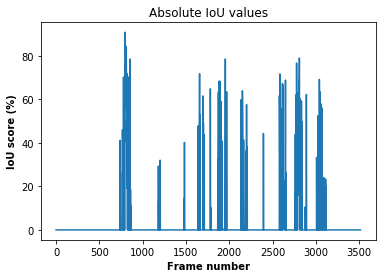

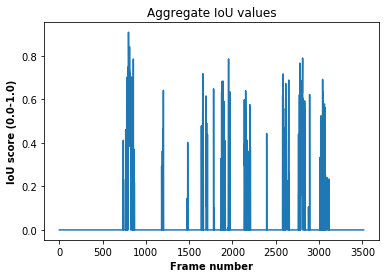

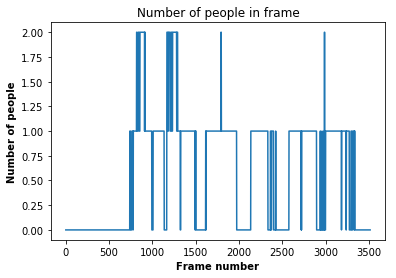

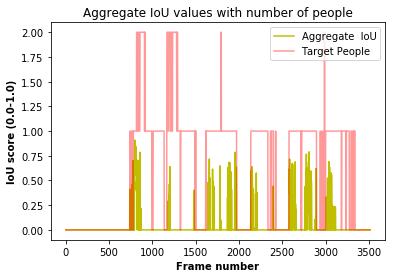

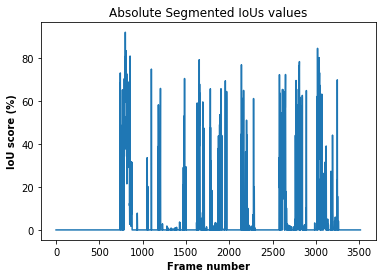

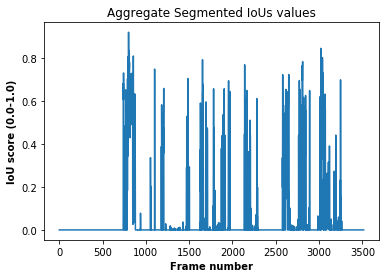

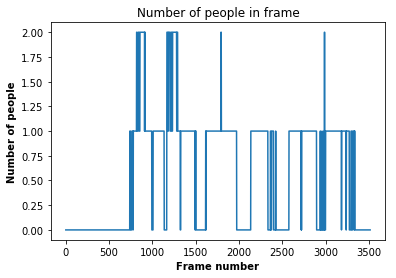

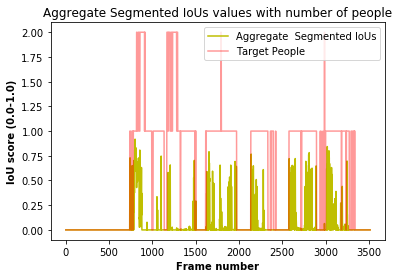

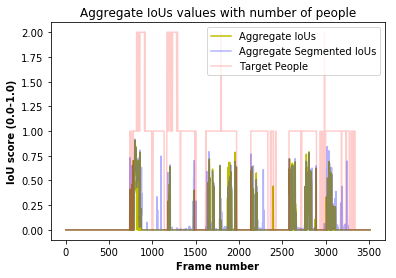

In [40]:
#plot general statistics and save the plots
plots_path = './test2/plots_0.3/'
save_figs = [True, True, False, True];
fig_names = [plots_path + 'abs', plots_path + 'aggr', 'as', plots_path + 'aggr_ppl' ];
fig_namesS = [plots_path + 'absS', plots_path + 'aggrS', 'as', plots_path + 'aggr_pplS' ];
label_IoU = 'IoUs'
label_segmented = 'Segmented IoUs'
plot_all(IoUs, save_figs = save_figs, fig_names = fig_names)
plot_all(segmented_IoUs, label_segmented, save_figs = save_figs, fig_names = fig_namesS)
plot_aggregate_with_people_diffs(IoUs, segmented_IoUs, save_fig = True, fig_name = plots_path + 'diffs')

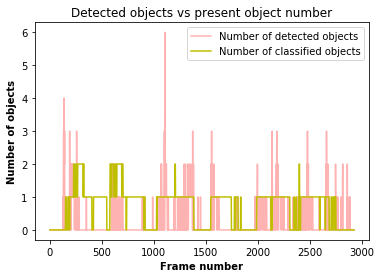

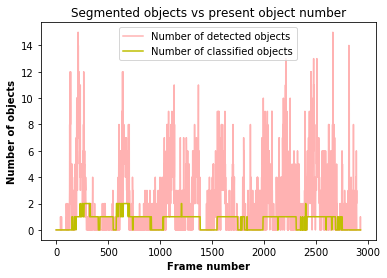

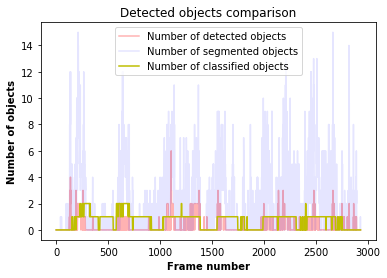

In [39]:
label_classified = 'Detected objects vs present object number'
label_segmented = 'Segmented objects vs present object number'
plot_nb_objects(nb_objects_test, nb_objects_classified, label_classified, save_fig = True, fig_name = plots_path + 'nb_obj')
plot_nb_objects(nb_objects_test, nb_objects_segmented, label_segmented, save_fig = True, fig_name = plots_path + 'nb_segm')
plot_nb_objects_diff(nb_objects_test, nb_objects_classified, nb_objects_segmented, save_fig = True, fig_name = plots_path + 'nb_diff')

In [ ]:
i=0;
while i<3000:
    if nb_objects_classified[i] > 150:
        break;
    i = i+1;
print('Frame', (588 + i));


## Intersection over test box plotting

In [ ]:
IoFs = compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoF)
segmented_IoFs = compute_frames_IoU(labeled_test_boxes, labeled_segmented_boxes, IoF)

In [ ]:
#plot general statistics
label_IoF = 'Intersection over Test Box'
label_segmented_IoF = 'Segmented Intersection over Test Box'
plot_all(IoFs, label_IoF)
plot_all(segmented_IoFs, label_segmented_IoF)
plot_aggregate_with_people_diffs(IoFs, segmented_IoFs, label_IoF, label_segmented_IoF)

## Comparison between IoU's and IoF's

In [ ]:
plot_aggregate_with_people_diffs(IoUs, IoFs, label_IoU, label_IoF)
plot_aggregate_with_people_diffs(segmented_IoUs, segmented_IoFs, label_segmented, label_segmented_IoF)

In [ ]:
IoUs

In [ ]:
plot_all(segmented_IoUs)

In [ ]:
# frames 801 - 844
# rocks classified as: beds (whole picture), cats(segmented)
# people classified as bird, kite, toothbrush, sports ball
# frame 1326 - classification actually looks like a teddy bear
# frame 1363 - backgroung roughly uniform ,looks like a bed

In [ ]:
# coordinates from annotations are centered?
# 640 on x, 480 on y seems decent, but not completely accurate
# 640 + x, 48 + y; center images before computin IoU

In [ ]:
img = read_image_bgr('./test2/dunseverick/frame00878.jpg')

In [ ]:


x = 320;
y = 240;
bbox = (2*x,3*y,3*x,4*y)
image = imcrop(img, bbox)

In [ ]:
process_cropped_image(image)

In [ ]:
img_path = './test2/dunseverick/'
img_name = 'frame01405.jpg'
images = crop_image(img_path, img_name)
boxes = process_cropped_segments(img_path, img_name, True)

In [ ]:
boxes

In [ ]:
labeled_boxes = process_cropped_image(images[9])
bb = labeled_boxes['bird'][1]
print(bb)

In [ ]:
print(labeled_boxes)

In [ ]:
key = 'frame00881'
for obj, arr in labeled_boxes.items():
    for box in arr:
        #box += (640, 240, 640, 240)
        print(type(box))

print (labeled_boxes)

In [ ]:
abc_boxes = {}
abc_boxes[key] = labeled_boxes
res = compute_frame_IoU(key, labeled_test_boxes, abc_boxes)

In [ ]:
print(res)

In [ ]:
img_path = 'test1/images'
classified_path = 'test2/dunseverick_classified'
img_name = 'frame00788.jpg'
image_number = 1000
labeled_boxes = process_cropped_segments(img_path, img_name)
print(labeled_boxes)

In [ ]:
#TODO: CALL THIS AGAIN
#process all segmented images
img_path = 'test2/dunseverick'

img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516
img_format = '.jpg'
labeled_boxes = process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format);
print(labeled_boxes)

In [ ]:
path_folder = './test2/segmented_annotations/'
img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516

save_classifications_to_xml(labeled_boxes, path_folder, img_name_prefix, first_image_number, last_image_number)

In [19]:
xml_segmented_path_folder

NameError: name 'xml_segmented_path_folder' is not defined

In [29]:
get_classifier_config('30%_RUN')

<Section: 30%_RUN>


('test2/dunseverick',
 'test2/dunseverick_classified_0.3',
 'frame',
 588,
 600,
 '.jpg',
 0.3)

In [ ]:
distance seems to explain some, but not all of the performance difference